In [1]:
# Run this only once
import os
os.chdir('..')
# Make sure you are in `pyScalar2d/`
os.getcwd()

'/home/david/git/dalbandea/phd/codes/3-Phi4/pyScalar2D'

In [2]:
%load_ext autoreload
%autoreload 2

# Flowed Hybrid Monte Carlo

In [3]:
from network import *
from hmc import *

TORCH VERSION: 1.9.0+cu102


In [4]:
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


## Lattice definition and model load

In [5]:
# Lattice Theory
L = 8
lattice_shape = (L,L)
dims = 2
beta = 0.6
lmbda = 0.02

# NN Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers, 
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}


# Define lattice class and action
lattice = FlowLattice(L, dims, beta, lmbda, model) # lattice.phi contains current configuration. Check lattice.py
phi4action = ScalarPhi4ActionBeta(beta=0.6, lam=0.02) # Returns action of a torch array containing configurations. Check network.py


use_pretrained = True

Run cell below to load NN into `model`, trained for $L=6, \beta=0.6, \lambda=0.02$

In [6]:
if use_pretrained:
    print('Loading pre-trained model')
    phi4_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
    UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRmxvYXRTdG9yYWdlCnEFWAEAAAAwcQZYBgAAAGN1ZGE6MHEHS0h0cQhRSwAoSwhLAUsDSwN0cQkoSwlLCUsDSwF0cQqJaAApUnELdHEMUnENWAwAAAAwLm5ldC4wLmJpYXNxDmgDKChoBGgFWAEAAAAxcQ9YBgAAAGN1ZGE6MHEQSwh0cRFRSwBLCIVxEksBhXETiWgAKVJxFHRxFVJxFlgOAAAAMC5uZXQuMi53ZWlnaHRxF2gDKChoBGgFWAEAAAAycRhYBgAAAGN1ZGE6MHEZTUACdHEaUUsAKEsISwhLA0sDdHEbKEtISwlLA0sBdHEciWgAKVJxHXRxHlJxH1gMAAAAMC5uZXQuMi5iaWFzcSBoAygoaARoBVgBAAAAM3EhWAYAAABjdWRhOjBxIksIdHEjUUsASwiFcSRLAYVxJYloAClScSZ0cSdScShYDgAAADAubmV0LjQud2VpZ2h0cSloAygoaARoBVgBAAAANHEqWAYAAABjdWRhOjBxK0uQdHEsUUsAKEsCSwhLA0sDdHEtKEtISwlLA0sBdHEuiWgAKVJxL3RxMFJxMVgMAAAAMC5uZXQuNC5iaWFzcTJoAygoaARoBVgBAAAANXEzWAYAAABjdWRhOjBxNEsCdHE1UUsASwKFcTZLAYVxN4loAClScTh0cTlScTpYDgAAADEubmV0LjAud2VpZ2h0cTtoAygoaARoBVgBAAAANnE8WAYAAABjdWRhOjBxPUtIdHE+UUsAKEsISwFLA0sDdHE/KEsJSwlLA0sBdHFAiWgAKVJxQXRxQlJxQ1gMAAAAMS5uZXQuMC5iaWFzcURoAygoaARoBVgBAAAAN3FFWAYAAABjdWRhOjBxRksIdHFHUUsASwiFcUhLAYVxSYloAClScUp0cUtScUxYDgAAADEubmV0LjIud2VpZ2h0cU1oAygoaARoBVgBAAAAOHFOWAYAAABjdWRhOjBxT01AAnRxUFFLAChLCEsISwNLA3RxUShLSEsJSwNLAXRxUoloAClScVN0cVRScVVYDAAAADEubmV0LjIuYmlhc3FWaAMoKGgEaAVYAQAAADlxV1gGAAAAY3VkYTowcVhLCHRxWVFLAEsIhXFaSwGFcVuJaAApUnFcdHFdUnFeWA4AAAAxLm5ldC40LndlaWdodHFfaAMoKGgEaAVYAgAAADEwcWBYBgAAAGN1ZGE6MHFhS5B0cWJRSwAoSwJLCEsDSwN0cWMoS0hLCUsDSwF0cWSJaAApUnFldHFmUnFnWAwAAAAxLm5ldC40LmJpYXNxaGgDKChoBGgFWAIAAAAxMXFpWAYAAABjdWRhOjBxaksCdHFrUUsASwKFcWxLAYVxbYloAClScW50cW9ScXBYDgAAADIubmV0LjAud2VpZ2h0cXFoAygoaARoBVgCAAAAMTJxclgGAAAAY3VkYTowcXNLSHRxdFFLAChLCEsBSwNLA3RxdShLCUsJSwNLAXRxdoloAClScXd0cXhScXlYDAAAADIubmV0LjAuYmlhc3F6aAMoKGgEaAVYAgAAADEzcXtYBgAAAGN1ZGE6MHF8Swh0cX1RSwBLCIVxfksBhXF/iWgAKVJxgHRxgVJxglgOAAAAMi5uZXQuMi53ZWlnaHRxg2gDKChoBGgFWAIAAAAxNHGEWAYAAABjdWRhOjBxhU1AAnRxhlFLAChLCEsISwNLA3RxhyhLSEsJSwNLAXRxiIloAClScYl0cYpScYtYDAAAADIubmV0LjIuYmlhc3GMaAMoKGgEaAVYAgAAADE1cY1YBgAAAGN1ZGE6MHGOSwh0cY9RSwBLCIVxkEsBhXGRiWgAKVJxknRxk1JxlFgOAAAAMi5uZXQuNC53ZWlnaHRxlWgDKChoBGgFWAIAAAAxNnGWWAYAAABjdWRhOjBxl0uQdHGYUUsAKEsCSwhLA0sDdHGZKEtISwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMi5uZXQuNC5iaWFzcZ5oAygoaARoBVgCAAAAMTdxn1gGAAAAY3VkYTowcaBLAnRxoVFLAEsChXGiSwGFcaOJaAApUnGkdHGlUnGmWA4AAAAzLm5ldC4wLndlaWdodHGnaAMoKGgEaAVYAgAAADE4cahYBgAAAGN1ZGE6MHGpS0h0capRSwAoSwhLAUsDSwN0casoSwlLCUsDSwF0cayJaAApUnGtdHGuUnGvWAwAAAAzLm5ldC4wLmJpYXNxsGgDKChoBGgFWAIAAAAxOXGxWAYAAABjdWRhOjBxsksIdHGzUUsASwiFcbRLAYVxtYloAClScbZ0cbdScbhYDgAAADMubmV0LjIud2VpZ2h0cbloAygoaARoBVgCAAAAMjBxulgGAAAAY3VkYTowcbtNQAJ0cbxRSwAoSwhLCEsDSwN0cb0oS0hLCUsDSwF0cb6JaAApUnG/dHHAUnHBWAwAAAAzLm5ldC4yLmJpYXNxwmgDKChoBGgFWAIAAAAyMXHDWAYAAABjdWRhOjBxxEsIdHHFUUsASwiFccZLAYVxx4loAClScch0cclSccpYDgAAADMubmV0LjQud2VpZ2h0cctoAygoaARoBVgCAAAAMjJxzFgGAAAAY3VkYTowcc1LkHRxzlFLAChLAksISwNLA3RxzyhLSEsJSwNLAXRx0IloAClScdF0cdJScdNYDAAAADMubmV0LjQuYmlhc3HUaAMoKGgEaAVYAgAAADIzcdVYBgAAAGN1ZGE6MHHWSwJ0cddRSwBLAoVx2EsBhXHZiWgAKVJx2nRx21Jx3FgOAAAANC5uZXQuMC53ZWlnaHRx3WgDKChoBGgFWAIAAAAyNHHeWAYAAABjdWRhOjBx30tIdHHgUUsAKEsISwFLA0sDdHHhKEsJSwlLA0sBdHHiiWgAKVJx43Rx5FJx5VgMAAAANC5uZXQuMC5iaWFzceZoAygoaARoBVgCAAAAMjVx51gGAAAAY3VkYTowcehLCHRx6VFLAEsIhXHqSwGFceuJaAApUnHsdHHtUnHuWA4AAAA0Lm5ldC4yLndlaWdodHHvaAMoKGgEaAVYAgAAADI2cfBYBgAAAGN1ZGE6MHHxTUACdHHyUUsAKEsISwhLA0sDdHHzKEtISwlLA0sBdHH0iWgAKVJx9XRx9lJx91gMAAAANC5uZXQuMi5iaWFzcfhoAygoaARoBVgCAAAAMjdx+VgGAAAAY3VkYTowcfpLCHRx+1FLAEsIhXH8SwGFcf2JaAApUnH+dHH/UnIAAQAAWA4AAAA0Lm5ldC40LndlaWdodHIBAQAAaAMoKGgEaAVYAgAAADI4cgIBAABYBgAAAGN1ZGE6MHIDAQAAS5B0cgQBAABRSwAoSwJLCEsDSwN0cgUBAAAoS0hLCUsDSwF0cgYBAACJaAApUnIHAQAAdHIIAQAAUnIJAQAAWAwAAAA0Lm5ldC40LmJpYXNyCgEAAGgDKChoBGgFWAIAAAAyOXILAQAAWAYAAABjdWRhOjByDAEAAEsCdHINAQAAUUsASwKFcg4BAABLAYVyDwEAAIloAClSchABAAB0chEBAABSchIBAABYDgAAADUubmV0LjAud2VpZ2h0chMBAABoAygoaARoBVgCAAAAMzByFAEAAFgGAAAAY3VkYTowchUBAABLSHRyFgEAAFFLAChLCEsBSwNLA3RyFwEAAChLCUsJSwNLAXRyGAEAAIloAClSchkBAAB0choBAABSchsBAABYDAAAADUubmV0LjAuYmlhc3IcAQAAaAMoKGgEaAVYAgAAADMxch0BAABYBgAAAGN1ZGE6MHIeAQAASwh0ch8BAABRSwBLCIVyIAEAAEsBhXIhAQAAiWgAKVJyIgEAAHRyIwEAAFJyJAEAAFgOAAAANS5uZXQuMi53ZWlnaHRyJQEAAGgDKChoBGgFWAIAAAAzMnImAQAAWAYAAABjdWRhOjByJwEAAE1AAnRyKAEAAFFLAChLCEsISwNLA3RyKQEAAChLSEsJSwNLAXRyKgEAAIloAClScisBAAB0ciwBAABSci0BAABYDAAAADUubmV0LjIuYmlhc3IuAQAAaAMoKGgEaAVYAgAAADMzci8BAABYBgAAAGN1ZGE6MHIwAQAASwh0cjEBAABRSwBLCIVyMgEAAEsBhXIzAQAAiWgAKVJyNAEAAHRyNQEAAFJyNgEAAFgOAAAANS5uZXQuNC53ZWlnaHRyNwEAAGgDKChoBGgFWAIAAAAzNHI4AQAAWAYAAABjdWRhOjByOQEAAEuQdHI6AQAAUUsAKEsCSwhLA0sDdHI7AQAAKEtISwlLA0sBdHI8AQAAiWgAKVJyPQEAAHRyPgEAAFJyPwEAAFgMAAAANS5uZXQuNC5iaWFzckABAABoAygoaARoBVgCAAAAMzVyQQEAAFgGAAAAY3VkYTowckIBAABLAnRyQwEAAFFLAEsChXJEAQAASwGFckUBAACJaAApUnJGAQAAdHJHAQAAUnJIAQAAWA4AAAA2Lm5ldC4wLndlaWdodHJJAQAAaAMoKGgEaAVYAgAAADM2ckoBAABYBgAAAGN1ZGE6MHJLAQAAS0h0ckwBAABRSwAoSwhLAUsDSwN0ck0BAAAoSwlLCUsDSwF0ck4BAACJaAApUnJPAQAAdHJQAQAAUnJRAQAAWAwAAAA2Lm5ldC4wLmJpYXNyUgEAAGgDKChoBGgFWAIAAAAzN3JTAQAAWAYAAABjdWRhOjByVAEAAEsIdHJVAQAAUUsASwiFclYBAABLAYVyVwEAAIloAClSclgBAAB0clkBAABScloBAABYDgAAADYubmV0LjIud2VpZ2h0clsBAABoAygoaARoBVgCAAAAMzhyXAEAAFgGAAAAY3VkYTowcl0BAABNQAJ0cl4BAABRSwAoSwhLCEsDSwN0cl8BAAAoS0hLCUsDSwF0cmABAACJaAApUnJhAQAAdHJiAQAAUnJjAQAAWAwAAAA2Lm5ldC4yLmJpYXNyZAEAAGgDKChoBGgFWAIAAAAzOXJlAQAAWAYAAABjdWRhOjByZgEAAEsIdHJnAQAAUUsASwiFcmgBAABLAYVyaQEAAIloAClScmoBAAB0cmsBAABScmwBAABYDgAAADYubmV0LjQud2VpZ2h0cm0BAABoAygoaARoBVgCAAAANDBybgEAAFgGAAAAY3VkYTowcm8BAABLkHRycAEAAFFLAChLAksISwNLA3RycQEAAChLSEsJSwNLAXRycgEAAIloAClScnMBAAB0cnQBAABScnUBAABYDAAAADYubmV0LjQuYmlhc3J2AQAAaAMoKGgEaAVYAgAAADQxcncBAABYBgAAAGN1ZGE6MHJ4AQAASwJ0cnkBAABRSwBLAoVyegEAAEsBhXJ7AQAAiWgAKVJyfAEAAHRyfQEAAFJyfgEAAFgOAAAANy5uZXQuMC53ZWlnaHRyfwEAAGgDKChoBGgFWAIAAAA0MnKAAQAAWAYAAABjdWRhOjBygQEAAEtIdHKCAQAAUUsAKEsISwFLA0sDdHKDAQAAKEsJSwlLA0sBdHKEAQAAiWgAKVJyhQEAAHRyhgEAAFJyhwEAAFgMAAAANy5uZXQuMC5iaWFzcogBAABoAygoaARoBVgCAAAANDNyiQEAAFgGAAAAY3VkYTowcooBAABLCHRyiwEAAFFLAEsIhXKMAQAASwGFco0BAACJaAApUnKOAQAAdHKPAQAAUnKQAQAAWA4AAAA3Lm5ldC4yLndlaWdodHKRAQAAaAMoKGgEaAVYAgAAADQ0cpIBAABYBgAAAGN1ZGE6MHKTAQAATUACdHKUAQAAUUsAKEsISwhLA0sDdHKVAQAAKEtISwlLA0sBdHKWAQAAiWgAKVJylwEAAHRymAEAAFJymQEAAFgMAAAANy5uZXQuMi5iaWFzcpoBAABoAygoaARoBVgCAAAANDVymwEAAFgGAAAAY3VkYTowcpwBAABLCHRynQEAAFFLAEsIhXKeAQAASwGFcp8BAACJaAApUnKgAQAAdHKhAQAAUnKiAQAAWA4AAAA3Lm5ldC40LndlaWdodHKjAQAAaAMoKGgEaAVYAgAAADQ2cqQBAABYBgAAAGN1ZGE6MHKlAQAAS5B0cqYBAABRSwAoSwJLCEsDSwN0cqcBAAAoS0hLCUsDSwF0cqgBAACJaAApUnKpAQAAdHKqAQAAUnKrAQAAWAwAAAA3Lm5ldC40LmJpYXNyrAEAAGgDKChoBGgFWAIAAAA0N3KtAQAAWAYAAABjdWRhOjByrgEAAEsCdHKvAQAAUUsASwKFcrABAABLAYVysQEAAIloAClScrIBAAB0crMBAABScrQBAABYDgAAADgubmV0LjAud2VpZ2h0crUBAABoAygoaARoBVgCAAAANDhytgEAAFgGAAAAY3VkYTowcrcBAABLSHRyuAEAAFFLAChLCEsBSwNLA3RyuQEAAChLCUsJSwNLAXRyugEAAIloAClScrsBAAB0crwBAABScr0BAABYDAAAADgubmV0LjAuYmlhc3K+AQAAaAMoKGgEaAVYAgAAADQ5cr8BAABYBgAAAGN1ZGE6MHLAAQAASwh0csEBAABRSwBLCIVywgEAAEsBhXLDAQAAiWgAKVJyxAEAAHRyxQEAAFJyxgEAAFgOAAAAOC5uZXQuMi53ZWlnaHRyxwEAAGgDKChoBGgFWAIAAAA1MHLIAQAAWAYAAABjdWRhOjByyQEAAE1AAnRyygEAAFFLAChLCEsISwNLA3RyywEAAChLSEsJSwNLAXRyzAEAAIloAClScs0BAAB0cs4BAABScs8BAABYDAAAADgubmV0LjIuYmlhc3LQAQAAaAMoKGgEaAVYAgAAADUxctEBAABYBgAAAGN1ZGE6MHLSAQAASwh0ctMBAABRSwBLCIVy1AEAAEsBhXLVAQAAiWgAKVJy1gEAAHRy1wEAAFJy2AEAAFgOAAAAOC5uZXQuNC53ZWlnaHRy2QEAAGgDKChoBGgFWAIAAAA1MnLaAQAAWAYAAABjdWRhOjBy2wEAAEuQdHLcAQAAUUsAKEsCSwhLA0sDdHLdAQAAKEtISwlLA0sBdHLeAQAAiWgAKVJy3wEAAHRy4AEAAFJy4QEAAFgMAAAAOC5uZXQuNC5iaWFzcuIBAABoAygoaARoBVgCAAAANTNy4wEAAFgGAAAAY3VkYTowcuQBAABLAnRy5QEAAFFLAEsChXLmAQAASwGFcucBAACJaAApUnLoAQAAdHLpAQAAUnLqAQAAWA4AAAA5Lm5ldC4wLndlaWdodHLrAQAAaAMoKGgEaAVYAgAAADU0cuwBAABYBgAAAGN1ZGE6MHLtAQAAS0h0cu4BAABRSwAoSwhLAUsDSwN0cu8BAAAoSwlLCUsDSwF0cvABAACJaAApUnLxAQAAdHLyAQAAUnLzAQAAWAwAAAA5Lm5ldC4wLmJpYXNy9AEAAGgDKChoBGgFWAIAAAA1NXL1AQAAWAYAAABjdWRhOjBy9gEAAEsIdHL3AQAAUUsASwiFcvgBAABLAYVy+QEAAIloAClScvoBAAB0cvsBAABScvwBAABYDgAAADkubmV0LjIud2VpZ2h0cv0BAABoAygoaARoBVgCAAAANTZy/gEAAFgGAAAAY3VkYTowcv8BAABNQAJ0cgACAABRSwAoSwhLCEsDSwN0cgECAAAoS0hLCUsDSwF0cgICAACJaAApUnIDAgAAdHIEAgAAUnIFAgAAWAwAAAA5Lm5ldC4yLmJpYXNyBgIAAGgDKChoBGgFWAIAAAA1N3IHAgAAWAYAAABjdWRhOjByCAIAAEsIdHIJAgAAUUsASwiFcgoCAABLAYVyCwIAAIloAClScgwCAAB0cg0CAABScg4CAABYDgAAADkubmV0LjQud2VpZ2h0cg8CAABoAygoaARoBVgCAAAANThyEAIAAFgGAAAAY3VkYTowchECAABLkHRyEgIAAFFLAChLAksISwNLA3RyEwIAAChLSEsJSwNLAXRyFAIAAIloAClSchUCAAB0chYCAABSchcCAABYDAAAADkubmV0LjQuYmlhc3IYAgAAaAMoKGgEaAVYAgAAADU5chkCAABYBgAAAGN1ZGE6MHIaAgAASwJ0chsCAABRSwBLAoVyHAIAAEsBhXIdAgAAiWgAKVJyHgIAAHRyHwIAAFJyIAIAAFgPAAAAMTAubmV0LjAud2VpZ2h0ciECAABoAygoaARoBVgCAAAANjByIgIAAFgGAAAAY3VkYTowciMCAABLSHRyJAIAAFFLAChLCEsBSwNLA3RyJQIAAChLCUsJSwNLAXRyJgIAAIloAClScicCAAB0cigCAABScikCAABYDQAAADEwLm5ldC4wLmJpYXNyKgIAAGgDKChoBGgFWAIAAAA2MXIrAgAAWAYAAABjdWRhOjByLAIAAEsIdHItAgAAUUsASwiFci4CAABLAYVyLwIAAIloAClScjACAAB0cjECAABScjICAABYDwAAADEwLm5ldC4yLndlaWdodHIzAgAAaAMoKGgEaAVYAgAAADYycjQCAABYBgAAAGN1ZGE6MHI1AgAATUACdHI2AgAAUUsAKEsISwhLA0sDdHI3AgAAKEtISwlLA0sBdHI4AgAAiWgAKVJyOQIAAHRyOgIAAFJyOwIAAFgNAAAAMTAubmV0LjIuYmlhc3I8AgAAaAMoKGgEaAVYAgAAADYzcj0CAABYBgAAAGN1ZGE6MHI+AgAASwh0cj8CAABRSwBLCIVyQAIAAEsBhXJBAgAAiWgAKVJyQgIAAHRyQwIAAFJyRAIAAFgPAAAAMTAubmV0LjQud2VpZ2h0ckUCAABoAygoaARoBVgCAAAANjRyRgIAAFgGAAAAY3VkYTowckcCAABLkHRySAIAAFFLAChLAksISwNLA3RySQIAAChLSEsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEwLm5ldC40LmJpYXNyTgIAAGgDKChoBGgFWAIAAAA2NXJPAgAAWAYAAABjdWRhOjByUAIAAEsCdHJRAgAAUUsASwKFclICAABLAYVyUwIAAIloAClSclQCAAB0clUCAABSclYCAABYDwAAADExLm5ldC4wLndlaWdodHJXAgAAaAMoKGgEaAVYAgAAADY2clgCAABYBgAAAGN1ZGE6MHJZAgAAS0h0cloCAABRSwAoSwhLAUsDSwN0clsCAAAoSwlLCUsDSwF0clwCAACJaAApUnJdAgAAdHJeAgAAUnJfAgAAWA0AAAAxMS5uZXQuMC5iaWFzcmACAABoAygoaARoBVgCAAAANjdyYQIAAFgGAAAAY3VkYTowcmICAABLCHRyYwIAAFFLAEsIhXJkAgAASwGFcmUCAACJaAApUnJmAgAAdHJnAgAAUnJoAgAAWA8AAAAxMS5uZXQuMi53ZWlnaHRyaQIAAGgDKChoBGgFWAIAAAA2OHJqAgAAWAYAAABjdWRhOjByawIAAE1AAnRybAIAAFFLAChLCEsISwNLA3RybQIAAChLSEsJSwNLAXRybgIAAIloAClScm8CAAB0cnACAABScnECAABYDQAAADExLm5ldC4yLmJpYXNycgIAAGgDKChoBGgFWAIAAAA2OXJzAgAAWAYAAABjdWRhOjBydAIAAEsIdHJ1AgAAUUsASwiFcnYCAABLAYVydwIAAIloAClScngCAAB0cnkCAABScnoCAABYDwAAADExLm5ldC40LndlaWdodHJ7AgAAaAMoKGgEaAVYAgAAADcwcnwCAABYBgAAAGN1ZGE6MHJ9AgAAS5B0cn4CAABRSwAoSwJLCEsDSwN0cn8CAAAoS0hLCUsDSwF0coACAACJaAApUnKBAgAAdHKCAgAAUnKDAgAAWA0AAAAxMS5uZXQuNC5iaWFzcoQCAABoAygoaARoBVgCAAAANzFyhQIAAFgGAAAAY3VkYTowcoYCAABLAnRyhwIAAFFLAEsChXKIAgAASwGFcokCAACJaAApUnKKAgAAdHKLAgAAUnKMAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyjQIAAGgDKChoBGgFWAIAAAA3MnKOAgAAWAYAAABjdWRhOjByjwIAAEtIdHKQAgAAUUsAKEsISwFLA0sDdHKRAgAAKEsJSwlLA0sBdHKSAgAAiWgAKVJykwIAAHRylAIAAFJylQIAAFgNAAAAMTIubmV0LjAuYmlhc3KWAgAAaAMoKGgEaAVYAgAAADczcpcCAABYBgAAAGN1ZGE6MHKYAgAASwh0cpkCAABRSwBLCIVymgIAAEsBhXKbAgAAiWgAKVJynAIAAHRynQIAAFJyngIAAFgPAAAAMTIubmV0LjIud2VpZ2h0cp8CAABoAygoaARoBVgCAAAANzRyoAIAAFgGAAAAY3VkYTowcqECAABNQAJ0cqICAABRSwAoSwhLCEsDSwN0cqMCAAAoS0hLCUsDSwF0cqQCAACJaAApUnKlAgAAdHKmAgAAUnKnAgAAWA0AAAAxMi5uZXQuMi5iaWFzcqgCAABoAygoaARoBVgCAAAANzVyqQIAAFgGAAAAY3VkYTowcqoCAABLCHRyqwIAAFFLAEsIhXKsAgAASwGFcq0CAACJaAApUnKuAgAAdHKvAgAAUnKwAgAAWA8AAAAxMi5uZXQuNC53ZWlnaHRysQIAAGgDKChoBGgFWAIAAAA3NnKyAgAAWAYAAABjdWRhOjByswIAAEuQdHK0AgAAUUsAKEsCSwhLA0sDdHK1AgAAKEtISwlLA0sBdHK2AgAAiWgAKVJytwIAAHRyuAIAAFJyuQIAAFgNAAAAMTIubmV0LjQuYmlhc3K6AgAAaAMoKGgEaAVYAgAAADc3crsCAABYBgAAAGN1ZGE6MHK8AgAASwJ0cr0CAABRSwBLAoVyvgIAAEsBhXK/AgAAiWgAKVJywAIAAHRywQIAAFJywgIAAFgPAAAAMTMubmV0LjAud2VpZ2h0csMCAABoAygoaARoBVgCAAAANzhyxAIAAFgGAAAAY3VkYTowcsUCAABLSHRyxgIAAFFLAChLCEsBSwNLA3RyxwIAAChLCUsJSwNLAXRyyAIAAIloAClScskCAAB0csoCAABScssCAABYDQAAADEzLm5ldC4wLmJpYXNyzAIAAGgDKChoBGgFWAIAAAA3OXLNAgAAWAYAAABjdWRhOjByzgIAAEsIdHLPAgAAUUsASwiFctACAABLAYVy0QIAAIloAClSctICAAB0ctMCAABSctQCAABYDwAAADEzLm5ldC4yLndlaWdodHLVAgAAaAMoKGgEaAVYAgAAADgwctYCAABYBgAAAGN1ZGE6MHLXAgAATUACdHLYAgAAUUsAKEsISwhLA0sDdHLZAgAAKEtISwlLA0sBdHLaAgAAiWgAKVJy2wIAAHRy3AIAAFJy3QIAAFgNAAAAMTMubmV0LjIuYmlhc3LeAgAAaAMoKGgEaAVYAgAAADgxct8CAABYBgAAAGN1ZGE6MHLgAgAASwh0cuECAABRSwBLCIVy4gIAAEsBhXLjAgAAiWgAKVJy5AIAAHRy5QIAAFJy5gIAAFgPAAAAMTMubmV0LjQud2VpZ2h0cucCAABoAygoaARoBVgCAAAAODJy6AIAAFgGAAAAY3VkYTowcukCAABLkHRy6gIAAFFLAChLAksISwNLA3Ry6wIAAChLSEsJSwNLAXRy7AIAAIloAClScu0CAAB0cu4CAABScu8CAABYDQAAADEzLm5ldC40LmJpYXNy8AIAAGgDKChoBGgFWAIAAAA4M3LxAgAAWAYAAABjdWRhOjBy8gIAAEsCdHLzAgAAUUsASwKFcvQCAABLAYVy9QIAAIloAClScvYCAAB0cvcCAABScvgCAABYDwAAADE0Lm5ldC4wLndlaWdodHL5AgAAaAMoKGgEaAVYAgAAADg0cvoCAABYBgAAAGN1ZGE6MHL7AgAAS0h0cvwCAABRSwAoSwhLAUsDSwN0cv0CAAAoSwlLCUsDSwF0cv4CAACJaAApUnL/AgAAdHIAAwAAUnIBAwAAWA0AAAAxNC5uZXQuMC5iaWFzcgIDAABoAygoaARoBVgCAAAAODVyAwMAAFgGAAAAY3VkYTowcgQDAABLCHRyBQMAAFFLAEsIhXIGAwAASwGFcgcDAACJaAApUnIIAwAAdHIJAwAAUnIKAwAAWA8AAAAxNC5uZXQuMi53ZWlnaHRyCwMAAGgDKChoBGgFWAIAAAA4NnIMAwAAWAYAAABjdWRhOjByDQMAAE1AAnRyDgMAAFFLAChLCEsISwNLA3RyDwMAAChLSEsJSwNLAXRyEAMAAIloAClSchEDAAB0chIDAABSchMDAABYDQAAADE0Lm5ldC4yLmJpYXNyFAMAAGgDKChoBGgFWAIAAAA4N3IVAwAAWAYAAABjdWRhOjByFgMAAEsIdHIXAwAAUUsASwiFchgDAABLAYVyGQMAAIloAClSchoDAAB0chsDAABSchwDAABYDwAAADE0Lm5ldC40LndlaWdodHIdAwAAaAMoKGgEaAVYAgAAADg4ch4DAABYBgAAAGN1ZGE6MHIfAwAAS5B0ciADAABRSwAoSwJLCEsDSwN0ciEDAAAoS0hLCUsDSwF0ciIDAACJaAApUnIjAwAAdHIkAwAAUnIlAwAAWA0AAAAxNC5uZXQuNC5iaWFzciYDAABoAygoaARoBVgCAAAAODlyJwMAAFgGAAAAY3VkYTowcigDAABLAnRyKQMAAFFLAEsChXIqAwAASwGFcisDAACJaAApUnIsAwAAdHItAwAAUnIuAwAAWA8AAAAxNS5uZXQuMC53ZWlnaHRyLwMAAGgDKChoBGgFWAIAAAA5MHIwAwAAWAYAAABjdWRhOjByMQMAAEtIdHIyAwAAUUsAKEsISwFLA0sDdHIzAwAAKEsJSwlLA0sBdHI0AwAAiWgAKVJyNQMAAHRyNgMAAFJyNwMAAFgNAAAAMTUubmV0LjAuYmlhc3I4AwAAaAMoKGgEaAVYAgAAADkxcjkDAABYBgAAAGN1ZGE6MHI6AwAASwh0cjsDAABRSwBLCIVyPAMAAEsBhXI9AwAAiWgAKVJyPgMAAHRyPwMAAFJyQAMAAFgPAAAAMTUubmV0LjIud2VpZ2h0ckEDAABoAygoaARoBVgCAAAAOTJyQgMAAFgGAAAAY3VkYTowckMDAABNQAJ0ckQDAABRSwAoSwhLCEsDSwN0ckUDAAAoS0hLCUsDSwF0ckYDAACJaAApUnJHAwAAdHJIAwAAUnJJAwAAWA0AAAAxNS5uZXQuMi5iaWFzckoDAABoAygoaARoBVgCAAAAOTNySwMAAFgGAAAAY3VkYTowckwDAABLCHRyTQMAAFFLAEsIhXJOAwAASwGFck8DAACJaAApUnJQAwAAdHJRAwAAUnJSAwAAWA8AAAAxNS5uZXQuNC53ZWlnaHRyUwMAAGgDKChoBGgFWAIAAAA5NHJUAwAAWAYAAABjdWRhOjByVQMAAEuQdHJWAwAAUUsAKEsCSwhLA0sDdHJXAwAAKEtISwlLA0sBdHJYAwAAiWgAKVJyWQMAAHRyWgMAAFJyWwMAAFgNAAAAMTUubmV0LjQuYmlhc3JcAwAAaAMoKGgEaAVYAgAAADk1cl0DAABYBgAAAGN1ZGE6MHJeAwAASwJ0cl8DAABRSwBLAoVyYAMAAEsBhXJhAwAAiWgAKVJyYgMAAHRyYwMAAFJyZAMAAHV9cmUDAABYCQAAAF9tZXRhZGF0YXJmAwAAaAApUnJnAwAAKFgAAAAAcmgDAAB9cmkDAABYBwAAAHZlcnNpb25yagMAAEsBc1gBAAAAMHJrAwAAfXJsAwAAamoDAABLAXNYBQAAADAubmV0cm0DAAB9cm4DAABqagMAAEsBc1gHAAAAMC5uZXQuMHJvAwAAfXJwAwAAamoDAABLAXNYBwAAADAubmV0LjFycQMAAH1ycgMAAGpqAwAASwFzWAcAAAAwLm5ldC4ycnMDAAB9cnQDAABqagMAAEsBc1gHAAAAMC5uZXQuM3J1AwAAfXJ2AwAAamoDAABLAXNYBwAAADAubmV0LjRydwMAAH1yeAMAAGpqAwAASwFzWAcAAAAwLm5ldC41cnkDAAB9cnoDAABqagMAAEsBc1gBAAAAMXJ7AwAAfXJ8AwAAamoDAABLAXNYBQAAADEubmV0cn0DAAB9cn4DAABqagMAAEsBc1gHAAAAMS5uZXQuMHJ/AwAAfXKAAwAAamoDAABLAXNYBwAAADEubmV0LjFygQMAAH1yggMAAGpqAwAASwFzWAcAAAAxLm5ldC4ycoMDAAB9coQDAABqagMAAEsBc1gHAAAAMS5uZXQuM3KFAwAAfXKGAwAAamoDAABLAXNYBwAAADEubmV0LjRyhwMAAH1yiAMAAGpqAwAASwFzWAcAAAAxLm5ldC41cokDAAB9cooDAABqagMAAEsBc1gBAAAAMnKLAwAAfXKMAwAAamoDAABLAXNYBQAAADIubmV0co0DAAB9co4DAABqagMAAEsBc1gHAAAAMi5uZXQuMHKPAwAAfXKQAwAAamoDAABLAXNYBwAAADIubmV0LjFykQMAAH1ykgMAAGpqAwAASwFzWAcAAAAyLm5ldC4ycpMDAAB9cpQDAABqagMAAEsBc1gHAAAAMi5uZXQuM3KVAwAAfXKWAwAAamoDAABLAXNYBwAAADIubmV0LjRylwMAAH1ymAMAAGpqAwAASwFzWAcAAAAyLm5ldC41cpkDAAB9cpoDAABqagMAAEsBc1gBAAAAM3KbAwAAfXKcAwAAamoDAABLAXNYBQAAADMubmV0cp0DAAB9cp4DAABqagMAAEsBc1gHAAAAMy5uZXQuMHKfAwAAfXKgAwAAamoDAABLAXNYBwAAADMubmV0LjFyoQMAAH1yogMAAGpqAwAASwFzWAcAAAAzLm5ldC4ycqMDAAB9cqQDAABqagMAAEsBc1gHAAAAMy5uZXQuM3KlAwAAfXKmAwAAamoDAABLAXNYBwAAADMubmV0LjRypwMAAH1yqAMAAGpqAwAASwFzWAcAAAAzLm5ldC41cqkDAAB9cqoDAABqagMAAEsBc1gBAAAANHKrAwAAfXKsAwAAamoDAABLAXNYBQAAADQubmV0cq0DAAB9cq4DAABqagMAAEsBc1gHAAAANC5uZXQuMHKvAwAAfXKwAwAAamoDAABLAXNYBwAAADQubmV0LjFysQMAAH1ysgMAAGpqAwAASwFzWAcAAAA0Lm5ldC4ycrMDAAB9crQDAABqagMAAEsBc1gHAAAANC5uZXQuM3K1AwAAfXK2AwAAamoDAABLAXNYBwAAADQubmV0LjRytwMAAH1yuAMAAGpqAwAASwFzWAcAAAA0Lm5ldC41crkDAAB9croDAABqagMAAEsBc1gBAAAANXK7AwAAfXK8AwAAamoDAABLAXNYBQAAADUubmV0cr0DAAB9cr4DAABqagMAAEsBc1gHAAAANS5uZXQuMHK/AwAAfXLAAwAAamoDAABLAXNYBwAAADUubmV0LjFywQMAAH1ywgMAAGpqAwAASwFzWAcAAAA1Lm5ldC4ycsMDAAB9csQDAABqagMAAEsBc1gHAAAANS5uZXQuM3LFAwAAfXLGAwAAamoDAABLAXNYBwAAADUubmV0LjRyxwMAAH1yyAMAAGpqAwAASwFzWAcAAAA1Lm5ldC41cskDAAB9csoDAABqagMAAEsBc1gBAAAANnLLAwAAfXLMAwAAamoDAABLAXNYBQAAADYubmV0cs0DAAB9cs4DAABqagMAAEsBc1gHAAAANi5uZXQuMHLPAwAAfXLQAwAAamoDAABLAXNYBwAAADYubmV0LjFy0QMAAH1y0gMAAGpqAwAASwFzWAcAAAA2Lm5ldC4yctMDAAB9ctQDAABqagMAAEsBc1gHAAAANi5uZXQuM3LVAwAAfXLWAwAAamoDAABLAXNYBwAAADYubmV0LjRy1wMAAH1y2AMAAGpqAwAASwFzWAcAAAA2Lm5ldC41ctkDAAB9ctoDAABqagMAAEsBc1gBAAAAN3LbAwAAfXLcAwAAamoDAABLAXNYBQAAADcubmV0ct0DAAB9ct4DAABqagMAAEsBc1gHAAAANy5uZXQuMHLfAwAAfXLgAwAAamoDAABLAXNYBwAAADcubmV0LjFy4QMAAH1y4gMAAGpqAwAASwFzWAcAAAA3Lm5ldC4ycuMDAAB9cuQDAABqagMAAEsBc1gHAAAANy5uZXQuM3LlAwAAfXLmAwAAamoDAABLAXNYBwAAADcubmV0LjRy5wMAAH1y6AMAAGpqAwAASwFzWAcAAAA3Lm5ldC41cukDAAB9cuoDAABqagMAAEsBc1gBAAAAOHLrAwAAfXLsAwAAamoDAABLAXNYBQAAADgubmV0cu0DAAB9cu4DAABqagMAAEsBc1gHAAAAOC5uZXQuMHLvAwAAfXLwAwAAamoDAABLAXNYBwAAADgubmV0LjFy8QMAAH1y8gMAAGpqAwAASwFzWAcAAAA4Lm5ldC4ycvMDAAB9cvQDAABqagMAAEsBc1gHAAAAOC5uZXQuM3L1AwAAfXL2AwAAamoDAABLAXNYBwAAADgubmV0LjRy9wMAAH1y+AMAAGpqAwAASwFzWAcAAAA4Lm5ldC41cvkDAAB9cvoDAABqagMAAEsBc1gBAAAAOXL7AwAAfXL8AwAAamoDAABLAXNYBQAAADkubmV0cv0DAAB9cv4DAABqagMAAEsBc1gHAAAAOS5uZXQuMHL/AwAAfXIABAAAamoDAABLAXNYBwAAADkubmV0LjFyAQQAAH1yAgQAAGpqAwAASwFzWAcAAAA5Lm5ldC4ycgMEAAB9cgQEAABqagMAAEsBc1gHAAAAOS5uZXQuM3IFBAAAfXIGBAAAamoDAABLAXNYBwAAADkubmV0LjRyBwQAAH1yCAQAAGpqAwAASwFzWAcAAAA5Lm5ldC41cgkEAAB9cgoEAABqagMAAEsBc1gCAAAAMTByCwQAAH1yDAQAAGpqAwAASwFzWAYAAAAxMC5uZXRyDQQAAH1yDgQAAGpqAwAASwFzWAgAAAAxMC5uZXQuMHIPBAAAfXIQBAAAamoDAABLAXNYCAAAADEwLm5ldC4xchEEAAB9chIEAABqagMAAEsBc1gIAAAAMTAubmV0LjJyEwQAAH1yFAQAAGpqAwAASwFzWAgAAAAxMC5uZXQuM3IVBAAAfXIWBAAAamoDAABLAXNYCAAAADEwLm5ldC40chcEAAB9chgEAABqagMAAEsBc1gIAAAAMTAubmV0LjVyGQQAAH1yGgQAAGpqAwAASwFzWAIAAAAxMXIbBAAAfXIcBAAAamoDAABLAXNYBgAAADExLm5ldHIdBAAAfXIeBAAAamoDAABLAXNYCAAAADExLm5ldC4wch8EAAB9ciAEAABqagMAAEsBc1gIAAAAMTEubmV0LjFyIQQAAH1yIgQAAGpqAwAASwFzWAgAAAAxMS5uZXQuMnIjBAAAfXIkBAAAamoDAABLAXNYCAAAADExLm5ldC4zciUEAAB9ciYEAABqagMAAEsBc1gIAAAAMTEubmV0LjRyJwQAAH1yKAQAAGpqAwAASwFzWAgAAAAxMS5uZXQuNXIpBAAAfXIqBAAAamoDAABLAXNYAgAAADEycisEAAB9ciwEAABqagMAAEsBc1gGAAAAMTIubmV0ci0EAAB9ci4EAABqagMAAEsBc1gIAAAAMTIubmV0LjByLwQAAH1yMAQAAGpqAwAASwFzWAgAAAAxMi5uZXQuMXIxBAAAfXIyBAAAamoDAABLAXNYCAAAADEyLm5ldC4ycjMEAAB9cjQEAABqagMAAEsBc1gIAAAAMTIubmV0LjNyNQQAAH1yNgQAAGpqAwAASwFzWAgAAAAxMi5uZXQuNHI3BAAAfXI4BAAAamoDAABLAXNYCAAAADEyLm5ldC41cjkEAAB9cjoEAABqagMAAEsBc1gCAAAAMTNyOwQAAH1yPAQAAGpqAwAASwFzWAYAAAAxMy5uZXRyPQQAAH1yPgQAAGpqAwAASwFzWAgAAAAxMy5uZXQuMHI/BAAAfXJABAAAamoDAABLAXNYCAAAADEzLm5ldC4xckEEAAB9ckIEAABqagMAAEsBc1gIAAAAMTMubmV0LjJyQwQAAH1yRAQAAGpqAwAASwFzWAgAAAAxMy5uZXQuM3JFBAAAfXJGBAAAamoDAABLAXNYCAAAADEzLm5ldC40ckcEAAB9ckgEAABqagMAAEsBc1gIAAAAMTMubmV0LjVySQQAAH1ySgQAAGpqAwAASwFzWAIAAAAxNHJLBAAAfXJMBAAAamoDAABLAXNYBgAAADE0Lm5ldHJNBAAAfXJOBAAAamoDAABLAXNYCAAAADE0Lm5ldC4wck8EAAB9clAEAABqagMAAEsBc1gIAAAAMTQubmV0LjFyUQQAAH1yUgQAAGpqAwAASwFzWAgAAAAxNC5uZXQuMnJTBAAAfXJUBAAAamoDAABLAXNYCAAAADE0Lm5ldC4zclUEAAB9clYEAABqagMAAEsBc1gIAAAAMTQubmV0LjRyVwQAAH1yWAQAAGpqAwAASwFzWAgAAAAxNC5uZXQuNXJZBAAAfXJaBAAAamoDAABLAXNYAgAAADE1clsEAAB9clwEAABqagMAAEsBc1gGAAAAMTUubmV0cl0EAAB9cl4EAABqagMAAEsBc1gIAAAAMTUubmV0LjByXwQAAH1yYAQAAGpqAwAASwFzWAgAAAAxNS5uZXQuMXJhBAAAfXJiBAAAamoDAABLAXNYCAAAADE1Lm5ldC4ycmMEAAB9cmQEAABqagMAAEsBc1gIAAAAMTUubmV0LjNyZQQAAH1yZgQAAGpqAwAASwFzWAgAAAAxNS5uZXQuNHJnBAAAfXJoBAAAamoDAABLAXNYCAAAADE1Lm5ldC41cmkEAAB9cmoEAABqagMAAEsBc3VzYi5QSwcIeJ937Tg4AAA4OAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAwAYXJjaGl2ZS9kYXRhLzBGQggAWlpaWlpaWloDzes9/8Z0vhykYb5WyJU+ig2OvsKxgb0WvhA9V5jxPasVTb567ig9zchRvUhwzT1vHU09EQqCPcXxnD65LKm9YA5+u/8daz12+wA8832/vitJRT6D8YW9rOtuPtk8rb0HFX69L7BFPjWnpT7MNxs+dK7fPZsCpTt0dZe+uiOsvj+gUr5fzJM+E5L0vK7Xpz5RvYU9mAxIPhklIL4sMgy+oBsPPiwW67xMKZ2++rD8PYOM8L7OLgE+ttoIPv/Ddr7br6c+t+HSPbylD75QafK90OgdPGvn7L4n8bG9EhcuvS73BD5Jw649gw5ivgWdgj7ixF8+I6Cevu6a5j1e2YK+05PRPGtFKj51fgu+tvaUPqDmcToPqEE9YtJ6vobFKD5QSwcIC1oY3CABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOACQAYXJjaGl2ZS9kYXRhLzFGQiAAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrRUIC+KfyXPinLmD6T4EG+jSs1uw/Plz5i2VK+qU1uvlBLBwjysOwDIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvMTBGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWknuDr0Y49A8GWEhuoAmuj17pOq9Rj8avZbj5Tz1PDy8u0YdPSqxdryH/5y9o93GOP+SFL1T+P+84ip9PDLgfT0tWVe9tHplPZpGbr390QM93JgavUdPJj3k6hK8klj7OyN5QD2H3E+9vHvKOSBZo7ydJJg9RK8JvV80DL5F+p+9PrFSPQAcBb6z3qi9cQR0vbgJE760aDG8voAMvdunPD1PMz49SbozPYADVL1RzLK9fe/LPGvPcb0Rt+y94UpSu+dnNj3w8As8b68OvaoHRzzkUPW8F6dhPQtvXz0dv9y9Mw8UPA+wOL3fSZk9n/IJPSQomT2Fyv68lHEjPT3IAb5xHci9+gttPZIQZr0duTK9nzfovdzFBr30g7C9RzyePT1k7ru/K4G8n1QUumZrwL1QP5U87qtdPOmtxjwAnDS9Zm+dPMy89zwdHoo9DOVmPIL9+j2tzlc90L2GPOEaxr3MHyM8Q4V2vYZj7L0JV8C97oSwvGMIhb3nQuE8JE2RvXvkir1JOOY8tKnPu42LDjw+v3E+W+ddvbWPoD6HtpE+k6paPmxk0D0IYG29aiDqPcGMkz5SUBO9B4VjveNRp723s2C82uGQvIiOb7wiLnI9yGd0PdFvAj5z0gE+xl9GPZlQgLwlRIe8vQ2UvRELNT0YRZA8wzlQvV+poL04Scc8isM8vb5xsz11z827h6WcPSA20z1vAKq9fpSrPdOBKD0wP+K8xhzqvFS7RT6xGJU99rf9PCVmCb7Reag9aA8VvlBLBwiiiHTuQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa6l7OPe3RuD1QSwcImtmhqggAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzEyRkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlremPS8BfIqvp3GhD6slAe+xOCGPkzQSL4ZjHc9v4UJvFl5Rb7hoFu++z3MPT6Tgr2mPBu+3x2FPr7/TD4jZbm9OR/JveSjdr3rPiK+DvajPigdXj7V8j++VvxdPhNDOb6ZwT8+LDtBPQO0JD794YC7j0ZuvoNai73bEZY9Kv+cPk+ZAT2P7aS96uFdvi7OL71JrtK9d/yGvqbfoL7MEYY97KysPa9loL7NGw2+Dz5+vm8TQr5Uyu29kS9ivnB93j0r/U++418AvhiRJzw6IoU+3ki+vfrd4r1GyA2+tgjuvfkhAz7Ws469Iy+WPiDxXD79LJS+sffAPaILML4ehqk9Ev06Pm59jL5bsDY9ZOblugEAEr1K2oq9t5bJPbIpMz5QSwcIFb/rtyABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzEzRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrcFo6+z0g2vngqjD6s/jY+W6hWvgQWmr5ST4A+1urVvFBLBwjeCSHdIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvMTRGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmNBXb1MD6Q9aKIdvlQWzjv+Brc95wcBOzOr+r2pg489vcrhvfvwv70a7dc9SZy8vev3yzznc4Q9kOlevGSJvT3257q93c/APV9U9jxaBH+9LCXDPdhEsbzMfr891kioPMY3kL2TToy8OdZ/vS0uuTsNlAG+flSgvSpl073Awq29j9mxvYqBnL0mFs09aqnNO782771WxfK9cweuvWmdfD0Rr7e9lwFjPde4sr17zyO9fWcevQjLkD15eJ090SfAO2L7Yz0HNeq8/PBqOwWG1r1+wnS7UDn4PJPVor3an4e8+/7CPRFGC755NZA92PQ+PV+ehz1LLZ29ZmYFvUjrdD08A7O99BHJvT2cyr25K9y9KcjFPbwUYb0PcN68WOHjvXuKy71jH509NE7bPNMXUb1Layk9+0K+PU3Uhz0UPyA9CPPpvd6NgbzoGAc+kcCJPQ3r1b0lknM8F2OHPTxSWL31pZ88Zd7xPbMlxr0JKfO8Zq7OvVHjMr16gkQ9j4FZvfL7zz3+ze68zGYFvkdGQLw9Kv48cM6CvaDcEz2wuwS+Ii/IPXUrYjw4l549rdfxveC1P72Cs7A9qeaAPXQOYL2qGZM9hT33vSQpiL15Pj88ldyzPSBByb2mWpG9LPWqvVI1Bz3c55A9OlYdPTrYe71tDqq8J//PPEfeZztjyJc8emAjvPoeKTw5Y8u7uWmEPVE1EzyczO49oKfLPW6K6L13n9i90/QLvk+dPj2XAuk9mRYQPR0vVb1i3MY9gwTavfGRFD3y0LY9CGXJvIU/kr1WWaC9NKSaPHMBxD3sbMc96hXsvd4Wt720BPe8tkbIvTda7b12ohu9/bGePdNsqTw4F7m987swveXJbDuChNa9jNXZurNXpL286Zm88LrIPcIBtD2mlo69FUHKPb3NDbxtGfO90ZguvTR+3LnSbzk9rFcRvAma4b1RYYi9Ijp1vDQIfb1OAKo9yuv6vQduAz3X+wW7NxuHPZAu1b3aorO9bgtjvGqymL1S39885d8svTNwiT125Y69ASM+PIGggj0liKg9AELHvekU+70Ei8c9QDS7PI0fIT0jfka895v/vHJBNL2LrbO9VNtePdHJxbudydS9uck3PVYHQb3wP7O9XOJCvR2y1TxFWWG9NgksPBhBGT2Tio69UOuBvVJj7zud2XS9gPX6vL8uEz05OfS9qsTbvQpRNDtq9x09mhXNvSSogbwzNFy8I61XvW3uVD3dRzs9M7A8vGjbez2mvsk87HPKvf9hAj2ICWe86cO2vcSJrb0X0K68sq/CPclYkL0LwbC8QzPdvFTF57wKDZe9uTB2vGm4qbysEfi99kJWvRxX4zyHt0w9RXSIPfOorT2OC9s9lVKHvTH4gj3dUZW9Y8fpvZ1rFDzkSJm9xRzsvQromT0a5M68n5gCPUwDY71DJ8E92YFgu0OftL1FE369Eo/WvKbFpDw8ZnC94+OHPRhtJzxi/WW9UXCfPQu+0r3xKnS82BOyvNkmQL2FGqS9RCNIPYNu1j20a7+9WTWKvb6pwbxyQ8o9ObfAPTbHvD0qkY26NgvfPGVwoDz7Tcs9R5avPLx5s70/6lc9wPbNPKwMp7svSdy9FaClvJER4r3HEc49qJZ3vRZw0T33h/I8sO+tO5nqwb2F4J28quCnvR/hxb3uFW29ADslPKsx/b1vCp89nRnbPNS2JLyySUY9vsHMPbNuGj0FIII9B0ifvW20lT0YbZM9hPenPRwfoj32qze96a6FvXPkqz2KDSO9ujWFPU630T2nG5K7srb+veaWp70qN8U9NlUBvfU9lT2VzXa905krvYA9sr2Qnq49FEfxvUanobyV7uO9XIa3PDq8tb3PoIy93LDbvX897L2NkqE9PmoiPBcVXL1EZH29Gd3Puxplaj0oX4295JZePAu1rjwPUYu8yivrPbOHEr6RjUa9eQtxvRZqaL59P8G9bOuoPVIbSr1zFPU98lddvO9fk72Fv1w9rj4OvRg90bzD3ji8csc1vZEXQD3DOuk9TSafvRiclz02vay97EvdPYpfQbwjQKE8m7kZO9/SkLxVcRI+U6vcO7jSID2cIL29wrwTvdXysDuhMws+7xYKvRuIFz0K0Pc9PEnJPTo/yL3GK8Q8QcFvvTgGHTz0v3m94wCZvN8fZzsO5vy87M2FvXhroj1q6H67z2ywPctFtr0Ol869OEIKvhlRxLxTjl09VT7cPVT3Lb1JR7G90raEPN+BGT5W90K996PJPcWL0T3PnZM9MkeBvbNoYDzoLxA9KcqlveSzwjxsgea9Zc01vYgbNL2FS0Y9HhCAPW1OMj29mLQ81wigPO87tr22s869OONpPTZ3/ztuXaA9gw/FPWwNxr3bK4W9+vrBO8FUj7xFSL+8E6GtPY3T8b32qAI9i9aKvVU52DwB1XO94BuRvcZTBTwytGe9BNOIvBN35L3WxiO9xEE6Pcj1H71kPYK9547BPQX/iz0QCKm9jXBkPBUGTz1IHEE8eTmXvZj9kj0lz5i9vZYnPcdGyD0/djk9+Lm5PZQ/gzw5zCW9o2FxvT4Hgb2Z04e93nXkvMTfOz0L3om9DSwsvbnsVrr4Lk69TCGMvWcSnTy0ZOa8ytVruanIvryjl4G9sJigPSNIkD02wwm+mY+evXmhNj3rD669uenfvRhzwDu+TLS9bZY7PT2GeD2BZGk9hc0KPI/d0L2koF+9cfGbvUt7Gb6B7lQ9ciK8vM0xvb2m3rK9M1Wbu6b+8b36WcQ98FVSveP6pjwCilC9y8jkvQRxwb2H87+926uePfn3SbyScqg9ggaquzvZnjwXzPo8mFGtPWYInb2xT/k9qTksPfnigD3H9y29cE26vQBnqLvDkKq9l6BYvRG/6j2u/AY5yNKXvG5WzTwNhtY9zmA6vL2JaT3wDNA96TWQPeLkEL1zDsq8wOAYvlbEjbxNudg9fqsoPf5fbT29FnI9s/WIPc7NlD3VaAA9m50pvXBqkL2P7cc9/O39PPFJDL46kPG8sgTrPXwNvb1Ztpy8hGMtvVECfb0beTS8j/bFve3TJj02fM88WIBEPVBLBwjb1diKAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTVGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabmzbutILPj3kyks9uiqPPeC26L2gHQE+BfHbve9xgL1QSwcILunuziAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzE2RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloTRIE9Q5coPQAHoj3WSy29XCPOPZryxL1g9eW9qX++PE4SyT2cr+6913XuPCDegz3WlTu8yr8VPYo/5Lzozls9/MNrvGp59L1wlpM9R2ZxPZu6CD1VXu+9SPeWPaOTpDz/5Vm9/hGpOs+PxT0dsKM9f99hPP2IrLw1Q4o9pHnwvJe2Db2199k9VGvJPVMQkb1KqQU9jU2rPZ3+Kb1JiFe918GiPTVZUrwEksw9kPO7PSmNiL37yoW9/vOyPM8m3b0tYQq8TQtbPHU/gz0fzAu+gU2Xu6n6TL3mUlc95FWRPHMBa70wlxq9UPKEvT4flj3sfTQ9QM+6PancYbw3JuK9012HvZcKvD2xeV69BKfevTTLEL2Pnow9anjXvUYmoz0Eid+96JzevH+nab3Ccbc9CAaWO9kS7b24Xqo9Gh38vb0n6L0VHvO9ASxwPTNptL3jIba8C2w+PYclrTph08S9/UQMPTuYD7zQ8G+9PhndPa8w6ryjCqw9QNeMvTLwfzrdNmY9kJy1PPG66b1zlr29egjnvWKHA702sIs9c1p4PXNhlT0T7Dc8UW72vZ78xDx80QO9NYNfPaZl0Dqwq889XK26PS5pxz1V1EG9wTknvHm3pD0Ry0y91VzAvfamjz2aowK9N5OBvZ4emb0ktIy9tEPjvb0RNzuAbT49BlGYveE94D1rihc9pdf2PVHX173olJo8o3UoPMeT5b345qI9tZ1YPFu1hT1sJ7G9y8pHPZa2kryUGqA9yFfuu0r9J71QSwcIgcmJC0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvikVr0yUUo9UEsHCJefaq0IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvZGF0YS8xOEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaHVWbPqjYo76Y+2o+cK8xvj/szr0CpRe+E16NPsLbjr4Svwg+I78VPtzPa76QFqM9Ez+6vSJaZr42AC0+jshxvRR8k7xixdu9MBFzPoCcoT0CBT4+y6KCPkXBZD63ko8+Gi95vIWFPb75e2O9qIbNvPFInj0zEVm8QPqWPgZCkj7f0Kk9/p4ZPs0MnL5syXY+wuPUPlCCXz66Rcm9OzGSvgAXAz4SLAo+9L+jviXnQj68JaG+2U+8vcaLET7lXB2+XKxOPqkzZr4pZn0+3NcqvYQi9D0CmIO9NDqEvUQgu7xh0HG+ct3CPinGND6nOZ09HlYdPZmffj0n6vi9h8mnvTGP8L2VuhU+UN9aPi5IHb7POTA92QT4vS46IL7qo4M9UEsHCC+N4EogAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8xOUZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaDzEmvk8PnT7RaWY+E9xTviZcbb4x0qI+6CuCPt8vZD1QSwcIVdhpqyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOACQAYXJjaGl2ZS9kYXRhLzJGQiAAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo0hk09YOZ1PTdZ7j3FIkO6gJp8PTzrUT7R9gY9BXMAvQZSuTzYPJy8i/SQPNDos7yw71Q+jDF/vRP54jygcQs9AlG0PJRKbzz2cFw+fZiSPSsgpLxz+Rw9l6boPcoC6b0hJ5s9SShFvSYMTD6P/QI8oxAMPsa1kLsinbw9PCo0PhvjIT1RHFs9OIdFPZ7vbj2FvII9AwPlPR3OsbzL1MQ960HCvbe+hz3YqVq9XIarvHg+ST2tqBu+7K/yPHR5zr3p8ei9me2NPTPdTT6X+3E9WuIHPlZrIT2h4ow9vfZmPRUb5D1FTks+UaPRO+qXkr1hTzg++B7QPdTKSb19LgE+JoPAPYTI5D1/IxA+4TUtPo2xL71viDI+1rpCPv0CCz1O7OQ96Wa6PX3l1b1ExHa9q1qzuzz35L0hSoA9VgUwvP8f37vSUuw8Q+KxPXDH071EYd+9nRajPakMkr34YmG83qlGPS7Swr1ENxG9wSSyPEemlz23KCk9PNlYPNtatLzXIHO8ZsbJvUTSO73zkCc8jmrJPdqcy702Ls880m3TPXO6ob3InI49QNj3veSP1711wHW8Dyjuu0Sk+z0RZOa8SqrqPAdUxzy1qMK9BxGOPXXmXL1dY6G9HtPLvOEJMj2O9YC9nFyFPR9jer2epZq9o8PFPbFMZD1EhYo9BGAxPWsXVL3HL6W9y3MBPDyEKT2Nm8G83cb0PN2jz7yVgmA8juWYPQFPOT17fDE9cm9VvKjQnryncsE8Q6yevdwuCD0vE4s6bSSDPHzH1L2zrrA92hR+PfWPiTyYY4g9opjEvdcAU70uhJG8wg9wveuWqr1Uwja9xdYBvZfb370haZG9MMh4PTFrur3hUEI9c+jXvUsOV71QYSY9I/Uyvcrzurv9M9G9DjysPUw8sDwawZy9iFBNPX70jr0W+p49tK77PGU+1TwEssa93TLJvdaR0r3/eOi9HO8dPb4X4L0dQ4o8gKZHveYjUL07Zks9kViCPCbGuDv7yQK8VG+GvbETjz2l9jE8axNDO22g1z0mwCc9/FKKvKgIpzur1Cy9/SIPvSYOpz0UYb88tUBMu3tN3L3MlZk91FwAPbnJlz2nsJU9GIDEPDvjpb05yc29Qgm9PNpul71TMO08UNisPI01oj1N/cU8Sj+JvGdI8r3PmqE94of1uuF1mTwnO969ZzlOveAPy72wm+s5+lAJvk8qYL3tEpG9btzdvF0cErygXZW9XYnPvR5mvL3SauG9xdf8ve0X470AlUg951qRvBmYzr23Or69LfKcPK/EQz2ZG7893qCYPY3ZHTx92s491953vVGulDulhx08whoQPass+7zg5la8tWO4vWmZxL1iltI9opAjPA9Uar1rh7O8611GPZuO3z0kIik7LI2nPWwViz0etfa9988eO/dwAr5yHUM9KFCnPV8hxb3omw+9DjKWvc7nWzxp5Ka9LqVqvKPMrz1mHP69wHu3vUgIqTuDEPE87fyyPGXf7ztjpr49xWLlvKzhI70qgce8ILlGuzwWoz2eaqG9/XCzO41zyL1rRTm9qI0bPM4xHr1Ng+Y9vH/CPa2qbD3UQsa9WrnsPeXhgD0XLfy7Sqi1O3YG1LxKD7C9s9NqvdibgrzNj6K904KjPVKCwr1q6ZC9mtTCPXXAWj13DLM9/cT7PbZEmL3GU7Y9HTF6vaSDzTy7yXw9RnfbvbeiBb3hOdK8pCCAvEAe27xs9NE9s2jtvAflkD3Cg6w82yFGvBMd5j0eMpc8f7+8vepHzD1hC129isOjvH5uzT0weoK9AUz3Oy0C6T1jXFU9rBaMvOj9ubzJI789lhpiPbSqN7qRvYI9/vXRPSLaIz1I14E9uSSovSNAjL0OPzY9froFvvAkb70rdJo8rh0lve21sD3/EWs6aATTPAMGdD0Ku8078pKcvb2mHz05Bci7SE13PQp+aTyWnze9zDiIvZjMkj0pGuq8+bUrPhxT1T1ZhwW+0pQjPqEvAT6HnNC83Bd+vDQDGz0CI829SWOKvUM3ij137sk9A+mxPThuir3bhdy9tvCYPblwjL0fegi+0eQPPgJO671+DIm9s7yLPbTnOD1TTRo8l8XbvOpY+T3xDWg9GZAEvlGvOj56+gg97197PSNKxj0cI1U9XKW8PZIJIr4Dj4k9GVefPT1OOrsj7NI91MuaPSl2a71U2Co8CMfePUpZ6z1th8q93SyNPTWXu71MjlO9h5IlO4PCKb3StKO9vNuRvRDBRrxue5y82JFQvUbXrTsR3lE8Mae0PU+LRb1cLdS96U3xvELauT0up9U8EVmQvZ8wSzwYYhI8jascvfMe6T2+3kI8jsDGPBH2A71qDs89NFOdPdny371zili99B7BvRq7gz1CyL49MqWTvf0najwFRSw84dTavYk8bL13irC94iAdPO7TzDxOu6W9wdhQPOKfeT0R0Bw9iY6BvRN7JL0fMGS9jBDkvfNo3L0xA608UrXhPGM6Sz2udgE8iTdavanuqL2w7AY9qAXKPVs8TD78+LE8dGqrvUh19by/ZqU7znGsOwLrKD3Qax296wm1PIaEET5ElHa82Ht3u1F1uz0R4dy9qANPPZP7xj33dYi8/uVOPc2ltD12Q7U92kQ4PfAtuT2ArT093LrTPJAvL70QtMY9mD1BvUnn6ruJHYi9E5mivQs7XL3HOr48r83pPPJ72Dx7+cS9g466vRAMRjxHi0Y9fn8mPZZEsD3AVoQ94HrEvf1ozT1szMw9/yeCPbbFGr0S7M89NIF8PSjfVT3kgtc9F5l1uk74Zz2QWdC8/bncPNwQLL05KMW9vwJcvapOTr2qBxQ9M/AiPfFQsjwby7+9gM6DvUy4mb2YIJW9lGSdvb4vNj0eMv697cnNPVEEvL2W4tc974mWvLJeoD15CZ29LZkcvZdpYj3EMey7XqOGPcXYsD2b5QK9aEisPWSxdb3DGhc9c9ygvS6Od70vXKY9ncfDPVLuZj0pSrQ8F+nNPNVHzj14Ium9Or6iPHJiKr2XI2Q9CKHXvdDhpr1TdMs9167FPT7PAz30CNg9JC8VPNfJ971QSwcIQD4dUAAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkOcnz1myX09/4rJvXKzHL0C1Jo7TdCEPM6L2b3+wOC9LfUfvSF0cT1PhPw8QIIxvU1qAL5SrZA9mqCwvS7uDj1XH6M9/gX9PRxdA71QVcw93aCwuuthkbzGJXG9uoESPDwcnj0R8+a9g5p/Pe7NDr28iL07t5iwvMeboz0ExLs9aBltvcQtCb16Mli9qGNEvaa2Az7pKuE9KL8uvEPa9b2yoQ484cq8vXQstD3gm1+9Y9jRvSDKzDyNSlS9vd5lvDaysT0Ej+m9luknvWf0z7ze3OS9dIJqvLYwoL3hODE7J2xqvV9Nzj29yis9ThorO6fNoz2AelM9xDegPUHGVbsdZM+9Y76LvDYhOj0BLka9+zncPc+R+jxinbA985pjvcXxiD1f4dw9rG7HPUuNqj3dV1k9xrO5PfxV570HfKi8YpSvPQwpb72wi6I98eNmPdrtubyTjmI9+T3YvFcb4LwL+gC9SiGSvRWr4b0zNh897lPRPehWST0I/6k92T/pvb+BBz2ZpYc9gf+RPXZ9AL1xIAc8TiSBPeG1Ur0P4lM9MTzwvQCJvL2gVCQ9abzqvSeN2D35BZ69YcrAve/X8b0UV1C9Po2Jvekgmbznliq9LnCKvZJAZLyz6ZY90MtavS0mgD3H0Xi9KtvEPW4uzz0b98+9GVaJvVqDkr2Zk0G9lCOEveoaob2P8b48SIhTPRknKDwM+pM9WbvMvSi4tb3HcMM8ZJ3FvbEzRb0B5X49ByCUPcFZkLtu+qI8bqKGPLlWQj3E4Kg8/iyNvbBxZDy91S09rvW5vQ0HrD0kJHM6nL3UPf662r0b/Uo94nrAveV6LL18J2u9KR6HPY7XkD1WUsE7zvtQO/zZnj1TtQq9cyE9O8E3xj1dH6e9EhZfvYeVybxVjuU9wT6tPeyNWr0Q6ja9VLjqPBnHpb0jnsE9HLa0veEX4b1sdMs9qWmwvXrOJr197c49y9YsvfF0Oj2xNtc8oa0nvl4+/73IPgw9PWVaPXxPe73DqVw9cfQEPGNGnrxZgnC9d/MAPl5bij3wdJy8fdBoPaJJLjy9DR29MwnRvQi2oDvDtny9AQzxPAbVBrzWdao98k6+vI02ujxVDtg7+JRQvR7kfj35blg9lRPVPXXeVDyq3tS9ZYTVvX6X+73xYwG9e0Y+PeRMgLxFOsA9shn1vCG8gbsKHoY9u9wjOvAgWD3rDII9KQmivFGL2L1fPKy908FzveDp07w7+Ym9hkuRvMWfnr1wkik9Q26nPNq0wD1aiMs96U/DPcORmT2kNJQ9igmNPec+SD3MJN69xWKGPVY7Z7219649QLH4vGZ0lbuLggG+0AHMPGZ/Rb39uBs7HFuUvXtPqT2kdPK8wCkevB/jTL1iOTS9SsobvTE8ND0kTZe8gW74vE9sgz3GYZU9MxAKPQJGlz2DL8s8JXyMO+iJk70imiu9csCyPFQzAL2i0ww9wHgoPT/qgj22xLA9WnMEPdptpLwBRqY96wRCvW5PxD2KpX69SXAzPZJ5cT2QuMY9QbZLPR/tiDmb00q5pwa8vB2Uqrz0IwM+PienvaTh/jsW8ea9IrrOvaF9Cz7aH+A8C3TOPcgxeTyRyXw9wmWHvCDDWT3Jyo87Xiq0PV/zVT3wyo28cTWuvLhvTz2Q8lQ9nW32PafLJjzGAYg9k1FNu17YHb18hiI+A+5ZvUIEvr1/tKa9/8HIvb0ACD295eu9b5riPLATSj1OQ9Y8wpvAPLB3Br4gsO89CLs+vP0utr0rjeI8SKIxvBcPxz2X67k8+r2ZvFsxw70zh6O8MdDnvVg/oj0rqSW9WqS8ve/H0LyTh988Vb6yPeDzjLzA9L68Hl/bPRUwkz1XG968zJIkPViN0j2sHZs9KYXEumniTD2+PR07RLJwPZliFT2Zow88i7Z+vUYBrL2on289U13KvfitkDwEldM93v3bvVDoLjwF5p09UJ9rPSIZkT0qrsk90KDrvSjhjTzVl6e93CvavLz2wL2uHJI8vVjdvaa3970mH369Srf2vb4Xkb03AuK9b6L+vfeI9r2J5bY82q5LvQ2ECrueLru91fyDPNulzr0D7Cw9vreDPfTfvr1d9bO9Hg94PcZmNLs39Le8MCj/vbdRfr2ng8w9IUCKPXNR3T1Rf569btQLvcWtf72/W4c9UcXovcSbpTwSkIg91ZGNvBFLcD3jfqw9OuIAvnlqzz3czKi8D6eGPYipN7306cY9WqjLPFayULwEyqe9VkLKPdOI9r0Pgqu9BIOPvXNBuz0GVak8im0HPGsArj1DHh+9zctkPEF/jD2tY887e/TCPc058L1l5tU86kYVvrVUgD1fg8C9sBJ+vQuyizzqg409Ugy4vQ8VPDwoqEw949ZNPXt4x7wTtII9OQrOvZ7/uj2cDnW9P8ICPYeIoz2bX4m9pPg0vGOE0z2Ef4a9CBqyvUNhI702SK88kX6BPQJ7vD1VbU09092vPOeZ8TzR9lS9o0TWPcNKXDxCr5m9OUaPvTa7aD0JkYM70fi/PCmYoL1tE4g9oBIZPLZ/kz1L+fa8fnU0vRqyPj0Adyk96aumPUnjn72qYaY9nixEvfWKsL2boTK93xMAu+8frD0B5Kq8dDBUPXe43T217HE9urBzPaydfr1wSfw7OAuJvep/Fr09C8A9Gki3vYw4sj150Gi88IVKPdw6Frwd09m8RGOcPbVcrD2+mxw+C1IJvdDhpr1xuo49u+mrvWnsmz1m7eK8FvyEPARlp7xN+4K9/JE1vO7ukr0UIYG9EJ7BPTV2Kz32jZK93bC1vanZdL2fP4Q8efDYvHnzHz6OKJm7cpoOvdRnWz1kWkg9hO8evWnL3D2awi69zzj3PcCyTj37bdI9VlGgvTN6YDwa0KC9nQSvvMGoej2FlfS9SjIWPfgfvr0GNJg9lTkgvlQtDD1y8he8+7xTPTBaBr2kVsQ8I8GbvIDgtr3AYJC8QDvXPSwPcL1d9MC9+waAvYy+AjqrFaK9cyj4PFOtCz6G9Qc+j9lmPW5Tkj2KnKu9OpkLPYvBer3k7yO96VWJPY0NVD3g9bg9vA/uvVBLBwha3OvuAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaED3tvV59Gj3Zep49aSHsvVTJnL0wx9S8LlN6vUvhlT1QSwcIEfcfiCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzIyRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrAkYW9iVDZPc7tTr19/am9w596PF5jlb2QsVu9T9auPdIKVj2ipr49Bh/bvOQ91jxG2O48ARGCvHRa3bsZ+ws933zOPUZUgLzcWZe8gvHSvQVKxD09ntS9/Y2yvN6KkT2KA6c9zl4YvbD9mD1GTAo9vRTpPOW3lT0Jz+W90y2HvKLc4Dx636O9ClEaPa/Y9DwJU3m9x3d3vbDFJr2wSEw95YGnPU/xuD0TxsC9cbrKPBWKoDrTQka9L8EvPRM28DyolS+8+KR7vdvHmT3Pi4g9okzyPFuiBDwAQAY9fhXyvEozlb36Ic69WpravTRcIr3wc6Y8D4fLPb/F1T264FO938yDvTZ0ob1Gd5M9sB9PvUeMHTxBZoA9yeOEPdqICjxHI5M9HOtpPEdyDD3n4dm9fyX8vHO8FL1ssaq9+C4uva0B4z2XpZ69Ylz0u7bZ3LxYBus85LKIPeDdFL2+7eM8AR9XPFpZFz12jAy9C0DBPfANqL0qIL09mnQ+vEpZBT3WFK+9px0OPS+QUjyISqe9lnoBPdmCI71GnG29D3qKPU/9kL2mHK+7/SOnPQ2RgL0zUOm9pb1NvTT2VrySzbM6BFr1PMRJjzy4TZc9/TJAPpGi4Lw/sIU9BaaaPUfpxD037cq9ifbMvKHpDb11ugw9nrE4PeGSRrwWUl69/Cy6PWdjLDybP4K9PlocvbsXiTwVVZS8fK2VPGumvDuRqQS9lKdfPsuDgj1xAcS9HME3vXBWmDzf5Ba9x2tkvakJlj1QSwcIY++d0UACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWr6yP7rfiKU8UEsHCGQ34dMIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvZGF0YS8yNEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpazboPPKrW+L16R4E+kFlwvv3njD2Zq1e+UVk1vQbTkL5ych09A2puvlDufj48j4g7XSSivigxDj6ZDQe9v3SbPd/FwT3KQ628I8Y5Pon5cD4105M8SDDqPc9esz0dw6G+2k6NPv7bzT1xC5M+No6wvI5Ikb60D6e9DWaHvRxaKr4SOYu+lh/Wvd0qn752OqY++Do1vvBP3zwAZZ6+WESmvaPfeD6ARY0+5ZEovopaZ751z2A+43UUPlCcvT64eF28kvszvcAun76LJ4C+PiP2u805jL50P3Y++FafvgINCT6qdZ++jLKnPXXQnz1g5aE+W/B3vUtLlz7RyeU7hVbNPEgENb4xmIW+J74dPiNdtz43uUe+5oCaPTa5sT5nzxM+UEsHCOSdWzkgAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8yNUZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaIupnPlEj/L16JEW+22uDviEfoz3FyZq9fd7mvQzfFD5QSwcI8/icfyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzI2RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpNNMO9pRxEPHVNYr1TDLS9LXlWvb4s1r2g5t89Az2iut9+nT1CjWI9xY3dPXAJsbxyWK49uxGzPRTFRz2xada9+Wb8vQ1KMj1o1d891i2vvYxsHD0yn6U9nQWrPQPOh71yU+i9hDm/Pctow73nY4G9ImNeva39gD0Oc8C9CESOPM7Dlr0/NU08zEO7vUaqwT1EBQc9Qy/QPT7woL3t4BU710CrPcMchz0SmUK87UKYu13SrD3fKte9skJ8PRdcw70fjvO96m+zPAoxGLtCWqi9/xAtvVvgmr2BYyG9h0mmPfr4cTyTSHe9Eg77vX9DNr1qp/298wDIveKNiD1C0XW9nhBGvTnd4DvAx4a9yZWOvWUXsbyouos7AZ2iPVwg9r1tUaa8EnZtPcERqT2ic7m7CWHaPRZWyr22ELc9YkvZPQzQpb3GtpU9ssTFvajXNT063dQ9U6j4vT/1xj29MTy9Uqzjvezu+73rv8G8ONI7PSrCvb1nSYs9lCGdvPeV9b0RJjK9WNPdPY+FIb1gO1s9aaTKvZt1Kb0hxbk93dHHPCGeUj2L7o89KjEmvQ4KLrwPfxM7MQHyvYXFI70Xy7q91U9vvSFS4D1NZbo9Z1ePPECOIDzo2Ik9lqPKO3hheLwxZGS90lTIPZEOcjwkBG+8XdATvRxJg72ZcrA9YcODPetHkT0HYuy7gI1ePTRsnb2C35K9uTWFvR7pmr2oMmu9mZDAPDJPnrwqjZ49TMPWutBquL3IPeK8datPO/gNIr2iRn+8nVZJvdzMIz6YiLc9cw1JPYDAQbzFtgM9ypeRvIPaEj56i1K9fktvPRyrH73DfD+8ozlQPYV71r3FL9Q8PAWuvOrnnTj9Lps80NX6vfQnvr1FeJu9HKQ1Pjjzg7wm5R095wOMvL4Iyz0BrcM9Q0ajvdSn0jzhwnK9zjAKPm4XhD1ff9Y8dk33PfnK0T2jqwk9e0zeva75vz2X8qA8/YimvcKxn73EZki9SQAePg5mAT7Uu6o8rEiePSbZNj2Sw4U9oBzYPXbZDj0n6fO75/i5vRC6sT1XWLK9HvEDvq9M/r1gxSK9vD4lvFgmUz0W7jy932tnPXXPJL2bkRQ+ZzLYvf9UXL1ZbZa94cdNPZTqRzwMYhI9TyINvTEMzz3mcFe9b9kFPtRyPT7rgwY+Kce0vYQoob27c5e8W2HvPY7kz70Yjcc8xYpdPrBHkT2jjym5GCSiPQiZNT4492q9NDe6Oq4zKT2Wmhe9BC2EvJHk9T3F+/c9NWqLvObV1r2qLq+96yH5PZQFfT2ozW0+OUfzvYd2urw2Rc29+3l0PUvlMb5ZBC+9d5fJPfaaPjxC2Nc9wL1FPVK717xOfmM8klsXPTDN9ry2A6g9eCIPvtGBiDwjWww9GlTSPc7QwL2D6649opyMPWsab733qK09f/jlPDvXjr0OPEY9y3qjvdtguz1griw+MjI4Pc//o71Agqa8kc+PPUNAeD3fzFY9LpkXPlHFDD0Hfp09cWWgvH+IHj1sVMY8fBxAPUtjh7ygF5W8Q3ZivYX53D1jvA09Sz4UPqsmrD3MfaG7sOyfvQ1lpD03z4W7HRaOOk/5n72PuLc72AfXvcJnZr2oUMi9gsnUvL7mkD0CgWu9CSH8u1YrhjrtEuM97VyBvZziWr1TpWu9JVauvSTogLzuuuG93J0VvVD9lD32ZoU7V7RvPPNJ7TzlUhK9MF4CPbqboT0B1QI85rRdvJCF2LyUw+Q8LDTBPR/+UD0uNu07udlHvSpE3D2OQFU9NV2DverqiT0M/oo9eR97vPOyCz2U7Dw8LqP9vYSt5bwqrYE90zeNPXMHwz1aQ4I8/oj2vTh3TD1A8Ri9ycOVvG3FE70otd89kXCcvZDjhj03a6i92ByWvY/wmzxcZ/g9PAF9veLHCL2KhVo81LHLvY9/E71NPYm9AB3aPZL+d7wMo669oVxAPUZFobx0CTe9bRY2vZniTbt/4k68ciiMvadj/r2rub498+/0vYl+cbyAe5g9JFBnPCC2Qbx8Ob69CFTBPXUVeT1Ic9g95AaEPZUzGjwZ5Pi9Fc9VvZmuqjzSKYU9fwndPfYFqz088fC9GHVVu8f07L23AQi98vu8vYLI2rz8iwg8J2AzvYJfnz1yDtA9sis3PQAGlj0Stjo743/DPUQOZb01u6o8sJjHPW5+Yb2Yj668ki7zvdzJojyF1a49uPlTPR14ET0jhdO9zmHyPOroUL1+CZ+8oPP3vWspZz1dBmK6NckuPbRVSz31Sjy9A2n4vU3o871wmbW7UhEcvSPaxb24c5W9CSOWvUV/1z2h2O693rnIOz8bdr3a8kq92BjPPSN5cDyT7QW9L5L5O7I3qTqN/8C9vBxHvfpESDw/QKm9uyeaPDM9Zr1YZ3U9eSuWPRaUoT1Ikqs9MWdTvV1Kgj1oH+Q9huBzvVvfo73HdKc9L92aPYwf+btICUC9/7aevbsqbr1mztk955bXPRztnD0cDMO98iW+vTPwYr25Lac9uiSzPfKJvT2zQUG9L/RePB/Fjz3lFq09cx6GvQlorzvAQd482SfVvdilhL0J7H69WIF4vQ9XsL2Givy9IgHVPZkTB7rv3hU8bNi+PaDRmL00Xqo5t2d0vV8vMzuMVgG+4p6UvZySbL0aBvS9T3zSvVd4ML3xwnE9CIo1vSITzLw58Fq9Z6rOPSpqq71OPUk9SWcdPavLAL3g/Yw9vwr5vZvtnD0j0cU9xlHJPDdfl702hsQ8Q7zxuyLOvz13VCc9OBZavSVZ/r2Q80k8NIZgPUsLoL1zQs+9DgHUPC0dC711Y5w98Ef0vfAw7r3nhl691YbSPVbU0z1+BZ+9e/XWvfNgyr3Lg8i9ysK2vfdx0L1ec5K6eKQGPW0f8Tyc7C+9E2rgvfCx8L3XSas91CiKveKjgD06FIi9dhr0vWBS671P7yO9/WDgvMbQO7zhzaa92TPOvY/z+r0TSII9DRE4PB+bdD1ZKaG90cnsvQOZ1TyUrbY9qhcIPdXpX7zR9po9uEfOvfoRrrytQjI9RyQpvdIgZT3pwxC9ifiaveyzKDxQSwcIMbXnEQAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnagrr0TtgG+gRAqvbUpaL3+Qla7c2eevbVBbT3vRza9UEsHCE+wC5IgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8yOEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa3BbaPUuIeT1PGeq9vNS2PJ/AwD2mheE9TRGaPKxkJD1vmnc9I/uzPdNxFj0v6ga9wCyVPc83kT1rJzg8qNAYvUG/fjxehLO9nT2au2kXrb0Cjie9HPysvHpKqr3hCQY9gxuQPQhztz1z0aA8X3adPUxu/btXlxS9GyOwPeiFBr6yPhu9DA+Eve4P2D0hKji+FhjVvUnt4zqxVlO9zLjVO0lHTD2b0809MVTLvcPW2ryIA0A9qBZmPSKqAb08ZMM91KeBPUjJwz0U57I8urbEvX4Otb0HLgG9+DDUPQAX570wVo29wkDsvdh10j2oTJo9Zi8+PSnJMr0TINI99ojrvUtahTybmrw9N4DnvPW6gD0MzJQ8QnWrO7OuzD1CSyK930htvVBu0T1d76i6LOLNOyZfKj3PWZO9QMPNvZkt1T3JJr49tsmAvY5djr0Zlpo95C91PbGgoj3a/Kw9RB/OPQ/DDj1l/yu9JheDvYcYHzzdt4i9TgvGvQtWPb4qwNU9L3o9PixYuT2ozNe8dm0uPtZGFToP3fw9UA+4PeDn4buS5ne+tcipPMbAyL3PZsi8Ydb+PEaaiz3+uYm837i5vVVCn71c8fi9m/i/PYYT8LzvUIi9mHFYvbCViT0Ss+C6gfINPfmg2DziUS8953nHPaL/E7wxlZg9wPTcvUvBzj3CjYi9gAHoO3RWsj2iQq69NMvaPdXrCD3amgw8c9idPKMzgT1qvu+95/M/PMRDrz07HFI97x2ZPYO3t70cfgI9UEsHCJD368JAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqd4M890B+JvVBLBwjvubcFCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4APABhcmNoaXZlL2RhdGEvM0ZCOABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWperkbypKeW64Vu1vZvJhL0zc589vRCdvSIoxDzy1ns8UEsHCNMGolQgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8zMEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpax5KevenPkD54miC+QUFrPpL+MjzGvao+Da0ovgmkPjwHA7E9oN5NvToOi71CzD49XthuvsrLkz526/M9d1IEvguP/b1PaUs8yWKhPsJaQ73NZ0+9/M6qPTzMH74GDU2+GWZ0PZhidb2slVy+Nmtivn6shL4+yHi+a9kzvqgsxz3Hq7o9P17wO99OMr7JRvo9pBghvu7bPr3RNmK8NH8pvjNLkr7vYww9RhzSvWzKVb3TvBo+/IOCvhlnF758yke906B7Pn/0kz69zNk8PEsDPjCzTD5UL4U+tDFuvmoGoL6YNvo9VQH1Pa8REL6qK3y+RNWXPqdomj77U0C+mlkAvlkIDT11sI07of0WPjEqLz6Paxe9PwfZvcLmRD5U8pY+UEsHCOmr71ggAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8zMUZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa93wOvW1dfz6FpRG+NqcsPgCTCT42Wk++L9sPvhUgjj5QSwcITF+bqSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzMyRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlruTlM90pi8PelIxbzCNtG9V1K0vZAnIj03TW+9pMWjPGebhT3ZQpy8xE43PWM5jrwEirq8du9jvSkpTT0FXZE9EeftvIX4Sz2Agu+9NJSXPbY2JrlaQQQ96DSUvfPZeb0JJEU99HTDvQqp6r3pZg28TNi2vftwUT2EJsY9QE1XPET6+Dzot9S9v3QXveRT272CWpm9H9KrPWOLbD1ouTc8T36APFJetz1H8PO9PcjfvRfTIT3SgGc9gQqYOzAwhr3nLbq9UXzRvUm7FD1bFIk9oZvVvd7AsL2kjUM9VS29PYeQ1b2lsfe9Z59XPZn0Sr2Ic1M9ECsYPa4oGT36xlG9HI0qvfZ02zxYg/W9CwwRvdWrJL0ilFA96M3HPbxYVD3IkdU9N4OIPXu1tryOWds90a+3vYqzh7z0HkM8Y0q2PftPXz0KXBM8TM1zPSxnLbxdKjq94eO5PRlNkz1ZRpQ9fRS4PTlnZL3daFo9YZWOPF3VCzymlgE+OaGtvaptST2ToSM9F2HCveI07T11IJO93mdqPINTOb1YYhe9fmGJPDdmczwqHow9SV3sPRhIsT0XuE090USmPRY0frx/8uU9+qFYPVyMo7vv+049TLV5vbwJib3IA3u9erALvdaclz12Q2y8P3iTvSkfeD0qyd88mHUUPbvIADyvgpo9YcOCPVepVz0l2r09r6viPTGw+jy5yI69C8L8vIdwUjz3psS9r/hRPNJRIz1A0VK9scOKPWqE6L3Kk8O8R9LyPLIWpb17vAo7c+qDvMo8Fjwl6QK95ZGCvZe5sb2vbtC8qwhSPfbgBjy8y0Q9wsDQvJg5cj3zvE48wZlavZc/dT1MAgu93J19vacYqT11xVS9uAqDvMeKgbzA8Ws9TWTfvQk95zw4gWe8cv8UvR8Gb7zCb1G9IsxCPHf1Kr25QG29FOwZvfiqgj3hJOA9iu61PBlvGryy7ug8w3WDPKeXYzz5E2Q8iYVdPeSQn72Eu1I8uDJwvZE1xD3M6li8Hgu/vXmMGz2+lck9DDqVvfTx/bsa8Di9uYXUPIBOEz38y3K5RHuxvSIkEj63un67s4XnPDa3FDySpHC9x0hqvZ1Ddj2rxc48k3ATvJLkrr2OnKM9JtHfPdbToD16E8W9DRYtPY3WBj5F5gU+w2S5u+BwWjtJy1C9i7WlPXKl7b2T+cC8/jLOvJdQ1D3o78Q9R+20vYrrMb3fTKU8Im11PQDitD3myIA9gA3KvXBBGj3ksJq9GLjqvRULVb23rqe8m0gQvaxcHr1gmAW+fh/evSftur0+aGa9fpquPbCgED0N5AC8v7lHvas2hTtbRQC+yThRPT5TTT3JgBA9owKaPIzbCL1Wi2k9J50SvZ57QD0apXO9Nco/PUYmGDyJHZe9IMxMPcyV6L0JWe+9dK8fvQmbMD3U54K9Vt+fPItnsD0jbQc9xdeOPL98gL3cOyy8mGF/vGVbYb3KNTc9ej3bvDcXRL0abYo8UbfUPb3xkj2WRb09AVjhvZk8+71xkVC9Guq1PXNuj72E3Zy91tH7PPQaZD1sj/69YtRLPVMEAD10nwA7te4wPKSxvDpJP4y9RMnlvV4zlTzgDTw9ynxQPUInuz1Pqga9lvTmvRJH173Clbu9l1rkvZshrT311uO9/67APfJ0T7z9pNq8pFG6PV9FFr3KaqI9mawBvnFRoD2L1pA9DoswPX/Zqb3uenc8PZLLPa3/MD2gTo48ksCwPSF+uD3iqIS7wnTvvel7tb0eMO68qp9evbkjtj0YfYe9MDmUvdWa4bzowqe95VvhvStwgz1JTn08E/WlPAI5fL3j4og9jabXPdDAPrwu78g8X3HSvV1+OD3gikG9nVDdPL1uhj3qZ5U9qNkpvSbr8r2e45g9eDLhvZ8FnD2AEZ27wZqxPT+0AzwLa5k9m+LqvPAJ3bwLzVq9IWoDvutjkDyihZO98c7CvQ8Ghb18g369Xp+yvNROM72xOiE9gNXaveQyBb5UmcK9sD7lPcre/Ty3ktA8TAkwvUwzXrzTyTS9bB3WPb45LT2KDEM9ljhUvGvqKrzps1g91WyQPY5p1bzfQyE94belvSkL/70WpLS9MXIVulzgYTyS25E9YMLEvSQKXjub4ts9yKByvMYEF72xRZs9E/ZVPMIQ8b3/5j89ZPyFvMSQOb0y8Ni9L46kPECbnb03hPW8/PSvPFg0h72zFZK9X9bhPa3yurxOzUg7RwH4PQrfN70a9Mc7FjX9PIPIaj16CVg9ROSrPW6sXDw35rA9QJSfvcdEnb2RGLi9Cp6IvdxrjT1KTmm9QvGzPVArTD14+fc95f3tPBUzOb1CY7A9RFg+vfyw4bzVho893peTOzBJDz2Y4FG8klCGu1mnLr0ksZI99AfHvRXDg70sPsW9uZhoutEymLypY/G8E7ayvZuwY73TnZa7iTmovXvPvDxiMr88hTY0vX6Woj2Y/Em9GiStvZsWXz2jkzG9HDRGPDgV07zGumq9PLdJPYbWTrw7kQU9Rxj4vb1ooTz/yLg9ORWtOqSwf73d6Zi9cUhiPbWLMrzJc4U9zIBCPIng2713hXQ98zOiPcccaL1PWtG8PLxgPR5kyT3TKte9BNSZveSL+jxy1u68OnCdvRSKlL12rwc9fQK6PT7giLuHJBK9gfB0PTn6eb2B5vY94hT1PfV+OjxIsIe9KJC7PVqYmDw1r8q8AnV+vJ8T6L32ZQG99jRnva0aZLy3cYG9RRFxPQrtp72cJY29GH6WPQWGFDt47Yg9kIuvPd41C7xHcsI94vwmvAte3DxrP1g8jDlWvXoIir2tUEA91aa5vdN8Pjz3f5g7fGNJPYR8172Dsgq93TuOPfxJf7xqUcu9+A47PXPrub07ugM90OyMvbS9DL07f0m9j50BvLXks72le5k9a82vPAR69L1fuui8v/u2Pdcjyb0kKNs9WAfnvedHpj1egzO9z4gUPdYMrbwRKp+6D9qHvVYaJD0XcUi9nMJJPPY24zx+Byc9dYbFPV0ZHz0O5hG9AjDsvO8ZSL1OPAa6FMejPQ8f0D0Ajqc9ijd1PUAUqz1QSwcIRoH7RwAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgGYyT1Xm6m9wIKnOtYpQr1R1bi9MBUtvW9UaLt5Lze8UEsHCC3ZB0EgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8zNEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTV2NPQjhMb05/5u9rOC4PR8y1D18xKq7nSjivBzXKz0+V7c9zx7JvLF1jr0DKuk9V0/HPfbFgj379vM830qyu6/EuD1ffEc9GbHKvT7fCrwuDJ+9avwXvcP0Dj1D0gA9BlarPYDD7LtwBwg8G45evU8Buz0yJAg9xvF+Pf5ksz01LOe9zyb0vSsVQD0YX6A77spuO0ln2732alI9Aw0SPZ5MabtB6pY8cE80PRNY2D36Fxc8EWLqPNE7nTm9C+e9oZ2TPewiKT0ErLS9NUPDvY3dYr2W16o8hvqwO49jrbyLScW9hWQgvdudoT2QgcA82limveiupL2qEYe9D+MKPWzYMj1KO6Q9Pv2nPdsPKD2su9y9K5+PPVrj673i3wg9ifGTPfTozr01ISY9v5rBvel3Vr3KYoW90jOaPQD4Hz1NOcQ9b8WmvYUGvz3vEdM7zNtkPrhxGz6lARo+xi3iPdqftzv0OtA9tke5PUVQCrz8eLy9KVW0PbkMfb3bA6c9Z99CvblP3b3gEHY9I+PUvRBQ0T0myGC9qnsXPQxKST26HKg9PXJEPc9EnDsB5ao9WO5nvfJatT1GW8c7AKZBPegilz0Ll6Y9+nIUuym9m71k10E9EFmqvfiy6D2bX9s9WHMlPU4HFb09Wt09Hg+7vScrEzyyGd29lNnsPf0qrD0nZTu81YTCPFKh67yxrq89E8/Fvbly4D06SNe9TZ9hPfCHILw3iec9cpdevAQuNT1xXfm8ouw1vQoL2Tt9+by9UEsHCA3Lc5xAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqLmVq9/G9yO1BLBwhsRVh3CAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvMzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjDChT5tBCo+pV2XPqTppT7sHj6+sawWvk+BbT1KVIk89e+nvrM/Nz6VKYO+yH5Ovcy0+z1lWVM+eKW5vT9hqb1JGZM+5KQxvra6Cr4dJxy+d0a1vSFZvj0D4ae+7X6iPpSxczu2/Su+yrEWPm7LQz7LLcU7gz71ubD/vb2RgZO8Y2JDvgjtkT0JGjO+Ms2MvoLsJ74xZPy9r9YKPsXiJL1OZPk9diqGuxd/cT4XT4m++N+7Pvrzgz5BWbC9prmWvrLD5jy5yYY9aByZPgt1rD78sqk9KyyCPW8fjj523zA94vqkPQ1jaj6eFAG+0AHoPTdhpD6eUyC8q4CFPVkN+z21KW4+bCtIva2qhr6yRbG+Ga2EO9xsn74U03G+gJYDPlBLBwgjpZx8IAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvMzdGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtmdcr5lWpA+cFOAvsYlobx1qpg+Yfk5vn82nr0igpq+UEsHCNgonYsgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8zOEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpac4KmvfqjxDwEkFu7xt5zPftUobwO3LU8ws4+PGnnnb1osXm9ao16vfMrlr3rkKc86QPRPQFtsj2Ig1a9bs+jvRSgkTyW+1+9l55WPBPxcD1mY4+9uAGzvaqvoL3pM348lIkSPbMuJD0Z85+9EFvDvNWHdD0Ao4k962BCPGUA/TzUDf68eA8FvXTLWr30o2W9NGUxPYuWmj1RDY290J7qPFgQbj0PuPG9p4RFvUMEpD1965k8Xao1O2Gc/70CTXW9iwY/vaEyNb3p3py9aYNMvVnH/DzQpaw7VpimPdXK1r0OWLu9S0yPPA1Wdz1TmNq9gwjBPKWoRD19Evs8QNi5vd0JjL0gSNG9DhePu7eJDDxWf2S9oAsWvfHz9rvhQJ09ZwCgPJa+qT1b+mw9ejsYvK9khjykT6S9Ab4kuzKLLz0opmi9smnBvL9fAT5kSKM9MId5vA4CTzt3VgE+6xAwvbZiFD4TFN09D1MzvXJGDT2pnCg94Ik5u/pHkTwpIy68H3G3PVdG2jzQGYg9dGH2vBqcAD4xXAq9pPyqvcUVgD3fUCw9R39Qvd47iD0syqs8L6fDvMKx0zy+g6W9q3LbPLgTWTx+gfC8BRTEvcV4Tz0lpK89zKlOPU/myL2eStw9z/qpvTTG0jwXRh89EAJqvefP1j3xoik+PQBPPYHYDr0agaw9PcsdvYE7cj1Q3Gy8FfE/PQzTML1C+fE96TP+Pa+SJbwRI+G9eqmqvEz5rj06hUs9Kd5ou3nKRbwQs9C8buisPGdQ6Dt5hjK9kWX7vQ4QVj3ILAm+C8CMPaLXu7we71s8fVU8PQCVmr0Pnqa8LQ9yvFstgj30pWo9y14tPbGvqb2x1XO8ttLavRyLZr37nj+9AlyuPariUD3DqqS8MIBFO2cAMDzqIZC9A2AMvmQgi70qnde7kxaCPShjID2XDRw9iPooPYQ0bDgeVEC9h8QLvdft0r1M0dY9GdpZvfoXGr2+0v89i6HzPbpE3b1zRXg94yAIPcEbSr0RiG29At0Evkhd67ziFbU7zZcUvjDtyT1iK3S8I7zFPZIdwL3swXE8TtwOvXO/nT0Mgzm8kXIVPe4kdT1jErQ9D0aivc03NT253pE9R3qVvQNTXb2r1ce8Sb7gOwiJwL10K0m9nBN9PXkjLT2EqlU8oVomPLUJ2b3UgjO96yGQPL2E2b1omKu9jGQePeYx3LwbCC6939XNveQSzz0ROGY9qU1qvO78nr06G8M8DfOmPNq+cj2MKfS9/MS3vb96wj1bEry9PU7Avcl6mT2NtCk9yF/pvUpJ/zzeci490PUJvfkXtTz9T8I9vWDKO1P0cDxeTPC9jfWsvfn4vjx1XTO9nWGWvZ4OoL112fU7bxOyPS3yhj0jKKw95dDXPcfFlD3w28y9D0HJPT6M97xIV9y9/ECSvUseBr0WoOO9mh1NPYc22z3OOYE9KnkBvX+PmL1SqJy95wwovSWqsz0q5Ei9MbTQvRcy6j0L1q696X0zPYz8sb14bwA9UuqlvfIsXDxyybO8slcSPShJIb62nDE9bLLiPQY5uz1Xb489HF2kvf471zxmFgI9wjrXPR9/Lz11yYK8yB7qPK+VNjwVSJQ9fJXLvdf0eL2fRJ09aZKUPPWiJb3GguI9Ga8gvF9bjr3OFNa9kftqvHQZa70PDL88bYGGPYcP/b2ZTMo95MWnPFGLLr2srvQ8lDa/vB9/gz0IJdI9uQuYPZWJs73vHeI814tXvYhHpD1A/jI8iRdIPNDFMj1UvWc9QrKzvPU8KT2xna09ykDSvRjbYb0CSzm9daDbvdIQZb2iTVc9MybHvTa8qD3FjoM5VXSaPedzD71CVpU8dB62vMiInT3JxnQ9vKvxPfMbQL3UwPO90fQqO3f1qD0IMsu9FPS1PTlftryK4hY9vk0tvcpobb3+opQ8a0JFveNpbr3XuNA9y8OvPTaeebwYscU9JtuNPH9orz24Yam8B++gPRA90DwdlIE7WywLvSkVszzhACk8NzL4vXUx9T3ED8W7uFn1vGl1gL1cDuI9TJ2zPSjfjT1h6Mw97pOEvcbqTr0mBFi8+YfLPe2KOT1nLhs9XSnNvaWLzD2HFY09hNb7PQex6T3gO389/XvIvb5FFL33JMS9I2yuvL6jjD0eurU8pXQYPVKKz7z+3oA9soGVPVzkyz3bVhq+xYPKvFzSa70c9KI8dMvyvRUB8zyjcVk9OspFvScpNz2VJqI9iOTJPTBXR7075Jg92f5MvVtjtr0DV/Y8Q9yTPe4r+D2j+5A9PeyjPVJlCT47BgK96ELDPYmqRD3wXZ68iQWTPd8ZX73w7F28rVHEvVunNL2Z6Hy9IEFcPamiYTxQRo29FDO1vYeCAz462J48VdVOPBiG1D3o5fc9inw0PNIICT7hiKS9xDGvPbPkWLyCU649Xv9KvWdc57z7r6W9gKvpvLrbDT4TxCy8lh6lPXeq/DwTH/Y8XzKAPe9BRr1QHZa9gQ4qvZrC9z1XXBE+RXPtPQtF8bu9p4c9FSaovCb/Z7zSA0M9n8qxPT/3fryPDOI9VCgLPnKnpb0s4JC9ngarvduqjruYTpA88++/PJGCAz6BNug9O2E9vIvRxb2RSLw8clfCve0Z172tJcU9aKPsvNInlD2zerw9KMjFPSamlj0qP6m9/ytdvZiZvzsO2p69t1bLveSitr1Dxce9jp0JvgkepL0mE/q8j6imvErSZj1hCN494wGyvPDRRT0erkq9W5dXvccxmT1kw2q9YXLkvAJuJjyPu049wd0VvcAdG74UXiW9Ebm2PWrdyL07kZs9ZwI0PHHHUb4TvUS+EY0ovSusBL0H9dY97bgavUMGMLzL0I28DcYPvDgfeT2GgNU9PZ2mPRFGYLvTXEo9gkp4PeEwCz6K1Ae8Q+1evQaD7bz84xO9jx+0vfQIczs32Eo9CtMvvAxhbj2fPA8++V4ivI3IRD0uD+i7fAnAPQU+Hb3sx1I9L0QovEGfCTwGdJO8ssmKvSlDibzkoI093daJPZPrHL6w1QS+XaTHPUIlTT1ENyy8sK2AvZ0bqbt8cyo9UEsHCLbCEjEACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqi2La8wC3VPA9oCTzLn4a9C+7OPSUAgj3PPKy6b9uoPVBLBwj/LttBIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4AJABhcmNoaXZlL2RhdGEvNEZCIABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjCV6L36Rh8+ejz1PVXVKj6slme9TyoOPnsMSL2VzBw+PZfAPTEqQryEo9Y9BJhPOx3uzb2R+qs9wgx9vd6jIj3HIak8isUaPLhsmD1NI7s9buG5PWZwBj2O/Bs9zRK6PaWD6ztCwCC8xOhdvGRoVD27sIy83uTOvDF9SD1RjUg9TKmgPcBm7L2j0re9yFWVvYSb5r1RbbG9d+QxPSgk8r2FZvQ8ZLaYvaf7szycNBa8lGSkPB9oK70cX7C9F0//vJ6Jgr3Ru7s9Cgstvi1nqjzuxak9bH6HvYmrvb1R/1+88ZATPdTFHr3msmk9Q2xIvfBb6731AdG8ecK4PWeGnz3Gs0e87J/vPHsdFL0bseC8yza5PSaWlT0m4zW8S9hbvaecHr1xFg8+LaksPgBBBz7UioE9yFkePobFYLyKD1c9diKivT0qPb2uQoW9rdDgPYfDBze+rEe6t2nyPMb5971lgAk932CYulhbhj1F6Lw9dV9oPTJg1j3QEYG9/Q+NvQ3237vgnsa8EVyAPbdX773th2+56lTvvCNvIr3sPk881nT+uZhw5j0HdDo9/1nPO+zzWb0HAaY9RwiePbwPn7w0Ksy9tLjRuM6DyjyS4GC9fDeRPAY/jL080807sNbMPShn8LpMFLw9Fna6vD8LHr2HtvM8lPbHu6+kBT4bfIQ9MpmkvHZnt7wLnRe9sfObPWlN8L3C8WY6cyOSPaddubwD2hY9x12+PfUJz71LaYe8cl++PdRTnby+GpY90seCPVBLBwjUMou/QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa2IlAPex80j2PPdM9KAqqvCQfvj0hFcK8Gw86PWldRT2G9MU9m3hKvQVqlr3lPPO9HHzaPA3ylj3Duhy9S30SvBftxj3CKLW9br6CPAh4iD33ivC8iS96vUNcdj3kjiQ8coyPvYyfnbzaNUk7MfLGPUgEvjxbBtG8KtlIvbvnjL2eGOI9wK03PSWFwj0X4pq9uWO8Pb5TozxTB1W9k8nhvbPIFb2ZD6W9POCYvPQh0r0XwuW9nbWCPRqQ4LxKNq09WBofPMkxyLxN4gG+67fvvU2azr0Cxgc95zWXvQEA+jscUDe8vhLGvccn/L3SRgy981CLPX0sOr2hBzA92p1FPYjurr0/CaO9xb57vfctir3mEd69eTCcvL6WfLxHX8A9yHwePU8hLj2CigI9P2hXvZC0iD38xXa9YHKfPdeUyz0I2Yu5xn+MvbjcJrwSqkM9UwVoOipxgb0j+Aq9MEb8Oy7aCT1HPgY7Efu1vcXHUL7f/8E9E+2TvVHp8zs/+wo+BFVevWNFjrwDaoi9fz7gO+AUl71+ic89cywdveJJ4DxFX+i95ciDPfQJmz0LV5S9ZNEWPQ2Gub3pdcC9AqyCvUrU1z1m93I94qQhvZCHMD1byx+9QIxrPcr7mL3Fpj+9/eeNvH/2u70u8Am+Rm3XO6Llsr2AbaU9z11iPEUrmrrNFqk9SWKTPXmEgr39q8q9IQXVu1IRf73ek5+9aFctPJ9vkj2HTMG9RaCDPZMhNryUA7q8qYMGvltqbD26co89UEsHCNXy+VpAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrelL28i+6hPVBLBwj/AQFoCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvNDJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWi+L4r3H1Qq+v7qLPvBVkr00hom9S7dKPlJeTT4F4ke9XhOoPuru8z15X5s+R79nviDFnDy3xJ++9qKgPs3Xljzy/Ym+uZxFPk7Eoz45GDa8kYz1vTB04D1Eaei533hsvscm6r0jYa6+EdIIPuyc+L3hebA97Wy6PdIRD74Uy3u+9xuwvVwHR75r6Fu+7ouePlWDCz4d56M+GQWVvVP9Xr6PahS+0w2Mvi0Qeb6j9Oa9HoqHPhTIUL4Xoy2+cr6DvnKVhr19842+r8SCvo8Cfr6p3/k9qFQ7PY6+pb49g46+oGaZvfV38Tw2E0W+KTgOPhcKc7zdA2S+WcWPvgiuhr43Q5U9VW6GPfLmuT0WkxK+rpqkPoJ4IL7MKrO91mjdvVBLBwgFEWhiIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNDNGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrc+kz4340+7fhUAvZzsfL5KmRc+AUCoPkLZq71QyVY+UEsHCEG71gkgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS80NEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa57OcvZbLNzvL2L+9OU10PfkLkT058oo9F4e+veTLtz21PDk9mfdVPbImDD0nn2g9vMtfPdw6eT3c7Gu9HsWvvUPLHD1iiXA8bbX8vKwz9Dx3Bc+93N4wvSM5vz0ihYw9QiJ8u+ZHZTyP3ps6IXWRPYihOT30G+I8+Mb5PMGzw73bo1u9pdOXvXVRnb1Vg409YfigO38ArL2PgYa9Pf61vW4m0b0ZQfG9/6tePXqTsj3eTKi9U2GrvZ/iwrwX54q9j7QuvUaTTLyGvgi8HRd9vc2cjL3URB+9c6OhPNKn4L3zo9i9FT2gvHoNoL2KzjW9dORxPN8y6b1UPL89uCAevV18bz2eKj29ZF7EvWS1E70Vcl+7Zny4PaeHiLsxgpe9w07wvE+wpD2RBrY9QcCcPcElhL0kDLq87NwbvekLMT0n/bk9ofGjPRgomT2cqq69hVNavS2wDLwMAku94NPkvbPuv7w17rs8wQFYPdltgr1zHM+9/WQMPY9XC73wP8699q2cPa3Y3zy0P0O9Az0AvUojlr3xp8E8D3+3vRsGsr3ev9Q8z0aTveBuiL385ty9DayJvdCBlrzGNgq9h6v+vXQtNjqLG+29484wuzspgr0biWi9gIVIPac2WrtyWi88EbBOvWUKE73iOeW93hiEPerE0b3CXs49rHJRPUqV5L1TQMs9IFHLvffy/Dz8laY9LPoHPYH25T0HAlw9KxzxvYVb77wcEyu9qNeovVK/KrviL9G9WNrhOqCU17cPGBQ9FjzXvRO5sD30e9o9EfR8vVncuz2l2qC8ER5mPcg5nr27sNI9/aiSvQaOVr31a4s9S8vjvdXcer39jFQ9bxbhvdhalz07mfC9S0C0PVmrGbxjope9xcQyPRWzmr0CT++9eAnGPVSenr2mzn+9Rx2HPbg81TzKs5080kQYvRtVEztALBS9fyDoPJNPnL21gp48z56ovBv/qjqAWdC9TsFrPdLjIbwUP6I92FowPTXYYj0wmoO9eAAUPZs5n72/qZ+9sAo5Pfr38L1B/kq9Vx2XPQ/+1j0AgzC9QDG0PF+9o7uZmNM8tTvqu7RWKb0ZSu486tuKvDtIejwXts48DpjLPbvnAruYGWO9RQa9vLhPITxcFdK8rwwrvJzw+rtZgpe9XA60Ozw/tD2vCBQ8leG2vXHttzu4qyA9TPC+vVgwEz2yMYq9NE3IPaaaj72UsSc9WngGPfwpmjyGP4K8cZimvCXi6b1lbno8fiQ1vRyTPrulate9t7GGvS6xkT1ulq08dA/kvSi2FTzIp6S89v0SPbJW8b0drFm9FbDWPHKN7Dzu/749jKZmPTzY5j1NmaU8UhvzvFXD771udji8ME23O6vh/rxffLW9d0m8PfUXF7154Lu9gtAIvs02bb35A6k9WPGxPYyP4LwRogq9lUukvS63jbxz3BC9mJm/vDC0lr0Hfo49uX6evEdWDD2c1sY9hb4bvVcQjD0UaVQ9mRznveZpL71E0gC98d2+PeJsyL3cMTy9dU+3PdZsbD37lj49guWsvVqywjwltLO9AB3fvGpsRrujbF89k5UwOuj0mr1yU6A88y7sPIFL273nMVO9fpQ8vcteVr2UpNE9GaeDPE4mkr2GGLo81AWdvQFNj7r8IcG9o/qCvP0x473EoZk94MjNO/pyOb1FVN49CsDzu8ONZL1QivY9iGgDPvxZDb3esRg9DUQ9Pe5atD1lqYu9nuWWvQu7kr2lP0m9mMTBPakigj2AXYe8ufOsva7IiD1ZYT677DgtvBLFmr0xnLg9MgesPbwTBzwyCH09oCpxPS4hsLzpLkk9YVXBvexbJb09Wno9AJ4cvWvxpj0AKf272RbsPA+qiDzH/Ya9KKEGvVeA3zy7oZo9NYXPvHACKb0cFl89568IOyPhh72xk5Y9c1LcPC+Hvz3eNje8zCq4up4Dk72InR27V+mrPYg9cbzbAo490qSyvH0IuT3FTWo9PdCDvWiZur1Zbpc9++rUPcmVm72nJJW9C26KvUu6hb1++9m7JkjXPDhQLj3DPYm95GFsvSy6h73f/9M9bnIpu/BXvD0WTaW8mFVmPbcpxD2MMem9IBLZvQ8Go737bI08UdTZvdH+oz1Hsm09ebinPeClJD1fBY099oTNvY2+0b0FfSm9GodyPU2pvL3O/nC91emTvTD9J71CVMq9mbvGvQSryLyr6Qg9TgbxPJMC8b2mwR69nD4vPaRU9r2CNuM7BXOdvf3PuD0bqda9N05yvX/rET3N7b69coxnvWAjb7yceZw9Es+lvFQ8l707Twk8u7gAvjJ/gzwPSNO9BY4hPco4Jr0xF4o8it8KvcyAqD3XCqk8KYgePD9hjj0My9u96YMdPdFw6bxA9re8SlCaOz7fB70fhhq9Gk1AvB6m7DtPAE282BzGvevkZr3lE4e8Zhqivb2CtT3oOnW97htqvamdx70xdVO9cDGdPAy8jL3yeYI8PLeMvfU4jT1fEue9bX+oPXOTQr3T3JI9Kjg5PRfytr0ckN+8U5JXvZL4AL0H+2o96TJQva20h70E4jI7Y7J8PWHQVL0NRrG9YEYjPdISpT3Bg5q9fbC4PY321LylWJ69LDOdvezJ8b0zUSC8T+K1Pfw1Hz1qNLa81nwKPRTT0rxYlrK8Wj6PPSq7yT3kSm29V1+TPP+lxb1y4ZE8mZ6avZnRoTv31tk92yp4PVJNGz238Ly7Qq6xvRDubr3cSJa91I2dPekB4L1s6Z49bki+PXjAmr3qNEe84Y6APSYXcbsKCUG9+P7RPQxodz2MmbY7k8AZPTP9yj1/ugG9JofcvaRLQL2Ot6G60rEjPbRtxb1WtY89XLQoPJ8FQj2z3Ms9OySGPRzbrDwIbfo9tCHSPd5lrzwknLa8yPi2PFdVmT0i/1e9vULHPXKW2728t2Y9z6i6vXclej3V8cY9Q6jHPW9JEbs7srG81xiWvGLbtj2HL5q9dwWYPYn/4j1g+5W92p+oPfbyLDyVzKQ9qeSUvSrf2D0H5Fy9X1vYu4t9vDwy9oo7uSQ5PalWqLzOZd29zVwNPeaUwz1JcL69UEsHCKg2nSwACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloEkqg9JqMPPU92xD01mda8qkwDvjY/0D2lCQy+BHsgPVBLBwg9vWFRIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNDZGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnKY7DyrR449xmTuvZoTfT2GBw099c+uPbLf1D1Nss4811oAvuEc0L1WwXs9sc6hPMnPRz2eEeS9HKWMPdK+xDxoQPC9AvOoPQOo07z1DKY9a7qTPWXF9byVSNo9ia8XvZPuQLwuNZe9NfalPd+zPD2ql7q93v/xvSubjL1k1ZY99YmiPSUFYL12ua49x8WjPF+Bhj3MUJ29qB2LPVIMsr1AiT69fUy6vT7Vnj3rw/g8ucRMvbIzyz3SX9u8pTWiPS7Dkr1q3MO8GeReveIu2D0aXpw9iIi1vRYKvj1e5VK9pbs3PIjTxj3nHzk9KCa6vaUnxLx+iK29VHPxvSSZij1Fnou9zmBOPTFs9L3gV+i9qkSyPXMoHL3H9JG8EqRDvaSXmT1TaW098Pi3vaAb+D2713k9ou1ZPb1JBT3YVzM87l97vbr9jb3bNi099qCtvX1zXz3ChZo9GIXhvO7Qjj1m+8G9gLPMvIB06z3moCS9zxiFPTXzeTzpQnc9Jr0FPV/zmj2ELT+9XNcovexVpT3d0AE+uvqUPcomVz3uAPQ93MlCPa9+1L3Z0M09GMfEPQEFvT3Bsqo9GfurvNcVwz2zt609KzMBPsJyzD36UXK9dp/fvJFbxLsYyK68IjetvT6tGD3/j7Q9o9kVPUeSM73Phmi8TxT9PVC+ETzIrwo87MvBvT92Ez2ehpC9HQaPvXQ9Qb1m3i+9IXuCvdEQpjvHd5s9mftIvTdxPb3So1c9s6zHvDC/vb17GqY9q1iNPVBLBwhalrseQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpashUyPY3wDr1QSwcIwpiwVQgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzQ4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp8Tj4+SJwPPlR2L74U21a+MOGkPuBshT6Z/rU8VOCNPqvGCL7ybjU+S5mFPqaUgj5pRZ85u0hlvi/X4jzcXp4+Lf2Yvkcx7r1WwwO+ICGTvqf+WD4E4R69ODBWPpy3Hz7jaCi+7rtdvq7kLL3kcQE9nUh/vfRkg74Ch4e+8V+APldY2D2PqBg+L4MDPqTckD5x0zG8w/ImvWpWab5bT1q+ghOgvq78YT7ezxy8EFd9PvrTfL6oQC2+51E0POC+Ir4hrZu+9rMGvsmKer4O3pi+4PZtPk1tOz53Amg+w4AevRyCtL7F74Y+ffK5vO8lsD4oCQ0+NvKuvX/DaD0emgS9C8t+vu5Ogb4jJ3++YgfdvJCI1D74ODu88kuqu/2dVD5QSwcISUGa3CABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzQ5RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo4pJu+ij4APu42GD5VpXm+XCBevq5Zz7w11Ee+LHBovlBLBwhlwvfdIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4AJABhcmNoaXZlL2RhdGEvNUZCIABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkgmyz01y6+9UEsHCPKG6dcIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvZGF0YS81MEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpauMLePDJtKDy+wxc9GQ0vvUVBBLxGuIM8JuYFPOj8jD1ryqS8yMGzvJi1u7xMp1m9B82APesLBzspSfi9Ia6tvQFWYrwZNv88ZBr1vDPS7r1FS6Q9tbOGPe5kYL28BG49SMs3PVf/nj3aQs89vxFOvYLhtj1nBue94HyxPd+QZD1tqMC9/0izvSj0lL2LWaq9LpVZPbwMhT233km95DC4Perunj15OtO8XXeQvVhdjTxbjLM9jXIAvi81Kj1nzTw9KthtvAnAz7peDzq8SfggPQwnXzvxwVU9S0j/PGqUr73G6wK9Oe2YPKZKZ71Li5w9H1cRvlS/J72uxu88Pm6ZvCuejr3/F4i8VAixPU0dBb46l8Q9FokvvRQUezz/fVo9S4s0vPkdXb21IaM99zZJPZolGb6l8f09ThbGPTM8mb3OBhm8OSzGvXFOo7wEmZs93p9OvX3u6j2JanC9JOdLPO50v73HBIS7t2WAPfOHVbyF4ao9Z6ZqvZgas7xoQps9wD4DPLMqbT0tCYC8tj9XPabF/jzuV2w9NmbXPO71jT0mH6e9oMlxvWimXrw3bsc7jFWJPFgjtrxSxqS9yibUPWq+A72Hecg9fy3vPengYT3Gp8I9uFxYvTENub0zKcE8FSbYO0fy1r0JxcC7aku4PCTrkj2RguK9ULyevSj9wr3nQMM9iuGHPS8Bub3D8AC+x5W2vFKLNj2sNZW9jV48PVKVkD056mS96wYzvCMlZT2Ah9E8wTZMOjVSjL3ePM48fuGVvZltY70NqTI9/xkcPThMJDw0PxC5iLosvSyzsD1vO8g9N6lfPXZ/c712DY29X4omvQJBpTxejNU8cc2NvR3psD1BhOu8VNKGPRW0sz1MCoi9cyLJPQE/YTw4fca9Yr8TvdZqeTsfaDm99qbcPEr72zyJoqY9Hc69Paut6Dvg3Ak+udAtPaMA+Dqh6YG9j0YWPa+fxT2dn1Q8+YFUPbOCnrugLwE+xqmWPXnk5LyEwTk+wpphvdZUFT2+dLA9CHavPAY3ir1bBwY+4cC1OUfACz1JSN09Mj08vb8vKj1k8SG9X9baPTMCrD3OZ7C9F7Z3PBFmzT16jLo98bQrvW+Mij0dxwW+8NVAPdSS0bzw4LY8RI1UPjR17zz1GWQ91DszPaeqRL0Dxtc9k6qdPD36kL12IQA+rRv3vc8PJz1BVtw9G6UBvoM9gD2iDEI+EhwlO4bLBb1JLyA+yo6tPFaXyT2mXts98ZjWvZzuMLvJILY9uavdvRYnS70nHnc9gZavO+C8Sr1r6pc9skCdvTbu7TmYO6i8VSrevWYdrD0nebW9YSRMve0lPj2Mszg8yiDoO2oB7DzhakC6YWRTPaumV70kGB4+/NCvOycQ27w0M5k9lrQpvIu33L0nOXK+U5zRvErGjr0QmZi8S28BPVHd0TxcAL+9qPL5up1mtL3iaMQ9QI3ZPbJPBr4gk9W8rzi2vHK8fj3/Cck9knkOPeaVk730Y6Q9O85+PUaCMjsq5ZQ7GDOcu5KtTj0B87y9igqCOzskz7xGKe+8UXZyvDn10bwMQG89t5ocvWXgBj4vUwU8Qf/NvRqL1D0OMTc8L9+tPPODjLxaoHk73XBbvZ8S0D2wCgo9z5ohvSTGfTw3goy9iT9pvYyad70XjSc9uo+2PZkAcT22qy49RMIYvs+4obwx3Sm93BCcvDN8n72nVKy9JlajvbHev7ySxnU8UnmlPZVdf723wbA9StQkvBxCZz2g9oo7amvlOhjt3bvTA169n5KgvbYmzz0fu0G9dXwbvSTjB72YtdU99k9yvWIqmr2feN09PLidPQvVsL33rHG9w2D0PcpA1D2DwBC9fQyhPT0gAb356WQ9GqTEvE76SrwjTkY8OHmXvRm8oz0Ygt69kWqvPQ20Uj1u4ws9CoIzPREluTxZ6549+ES0PV5vo71YJgY7uYvhPNlPnb0HeWS9QmS3PP1fP73vm4G92SJ6u6a9rTzeaMY9tUz6PRRhLL2MrEQ9nXSlO0lVMj3vYlo9x1KIu95ftj1ce7M97zFEux89uz0eeFc7rxzWPB+XpTzpG6o8nJfgPPHQHL1lnGM92jc6PaCC9z1Abd49q4jgPRirbj2eJsG9yTP+vDnL9z31g0y9ikUKva0a0z3dGHu9MebCPIQVo7sLrIU79eOWvS4cgDzQuOK7UrklvXYHrj20mjK6iXPgPTJfq7tQFwe7ZninvRfb6j0ZNa69ydvfvQt5NLwdcM89AfYGOGWxfz1f03I9K7c/vYk10Lz2o3E9X8Uxva8Svr1OIqU9tuq0PFIqezo0MEk9XG5aPBCIS7w+drq9FACWPYdJeT38Jgi91wFhPXBasj1ShOu9EjKgO1YMvr3bGQ+94CdZPYOILL07Ybw9ua6YvQl7fT3WEs29uxvrvTL8Cz1jdEU97MGVvSlz8L3kwiq9hzsxu1SEkj3ZC7y9d7kqPJvXQ721bay8kOCVvEQ1fb1PP9g80vddvI7U5b1/1IU9tC/9vcWv/LuAO949VlIJvJiWAjx1CG+9F0ULvKEpcL2MKcg9RKsmvRfIPb0uHHw9w0MzPTj6oj00qIy9P+D2valgvjwcqtk98YVTvUUWEb2Zt6Y99zN2PXFTzr3ptxq9mDO6ua9vojy5eGw94SWMvazc8b2YZ8e9xBdTPE984j3vw4y6tKSMO08USz3uWoa8CsgavQqJWD3G18W9hDNEvcpzkb0xz+28ZOfQPSGSgz0rKqC9heAdPaElTT2MYt89dWINPf4hHTyNw508PZs1veE/1j25mIG9Qdv0vAmbQL3anqg7j/+yvb9gQz3p5Nu9wK6gvClYvb3zZHa8vaWwvZVX4blcUaW9mSECvVcMDb3Y1JY9Wlq9vVfR6r3HMZ+9h3Uyvt7wGDwJlik87MnTvEAC1jz+x208XCBhPSqweb2ARt886kRkvQOKbr3E0Ju8d0F4PZMjaTxCd489XHbfvMbM671oW4c9oOlevSXm7bzETqi9oRzdveL+gT0sADy9I5/fva9P/Tw/8F89W0eYPdaPM734D/G75HrWPBKcLL2i/ao9UEsHCH6kFaAACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqELs090QUjPZowkr1DE+69ofhNPACTYT0xJE+9fjHbPVBLBwjsGkqAIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNTJGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWurNQj1qVs+8eE3UPY904r2RsCE9DsiuPeATs7zBuMA9spniveNECz0PY5G9gi/UvZmsozutZ5A9bpfEPUNoob39DNe90Jw/vbYIyb2rh8a9+oYSPdZ41j2m3Bk8jlbQvWefNT34OEq9+r38POSgrbw4IYY9aqlJPNRRuj0zJoY9SD3yu+psvr2QcJQ8el6/Pa1Avz1xIKY91cbevRxS/Lwchca94HDFPWyYlb1+H4C9jc60vX5WtL2AD8S6Ig4iPJzj17xy4qU9zNJhvSYXm732eO69peEIvQrSwD0XnWm9hOBLPVmtWb2QTZQ9oeVLPXVc6bwxuo09oYhYPd4VED3dLIE83VQHPS19NT3MoLM8gykrval/ub1KicQ8B5qxvT7qVL2q0309H2t+vcQ0mz2M74U9LYADO5UQfL3oYDY9r7tCvFqAfz2Nms69wxeHvaxvlTyUXQm+b92Rvc/fZL3+Mbw8sko+vVfYFb55I02+mNEBvmHSUTw2Ix09t6zWvUYoaz3JoHC9qjVKvU4PY70gbZy+8zoIPncwW70Dpoc8TN71vZsjRr7TlhQ+v60VPp4DkLsAWM695SjhvJrly73hJ6e9dv9IPbl/QD14K2e9TxOBvM+xhb1tMd89dt+avVIFOb2Sh8+9AEyvPTZtUb3qw/W9Iz3PPTgGfj1MaB29QiRCPeKJej0twaO8pOhrPMFGh73nZtA9EvIFPCuAYb1Y3JK8vRqqvCpFqr1ygKA93VOavPy5lb0QwGM8LiG3PVBLBwhykU1jQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaIe1UPS2HTrxQSwcIaqso5ggAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzU0RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlri/TW8j2xpPoqlhL0Zemq+zLh8PuLcTjw1Cps77fQCPsiXHz5FYWC+pwweviXFL76y4se9V9yQPp7inD3CJu88wABWPr5Q1j1dJ5i+9ja+vUB7aj6mA7E9caubvsni2r1Xrag9rYOpPlpBT71zxAy+aQ+AvZFDxr1cFcO9IjgUvtNoRD47lYi8Ol0wPkE2gD7W+oK9ZEKZvqfIlb1BMz2965k4PrCtRz46fCQ+0Av5PdyPlz7UrDi+qZaFvlCfe77iMWs+tiSbPaxRSr5wHYw+z9wYPotPmz4MPou+MiGSvuJCXL5liJ6+0n4avsl/Zb7lTa495CZyPkdHr7sZ24O+XX+Qvms/Njwaw2o+RQWfPrFzO74l4pc+ix6aPmjl5T1QSwcILxv0ciABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzU1RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo/GZc+cbZ3PtDJBT4BDJM+g9BivrutvTw6Tmk8OuCIvlBLBwhdk2aHIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNTZGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtMp/L0WNwi9SDJQvVkujb3mqHG9CGtCPSh0s70FM4y8EI1OPdFRCrxPrqC9cg/3vHSOA7z7TNE9Zozbu1pxur1YZCo9erc6uytsST2Ww0K9x8GWPcGZPz0RRqg8yja3PT08x72VSdo9Me3JPbrNz708BvM8Tifcvc6mPb0kZJS97HSvvR+Wgj3xoLG9HJarPKlIqrsYM5w9/HQHPQP6yDxDM8i8YhOSPXZJjT1uudE852DKvaj9vjwsQLm8nmWFva2sn7zbQQa91yoqvc6fhD1nD1y8VJelvcAgVD26Sbu9vljlvfZPOD1SbYO8HSYGvnY/Vj3kSq49dPmrPWpAfDx5aOS97Q9pvWE1Dr7RFVy9LBI9vVUmlrzjQuo7dMyuuxPS2D3zkse9xjGoPZ6xGLyi+5e9WB2nPSEiw7uU/+u7C1p2PXeJtb2SRyG898U/vEbl373+ckg9ItzcvPvixT2alRO9Kn60PebAIDzr28o90fVuuvHZDb1OnLk9LFjUPCRgob2QrSQ8ZV84vaErYz36z7g9kHk1vdDzzD2xWTI9FeYGOzDX4L202py8tspDvaNzXz2+ebU9aslNvQUjrL1bp0s9ZNyQPTRv7r3yoza9gUSAvV+x+zw44XO9vMa1Pahw2b1iwR+7tfgpPfvUtTxAp/g8zpu8PTvu+7w1bac9t43gvfP6kL3H25Q9ItrBveh3Rry7p109egGlvXRq0L0X4GQ8/07PPf21hzwI/J286fO2PWbvhr1TC1Y9jYqkvSNtxD1wpNS9kNikve58kT2sX++8zhHmvbc78TzVBGC9l2MYvZh++rtKqq88g500PctBBT6wn229sTCYvcHDQ7tM5FW6GNE2POj18D27BeA9OgecvRiVgr3ibfW9oGDkPF8d4bzmOxI+cdIgvez8dDzlo2s96s6wvC6tOjx8Yxy8SlQrPlW9n73yxXu9PUNJvOg0c734Yzm9F3GAPRN7JDy1mgu+Q2JIvH7Amj39B7e95sg7vUo1Ez5l0vg7uyvMPI4p8j1vKUi9sv2zvd6RUT4RluQ9W2GVvdN9zb1cJbo9FWCHPS9X4j27iYw7fDtZPqdtkj27VnS7ZhMvPrFGa73zpI+9ajMoPH2v07ydioK8JjgFPTFyuTgGyky9u3w2vZoFDT4QOQo+VgpivR7yRD24Ki898Y1JPT5+kLzc79m9niTKPTiHZ7visJ091jrbvRWvm73VBMw9AX7avaGC3zxMWnU9GDbjOxUv4j0fw8W9+fvYvTi0ur0tftA9+WZ/vbZKib3gYpY8CfnqPMARKz6x+5g9ULJCvaEKITycIO+7PsRuvW03a71pg5c70cG9vC8xkj1y9wq8qeycPZsxnjylLOe94uDKPfDQPj0vsIK9mdSnPbugf7sL7mi8OSMMvKE2g70m0vQ9JarAPH2GLztCj9O4EroYvcWjSb0Jdly9/eOlvT57kL2nyH88hqnavXB4Cz3pb+q9v4oUPvNiy73XmZk95eywPbOGEr2pNN+9/pyKvdfBPz0UH5k9msQyvJL/17up5fy9DxmUPb6ssD1FX+o8ZF69PIKsMb2bvE+9wZbQvXQN770mR5i9Y/s5PNMDRbznrxq9XxKZPE2Tqb14hi29Nk89vCND6jzVysQ9Y4IsvNvirzwUGWM998jevORckL2bkra9DjsBPRb1az3NIZ091AwOuwrOkbxBtCo9Z8KdPR8eAL4uz8e8rF7TvUnimj2H3JE905XXvOsXobx/jaS9lnkWvcWBpb24m4u9EW+WPbfoMj1QPTG95ZlUvXMXVD1PL7g9mDdZvddL870/DKo9IBBRvV//FLxK+IY96CXUvf2Nxz0jqW28wfu2vd3GoL2iDZ89WcGdvYksgr3f1ss9+xCOvFt+S70ueuI7rxJzvd+D07zqmG08DMmhPSEDCb3uypU9Kza9PZ1oeD3snVe9296jvVT+srraPo49vqFDPUaqijt4kgq+HuynvXdREj2zfR69MzQNu4B2JL30xbK9XPr1PHTgKz1OQJe9nhkIPVNdurxpKIs9ErJUPVTYQr0UJ7Y94R7YOwwmML3uD8s91W6HvTkOPT0VV2w880J5PWxusb2hp3k9AV6SvZ6X+71PBcm9fCZ/PUSU0zx3i5w9/CalPDkJUD1dUAK+QFWVvQYRMr1gKdG9UhhgvSiJvr3jxIY9j02gPMcknT1rfv08vRiMPXtUb7zEtA69n3CHPanLhbwIBw69jficPWSWyT3MpJE9/aXfvRGUj71Ps4M9LUP5PRyxQr29Qem8ndH8vext8Dxzl4g8lyzkvJiX2zxJpuC75drKPVsX5D0WBYa96NC4PApclT0tT9g9D2b8PY2z3D208xq9jgPUvYH6CjyUg7O9CK+9vNMrdL2LNGO9zr7DvVYpxDzSDQi+90P4vFRtWr35Fcw9IKwMPQwup715RJe9dasyPc/g0rwz8IG9qMoaPE9Wwb3wR6M94tY6vWnsWjz6y9U9t7EXPdy7dL14J7q7KiRWvfhh0z1j78O9Zu2UPevKj70ALN080N3WPRIpvjvljOG9Y3X1PWggz70yTtm9Dkh/vc5G8j32aR099nG/Pby3Dzy+lDK8maewvdCimz3Frkg9kjemPbErTDwjmNM9UoOTPIXT6Lwi3+K7NO1kPZQ27jzwPxI91fUKvr+GOL3muck9hL8KPV8x8b0a8Nq90M+kPML0KT0+RR89m7y4PZNly73EAH49qcbavRa3lL2DfcW9CZdmuuIjMD0uYqQ85URjvYva9L3iWFm7hP+4PDWrzDzI7wy9/kDEvX5/CDyTGtA8oPYMPcC1oD0zrdg9mxe6vUVtubz3lcK9ZG7IvboYlT1V/kO9yxrmvdMjFb2LpYG9Fy6DvdhLhj13Otc7Hzh2vSwhMT3Kzpq9G/6vPYIxGDrcl5U9V4HAPZy+3DwaSl68F0C/PcGCuT0CQrg9UE6MPTwTOb175Ou9cQspPY4ai72+qsw9xEc7valjF710gG89AgvHvRnklz18Tg6+peslveCSnL0HoaO9NKyIPVTm7b3GnFQ9PzGnvLUjgT3DoaM9j7LUPVBLBwgfppaeAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaR02rPOGs1L3hkOQ9QLR2PUuojz0jNI+4N7L0PTRNZTpQSwcIfPFz1SAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzU4RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrcT9M9jXq2vROFvb2sMJg8sWshPO7MKL18ETG8SNQoPcTsLj0em5q8H4uNvQss3L0lPAm9OORPPfVVrj2SntY92G6dvTSGsT2fqce9qv3TPfmTID6gtFa9GQtivbuFdbyQ0d+9kw6aPV8s4D0IEJi9VY1KvT5JxTu+KZo9XZfqPRlgwr1wzvI950qcvR7UPb0TaEU9iGvCvcqFxD0jJR29Pb2WPTdmir3EU+s8rLnHPRVPXT1Au5C9IsKyvT2wwD1FoZs9uPiPvRRy/jw8A4K92B/tvXv14z0u8w+9P+jbvc1KW72SJ0m94oLJPZzZ4L36CDU46o0GPWNhgj1GD7I9jDECPcm+D7yDCbG9qVosu7GAoD3RQ9M8H5vMPJGs8L1RVGE93geVvf8HkzxzFW89v4emPSMGVL1u0Ew9DqumvSfa5z1twOm81vkGvdJP5bxfGKM9uTTNPNpMw70l15U8fLUkvVhkdj2L3Ta9wK2hPMbNJL5KjhK9ud9NPXuxCr6nSQE7BlkSPYA2Cbz2WLs82gf2vO68bTwEp5M8ll/PvUCHvj1XaS894tsVvJ6nub3fuMw9ZascPctxNbvhlKO9xrqZvcMEbr3Dvq89A9BLvO8Xmb26FQy9cnvuPWHZjzx5hqS9dum2vRhjbL0DYJ08v4XIvbBvkT2aa/u8T4LCPao4yL3wLLU9akhkvUN1k72Xhk28jxqIPCXe5DsxjB4+PanPvWASUD0IeL89mxITPhtDGj0GR6Q7tIjgu06ia71QSwcIR4O8KkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnRzjDx8FWY9UEsHCB710M0IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA8AGFyY2hpdmUvZGF0YS82RkI4AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpahhOqPetZ2DsmQno9bnIKPozYIL4i3i8+kwv4voeVyb5Pcpk9tQvQvUibOz1wEhq+rH1Vvs7Gt7yItVy+yAiYvqwrt77H+VQ9qD+APq3L9z2Vuh2+uLHBPvleXj3MyHo+rAUOvgeXm7yFey4+D7yZvO3Mpr4LYMw9DP+oPPKh7LyM0KE9utBkPDzzzj7qwbe+HLmWPQrmoD4+n3W+TXuNvczLxz055R6+DrycPstYpD48fZK+6am3O9befT46+iu+QHG7vWoZYL2sJz2+NkKjPjxjoj6XyQm9YtWOvoDGWbzIG5s++GyPvlUMlj7T26e+ROKJPGbDLz6s6VA+kHtjPipHgT4ynTQ9UoqvPg6puj74Xzg9bQ4sPktMjT3z7sq9UEsHCFPj5GwgAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS82MEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTWplPkNGEL1n/Ie+blgevu+J2T10TiW+XqgPPl9dhr4hrmY+H2ufvtQwtj084XG+DRW/POa5er6/dFe+J1qVvZIOpr6qxJG+PuZsvSM4SL6rUiy9C1hvPplH/r0VwKA+H3qRPjRPjT5bKUc+39aBvkB6iL11ISo9LgdOvvLdHr4FVSm+BG3UvaaMrz11Tna8E76ZvovBBD4Fb5o+LmcTvpq+jr6Bop4+o8TuvTY2HL5AXKI+aYNMvlX9Xz59XUa+TlyJvqIkjb5gZ+299YJ7Pl23CT5c7ko+2qmGPm22kr7q2VU+WWKMPGsanb58kIe9NhVqvhSO6Ty2zay9I99kPrywHb79DIC+7lwJPhCoET2VnZS8kmtxPiY6sr7Z7Aw+UEsHCGRWkrAgAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS82MUZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaKHVkvuB5Rr7xoYG+Qtm2PTuieD5IRpO+K5dxvqs7ir5QSwcIkkR9cSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzYyRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq5Vha+wHrsPbvWuj2v89y9Qwjnua9n+D1Gaue9vMaUPRCpzT3E+Rs9FcqGvUEhI71S8YQ9JrJdvHfHzrv3feA9JSI/OyCRgb1feKw9Lq6LPVaWlz2BU/29vg0LPo5BSz05Q0Y7JZgvvWgzpjzIHIu9So5LvAy6Nrwiq6Q8o5edvUHFqT0npRm9Q0E0vGNqejxo47i7yFMzvR/3pzvC+7a9QDypvTXqBz2icMI9QuUavfK2ML0kNXQ98s2OPQzRvrzlFdw9WIS/PWee/b3xzdk8lNIFPRyMbz0DFV68IeSkvbAmJD2yRgC+SsjbPJyiKr2ZtZ29m2hWPcKZxbv5D+O9EwDBvby7mjw3usm9OEymPENLnbpEN1O9gCY+vPA2/byH9OG9UNpOPbDttz2kofK9I55BvdahbT35MZA9vKVoO9eSvD1CVQa+MIuPu3e+rT25t8092SvxPXKd4js4DWA9MZDLvUwsnz2j2TQ9P4E8vWG99j0FaOG8W3sevgt73TzEsX09chUvvXhn4DwfLme9VGhGPST3SjzES+U88tvFvV0KrTnOrbu9lrIoPQN+uj2NgoC9CgCIPSkDBj7+FBu73TW2vAbylT0tPbc9236DvTdqyzwKgrm9un6rPXz6qz1eniW9/rXuPRrX+TtLsNq9W2WgvaXUNz3RvPO8L90GvqyxKj5hGau8qI73PMb9bz1E29o9ty+4vX+y5D0KrjG90JtFPajMlzsfc668FR65vQiUxL1f5BS926eCPOB2NzxsxCA8HLWRPV4syT1LfEQ9szWvvSyylT0vf5a9yL5TvT4tdz1NE3C9XdTAvUGuqz1g1YI8E0O0Pcvzij1SUc89JEC6vXhnPj3Yhl+9BLe7POb4hb2A+io92+vtvbczXL31bLs9bPalPckulzxWAKS9F4uyPfMRojxS6o29D2CTPSiKVzxWLoM9eARFPcmPzT0H9ZO9iJWZvY1dQD3CYFc9cQSwvUWPXD378Du8nDukvOXte7t7Ray8jbxBPa4vrb0+0e67gaIFu+IEcT2xCi69DrDWva3ucbyxIxU9ZaM7vQWVVD27I9+9Hg3BvK/2Sz3yqSU93o7KPVUerb3mpfm9fPuEPP0pFT0Wo/K9kiKJPByYFz0m2cQ9F3ZWvdeN9L00dmg8J99LPXcQMzwVsVK9GJCvPZqtGL7emDq94LyavZViKb1Masw8sfS4vdI1W729B9a9pY15vdXHxr2ax/69k3G9vBGVBj2ffTE9XjfwPaGU+rzylAg+XiKMPY3nBT1taTG913oEPFbFm73ap6m9ZmdoPaBOxr1DipK8LOx4PWnWT70Bu5C9IO7BPWrhsr3R+h49GjuKPHVC1b3zDqA9I4uUPZUhH76wo3g9ILZtPco7hj1hITs8e1XEvVbH+r15Eyi9La/AvOWUB77IYNU9E46nPX2rkL2yutS9O/3OPUxfRL6IVRE+rqs7vZFG77wvj7c9M5mPPdXHQb1Mggk+r8ndvZcRwbw6Blu9fMIrPa9YmjzcVWq9TsEEvngb5ryCFqi9uCN/vbZASr2UaOu8zRBGPVlbQz1Gdq89LEKgPfYTXL3VQCM9EgiGve4TSL3DYka9DBZJPT79SL0bZLI9LIOSu93CI7yiMFG9AYjxvZYBjzyY9++8VxviuxB2jDyh/PW82hU4vQQTCDtYY8M9K6z/PLwW4j2PTCc9EVPSvfq2nb1M6Mg93sbmvGpnPj0OG9C90R3iPUDB7zzRhA090IcRveBh6b0GdJG8IvzWvdckzDx0cs68u4/DPANyZj07saq7eYCMPT4p5D3ajy47UIT3vPgtxj0Uz128P5pVvZaY1j0HGH49yuqePXkpKL0BDcw9Ror/PaTGpL0yEGK97urPPE1UwL2oPNO8vJtevcaPsb1fFc89/YJsPepn671IGmg9NJrBPfv/Fb3MrnO8GnSMvdo36L0lEhc62E4ePeigirzndF49TCTNPKX5lL1WcKk940bOvRO5SL030tQ9rryMPSJRED1h4bW9Z5y4vOKYvT3hlVA9Sm+iPTlOmL340Qg9ciVxPXjxVz1KAOG9zzoLvVXJLDwz95w9ZcDPvEuEdT0Rr9o9chKbvfEhUr2gwtm9Q/OdPRDmET6iflW7ml7KO+r3ab0563a9+SaCvAyrrjzhbqs9ac7dPEnlK71b89M9o8K6PeGK2r0ASrK9IMqpvfKrSrwTrFi6yKOePDkRwL1oohQ8YO2MPbso2j2l8te9Qg+jvIZix725cJ+9ef/GvQhJuD3wNNW9N3+2PSXxajuMIic9h+kYvaWCyD0LcyU90/vgPWDp7zyZydM9edWSPVwFOzwBlJc8TEecPe/EMD0GrtQ9c86lPT4fdb3wDDo9cbsGPTeLX71VLNI9x044PWalib0Lye88UjCqPe8RBz3tev86qd9xuzuI0z1KAYk9T860vQlhBz1qk789i40MPJwheD3sMng92chLvYa1lb0JECM9sOF5OyvR9bt2ieE9hQx4vXLZzD0RDVG8wtrLPPbiyr0ezNy95sInveeFgj2ajyy9Crs4PerriD2/jZa9loKoPJhhsL0Wmui9FqenOnTvmjv9EPu9VNCIPGiaFT42oIU9UNsWPXIGc71asY68T4XRPWlPoD3MBoa9Bz5OvRebkDzVyss8K149Pe99dDywau89uXc5vXZCjT0Qz149sJZtPXPgkj0ChYi9241EPKRKWj29piw8NQYCvfgErD3RnAA9/b/vvF6FVD13yEA808OsPRxgt70S/KI9p6ppOwCneD20ZqY9AN2rPXOPeDzkK1W9SQrPvXSZcb0BTey8+USUO+DXULxoU449L3gYvRV0UL0S9j28hrWgPBiKoD2fmOC9G+Pkvejasb3qumq935GCvTxzh7sNacS9IFenPeYkkz3/T6a9xsuiPZ70kr1w9/U86wdzvXCi9b3/wk48FiNBvYgZiT1yDtS8RwW2PAaQFj6HPH29W/IuvWmoED7GWK697kSBvNBlkD1bjsc81zjyvKHI6LxiUrU8TUI8PZU1+TtBvyQ97DmAPfjVm70pKZ29UOyZPCGUD75QSwcI5NCeLwAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhBAxr2owIg9f6fNvePbIz0pBcG9IfiZPS7Byj1Hy5m9UEsHCM4ykyogAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS82NEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8VnGPNDmEDxGgei8A6+PveeiKb3e3iY949WLPQLxzT28KZu92frLvRcVLDwtlmK91NSIvJiixD30u+u8APrIvbBrlj2YopQ9E4MYPGvNSb17Tia9TYVRPQJ+YT14QL09Z7rKPev+qj14nbU8ATeGPMbBAr0Yc129ksw5PQkG5bvvB5W921GhvIZs570xbRu88davvYhy/b08tT89VSmmPZ16W70DL7g9zocRvGsZ9b28Q+K7190GPSjkm7w+WuW88hHKveRJ2T08e6Q9fB99vfwlWT3i79w9OQRHvUvG+Dy1a0O8BUmCPO2GYb26WKA9e2OsvDcsu7wINPC9lnhsPD68cjwbJAO945aivX/cRT2iLnG8PhLGPVQACj0EtFO9zjqwPPzmZz0Yotu9NRm9vT9suLzkyjY9waasPTkbmb0zu7A9egdkvSiOALw4U709LewAvlkimjxJTwk9b2bHvf0shD3tUtu9ni7tvN98ID1mVI69DmgXPbb0u73x/k49f4qPPUugBz0xcL+97UdXvQE+/L2cUQy+uR/0PYbt8b1faui9yt5ePbe60btyj5k9RqO4O/zbE74v1aS7k9LGvFYgJD0bOse9SkjtvN/8Jz0N5XC9y8V2PSOkkz2OFzy8fKxRvSBeAr3qr8Q8yo74vcDhJ72t8hA9GqOMvUv9Ir3EU/i5uKntvVeAP70xUZC9d8JMvXz3z7xNHuw90q1NPaRLbr1qK4W9e4xZvaQUrz3/5M680CjkvY/s+Lz9ILM9UEsHCCfwcfZAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqbjS+8+zaHPVBLBwgT5O+ACAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvNjZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuJZYzwT0iC+0rv4PBMpv70bcY29IBCtvms0kj7u3pC+gfOePv5moT2LO5E+/hWRvtTk5r17EC09GMGXPhVXjTxCO7G6AkrMPS4ki77RBzA9WR+HvhC6A75ScZy+02sZPtbJqj39L4o+8GfAvbt9wj2fslw88gWSPjMsJj2G0lo+qkQdPlVpgD4b+mG9eSZFvj6tiT56ggy+4N+Gvma4Yj4I3De93KWdvqiVib5yvnQ+wbIAPffpH714ClM+MFoVPkweXL3bZTk8w4dEvmN4b74HraE9JvTtPSQiMr5zuhI9p/pUPs5QY762n52+XRA1vh7CAj46VWW+5L7XvPQEdj0TgoI+mvgkvv3jB75Tnwg8ic2mPm3fmL6IK56+HnzZvVBLBwhjhUpSIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNjdGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhsQZ755Kgw+Lkd0vk2z0T01uU8+NP0nvoqJrD5L5+e9UEsHCJL7aiMgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS82OEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlparT7kvfnv1r1WMrQ9GqVgvcJMnr2Zi489JZcvPb/IYTyfc+69CmbnvdNU+73Q6A29O5xVPczEfLx1iQS96v9SvUaP/r1ls2O90zc4vKh5yzuqaPW9iukJPTcvDj2a2uY82eOWvDxKCL3XR7q9QkeovezGQT3yWz+9cQifPR1Knj1uugq9x9uZPW+4SDs8A9i9dwOnvfpfzz2ScQm9a5YIvTP+9718U92968sBvcRAu72kWWk83eTdPWwDxL3DlSi9+qE1PflzrDtzI5A9V5UkPXTqo70dojG8WECSPSCt5jz5Mrw9W+s7PUN2f73uv809fE7LPZeCvL3LsPc8/eN5PVlf0b001o69136XPV3YTb3QuRu9GfrqvVJuoj0UivS9qqIHPYMWZ737jLq9BW+tPU9RRTzddLs9UHDGvbDXjT1wzB48HNeUvS89ab3D9vq765/fPTmdOTx73Zu9CiDfPf5cRb3HfDw8sU6LPY9maj1zIsu9JYZMvJHXQT34XrA9tuh5vBICvL3Nfam9AJuSvXJPzjyI4mK8xG2EulYXjrytHM29VVFWvV8ber3q/ka8MRDIPVQEmDydpc897NcGPvHrNj2/n5s9yjU4veK6mr1xAnE6PMwIPY+e6r3IMsi99V+aPJXjmTyquFK8G5QoPQD9Dj2nGNQ8GihvPaj3dzwfmoo9SgDkvVh1rz3H1AK9SozIPPjJCrwAnvw8sUWLPEFyKD0zMLI9aa4sPRIfqj3KgJY9o8ZVPD1RtL1qZAe9ofaxPYPkoD0nJic98CkiPK5+pL0P8fu94xhwPZAZjj3cwNc9so09vQxIFb6K9TS7TxCXvRB4wrzcThY7AqKlPWL3Br2PBE+9aEURPeabHzxkbhS+CzHnPaE1lD1x2s+9xpkKPW3GFz7XkcI9dmbtvXSUd7xIbta8IugPvoCEBTyMEs28J9e6PV7zjDyZPFY9mdNpPQrWs739lkM8GrEEPtO7+LsBwTc9pFuePWlzBr4+e8o9FhEDvV2+kr0bVcE9djYPPoIl7b3zkj092k6RviV0ij32itM9ctjcPRfkgLxu9K69bAaVPV4HIz6aCDi9EgigPfS+kD2Ers89BB+bu0jUGD5IqhY9lYxsvEKAhr23Zs69jmc6vcRLwT2Mp7S9MCG3vZx73727zbS9nwclPYc6S73e3r86xomqPQiBlz1V4bi8WDWePZNkmTv6HIk9SeHlvZaP4T1WZt29eE81vMc9hbltVLO9xcOuOU5FuD0jJbo8kQlrPP0iJr3AZlG9SCJTPUXB070cwFC7gKSQvSP97zzXz6y9lQrxvXTecruCG4W9Z9eJPYcvs73dGLW9E9igPPbPn71M75q9BOnIPUBHrD2+Nbq9SLpfvFflDr2/Y7Q9KBo6vXHd9L1K69o8/qATvQP30T19haK8GbB0vZDfpb3VW+S9D5+kPVnkg70AJ7M9U7Z+vN+wdrwKMMk9ivnbvd22lTzgH1i94QyLPEaDs715HgO9gitwPampqD2e/dQ9pzPBvSeXEr2nOyI9nfiqPeCnArvFfFg9kyKivXAFZr3sIwO+0YHlvcATUjz2UrA893mZO6XXtL2r9tM9J1uJPYhvwD0T1pU92k5Ovezy1r2mhJw9NhKEvBQTmr1E0ia91x2SPJqLCr2AroS8LrhtO9WRTbykNYe8kkMUvS0Wnr3hlnQ6ucZWPMwOgD0Wpeo6kFXLPCjG3Ls7n/w8IyuSvfs87D0G2KA8FsmKvdk+FT3KJJs9r6rCPA4lob2gjXy9yhq/vXlkpb25aLA919SPvVKJmT0LSf+8FWaKvZW3EjxE+sK8kc0HPWS2rbxDR4E9y6wzPdpMG710QR49XWRePVjUBj7MQ6Q9nLj9vBkQqzzGGYM9YnUrvcwioz2PNf67Mi+9vcUa4D0kXwE+oZOuvcMsEL0ba5C9cQJSPRExLb26Dc88QQa3vVMAlDvlIby93HNIvP3gmzzByiQ9CUWnPdqV3b2vfsW91eFIPfa6K73OTWi9DuS8O3hX/j2/0jK7OKtivYASNz1oL0m9VPpmvN3Zaz0/Nhy8BuuhPESImT1Xh3y9ZaWYvS0q4L3CxqK9YyOIPXBpXrsaGp88HtkCvSr+8z11H2G8b4KZvaEfvL2SidQ9lP6vPeulhDxUUPE97kzgvQQFMzxUPOm9rDSWvfQpXDxLjL+7bL/XPQ7GOz0OECg9qvKaPX60zD2lDzq97YKsvC5bW7oza6E9UxGNPV3LAj022Lk9D/2zvWrQG7pbxmi9NPXPPWE14zzGgqc9vxECvo27Ib0Fcaa8LiiiPbG+Jj05Hl298FbFPFICbjx9abW97wzHvVlc1z3jn+y9qt/XvGuNwr3yEnK9lYg5vQ6z2D1eXmS9TI+dvVd2jz3EW9w9ZWu4vCNC873LPL49T2HLvaPYEz3c7do9KbxHvZ8LUr1S4rs8bHXPvB6o1D37Wvm9gsZuvRIgvzpZFaw94ZZTPWON7b03Lg07H4fPPZ2B/73nAt69aESSO0NbEz3FkL69lieaPDB2zb20LRA9FDobvaggfr1nVc29DrZXPVxjWj3sZJG8B+mDPaXDUrwGEme9gr6uvSA8HL3e5Ao9h/f4vewarL0C6eG9q125vZya7DzqF/G9qv9FvRFxez04yea8mdOSPRvI+70jPZU9+BzgvLuloj1+Y6E8iHV2vRPAvLxfvTa9sjSaPQuk271T75G9KGyJPfg7uzxN3m49CeLHvW2y3ru8C4K9sbedPBB5vj3XRNO9YUw5vRVdjr0nMmo8xz2/PSeFqTuBc5c8vuaMvfXdwjysSPU8bq3fPcPm1D0UrpG9UJ1PvRxHor1ReIc9ZXv5PMA5hT2ki9y92LvnPZSxIj2pJeE9VLqlvYIdfLuKElc9Lvu1vNEwwDy2ZdI8PBfPPVT26j01/+a8mz6GPVXQ671etZw7NXNpPTU6db3dK7m9WR6dvb4r471LCHQ9roFxPfGoS73YMxK9GVuoPd44q7116Gk9TVe1PabCrj2JNK0934BtvWFy6bpg/Ek8TRoKPd/H1j1jFeE9nIQuvdQFmz0dkc89UEsHCHbjY34ACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo86Mm7pXSHPTtvSbwUxv29O6+9Pc2nkb0I+JG9mwOjvFBLBwjDwClYIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4AJABhcmNoaXZlL2RhdGEvN0ZCIABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjUHkL1AOwO++YQxPg8vlb6JvW8+yEOaPtLdCL5/93k+UEsHCEvfREogAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS83MEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaQ33zvCHmsbtSE4E9IhmzPSpSJL0Yk6e9X//QPXmfKL0UvSg8KUI/vIVhqbzGZNi9DRA7PCHHMr3rsbW8Tyj/va6wzjzyTeM9a818PWHdrT3JkD495Bv6vJdX/L0azs+9QGK4PVCkMb3K/kM6AcSEPe1azTz+aKo9w+uCvXhfbL2XCGI9SRLFPUOmJz0Y/BI9pUXdvZSG771z7gE9YMGtPWOaB70iaB89JE+sPVkE0j3D89i9R3aXu77LG72/b889TBS5vV2HRL2glIe9RbnRvekQJ705Fsi9fPDIPEYJlT3wQpE9E51zujFtvz2JFkw8aT2vvWNp9zwS5o+9Tae1PGK3sr3ymaI9YmIvvYwcnzwKQ6q99CK+vQXHuDyXkl+9t4JBPT04LLsSiz07GidHvYbQO767htm9U77CvEcCuj0e47a5Zb6rvRLCE75lf7E9/lmJPSpJS71iHi2+IlwKvKhqij11mfC9l5sZPcgqq7zUZo+8p/qQvZkZOD0Rvh++3uxWvTHpNj6UnmE97tvevfcmAb3t3bm9QmsbvbzctT3N7SY9UOl6PMeNND2Q5dw901FhPczgWr23EX672ZXTvXn9uL2OFYs98szrvQp87bxdpxE8sz6pPdTOOz2yVpE7b2cAPXdGyD0iFQ29C34PvXa6k71YAsK9xDaGPb5G+bw21+U9LZZ6PQ5QiT3CEcG9mLSQvUzYOr15R3w9Bba1vVuclbsB/c+7DLsRvQTv/D15jDM9MzLbPTysuDzzKyO9UEsHCEZYbUVAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqH9JG88MbAPVBLBwiZCjYvCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvNzJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiYcCb5M3pc+Pge+OgwvAL6XlzK+jT/IPX/aNb4IlaM+S4ekvhn1oD1xNcY8dQ42Plm0BD44fZW9E/yXvif3rL4ADn49wVKRvUA6Tj6qE7m9YiiDvjARlT2xtYO+cYk6vma3Gj1dhkK+27JOvqnsaz0FU7g7Jz+TPicRNz1gwM29SHGXPUs5rz5Y3gI+NEpMPlMGsz1/eaO+hy1tPDuhFj4pBuA9RuIhvkoxHb4S2yu+Hhe2PdQxBj4X5hQ9BMWnvuwCcb5BiI08ICHsvWImgz4JuMW8723fPee6mz5QWVK97JUsvvRZp7751Eu++5ChPtJ3Wr7m5qS8nkvYvNKGQ72QN0a+lXjuPHeR9bxdBJq+3hifvqYSNjyQiKA+x+OJvlBLBwg8rEhQIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNzNGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiQxqL7QK18+RUlrPkeJ6blnkWO+kgv1veKUdL4HGGM9UEsHCLCTLOYgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS83NEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpasHCavYTf4T1aPM+8w8fBvG+t4jznB5A9VopYvUQbDz33ugE84A1YvK8xpr3iweo82d/5PIRZ1bwmj6u9yLDZvYpV97yPT6u9bAMkvTex3j2JgOy9PEfWPVK8iDrKBy69/gTJvE2+Qj2Jn4Q6kxTTOkP03z050Be9wSg0vdEHx71WSI2987mQvdOs473gI209A10cPT7nhz2shx69cdWAvUY9Jz0wPDc9IFCivWjjjb13jv88/tCnPb7OND3QL789MnXWva+M7ryHWoy9Bp10PVi/kb2zeEM9VnyjvVy9EjxyTbs8wLG3vQ+72T0cgV09Nv+pPaLgq70vPG89FROqvUJzb7uAQ9Q9Dt+TvesWGzzgvuO9sAi6PdRD/jwAdqC9BwW5vTRqobwyDty9Wj6aPRlRGT197w29R22VPZZZB717sVC9XJSUPfdXxD1/8Ii90JSXPWvqYb3ZdFM9WqxzvbLKp712BN093O7cvMNXoL3r2209QkcKPCxxpb3gKRQ9laK5vfD38Ts8gb29kxp7veTYkD3nUmS9OGcyvCUtyr2lAKi7jukAvCLSy71z7Yw93+jCu3YYwD0OVdu9CbcpvcJ95DxdQaW9WSTAvfMvcr3E7rI9Z/tlvdGaiD0CCJ47S/OePW8JKr0A3fy9FI2SvbPGGztrdrY9nK0PPWh37jtiO8W9zdzaPaUrcz3Pq/q9TrimPWu5/73QNeu9u1XCPfs13j16DLa9xhrHPWgjJz2Q25U9PguUvcWpVbzTbf68mYQbvZDS5D0sfXC9VdLFvYsw4b2fqNm9KcY1Pb7GPb1fDBk9A5FcvELgwr15Z8o97Kp7POPlzb0ehrm9KWGTPSh0g72U4589s6GOPEOvHT1VoW+8bmPLPT7/i735ccs9jCuxPaN4yb3z3lo9E8ZvPbjG970XfuI9DHUwPbOm87z2xBo9IP9JvZSugb0gA+i9sHh3vQtl5DyEeUY9lhGfPY6/zD1sxMK77htIvQyxFjyNd9M9Q/ihPTsBh73jStc9QDNdvSBej7zK2xG9geHkPUwd2j0t28k8xuCAvUvvmr2xcaQ7sfakO9b49zzwIpO9TxEdvb3MRT2uG+Q8rGTbPQ9XiT2Hgwi9Rfm6OsiVXb30UKU9nteUPaYrDr2Cfc+9BcXNPRr8STvMMJw8N04mPsQErr1LhDe9CBX5u4yXMj0qYeq8s65cPVuw9D0MnRi8QFv1PZFsCD1g/HG9vIwLvKA0KT1CtI893KSxPfQ9Kz1QBOc9U8K4vJYV9Lw6Q7a9iGUuvKikRj3WOgs+XShaPFoCIjxSM4W95biIvckCe72hGpw9/7mlPfDBfL3jtw4+dnUZvLlCBb4B0Hw9QLRevZ8KqT3Wkco9i0yvOsS4gDyAk9O90aLUvSWKXb0Zp4m8mIvkPb8W/zz0rDw9HJK9Pc0Vu72WZaw8w5R9vA93kT1796m8qe4FvHjGqjwIrdA91y+XPQO6Qz2S7aY90xTHvGesDD2bIw29u9JnvO2Tnr0Ghii9TiM6vVtier2lw9e8MvGLPXoszb3wjSa9YwsAPX27Fz1CR3o9cwodOz1VtL1eEZA9GYPxvEuL4TySh1c8AhCsPdlxAb2PSJC7slCgPbJyQT1c+1A9MzEjPQWtPL3EyaU8/vPXvUBGrr1xi5y8yLUGPSYAm7wRo8c90e+XPOmhg70WOsc9XbrhPBm7aL0ERP280YEsvQNM/b2C35W8ytfgPUVVPjxVvRM9JbNPvLaYWL1VwFC9JFy8PJUDCrx/d5C9dcuHPXyAELvf1go8C0amPRe0v72N85a9AF7TvSnbXj1ZM8281nHMvOzLVb2KnJ69paTbvTlZPTzCXpa8CcmBPJPXrjyxDLu8oft+ve9GMT2ME8W7MX2avR9lZT0rHvy9/UKXvF08/LuAJxU9hy6pPHWqoD09l8a9b0CDvbnvmr1IC+89sJSbPItphL2tY7y7Uq2Ku7qZ1D3iuuy8Oj20PVWyKT19w+29jZu1PVJ6Grw6DAi8YNn6PQh91T3WTx68rWX6PTZMg71sgoi9W3qUvUa1or0dNwe9b44ePe0h4D3C62c878rOvRS0jD0NeKk9nBoCO/nyPT3kQ3u7UuaWPVwrQz3bYAa9BjgMPES8bj0rkRw98oKQvUFIoD3+nm+9IruNPT+UvLw/Mpk9arVFPKZqDj5YQL687M3ZPYcH5Dylaj09y6OnPZSwUb3AKJs9uj4FPbQaET4wyOQ6t+Y1PQKQMj222Ne9gjuYPc/LLDzesHI7RJyoPQBAF71DB0g7ponhveKjQz2j1Mo9TmiwvSIRmr19TQS9MHgAvDNioL32Dc69yr25PRYjeL3wv9I9UZWdvdbuib38drO9JGm3vcf8pz0jGNg9b6PIPZI85r2UsRG7tmbHvdySzT2w3M+9Qj82PTuDQDpqVqk9NYGTvBaK5j0PNXu8dhMCPFRz2DyaIfs9lRDqvVNU3j2Ch9S9HeP5Pdm3Zz1Yx7A7fv7ivaXp1r27o6I9qC7xPYnT7jykhZ29lk2QPbjc8T2PKs69pkCwvUnjYD0hBNI9GDcDvfLHab3KZ+W9q42lvFsUmz0nvwO9Se8XPellzz3fQ9U9k1vsPb2Rtj0BEjA9wk6NPRLLmbvV0lY9fEy3vayYp72vPtY9z7aMvFf/jb2+Fs88U6vtPfOeCD0S4r+9547oPd/T+Tn7Jra90kYOuj+nsLvtoMQ9gifXO/vZW70GL5A94DQxvDR4V73ozjG931VoPN9vgTwge3S9sTK0vLSVfb3qJDO7XElZvbeltLwBts88ECyKvQ26vb2pcD4+DsjzvUJxJLtEmJa8LNnOPXamij2Qywi99o/VPThhVj0CxSo9vW8QPX5Frb09Mow8a9b0PcQiGbwOZYg9dOYhvCbgN71Vf5q9Wf3BvCjFT7wbeiy91pOJPezgYr2ct7a9lv84vROkO73mfvQ9SL+dvY730j3W8hg9bZASvf5ijz3ikqC9k8sMvnVLpT1VpJG9dUWLPe9QW73nGBO6RW7bvZ6MCT5UGX49cMHaPOMKhD1zHcs8WUCdPdlSZbxdysw9UEsHCH5WP8kACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlroYAa9omRGvbcE0b0wmIW9Q+7mvRcVuLzhG6e941HDPVBLBwjpN1I2IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNzZGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpFfvT1+o/A8+V4zPWWdh71h/NI9ngFFvWUoBb2CkSy9xQ7dPURRJT3aOJs9TikZveuktT1Dv2291OYHPcJcmzwH0pM9ZiGuPWrYyj3QBcG8CPkHvYbFqj1WYqI9C3fGPGGRxL11UcU9y42HPLsHqb3sVsw9mLzwvdoVWT33aaE8brvjO918tb0ZL0G9l5OLPWMYz71pExA9B3utveu7jD1nsB891MnSPR4YTD2DVs69FjoEPTsFjTzCpYE97m5NvXWDTb2Yqzs9c7s2PR+l3L0dmwE9GUuLvSlM4L28/jm9FalxPKGLgL21kdK9slWyve9hkr27tjs8y9cfvaPvlT1Nwzm9UrmrvF/jZzo2EKU9/VvLvW9Bhjw8ncs97Vi5vWAnsD3M1PI83+e5PCsMhrtcvxK7BVahPRYK+zzqgQC9F26WvTp5Rj2kFyQ8Ma98PXq3z7lFLwO+bk2uvShTBT012+q9aObVvLr9mT2+lpe9it/1vLOPib2DduG9mtEwvJ2GpLx095q7HsVAPYol471WlIo95lELvstPSr6cQGa8e9cIvo8JMr0zO049a2oYPs4VhT17iZ69N4MxvdPMO72zc5A975uIPQYdHb3Zj4w9pCSxvAMLjj18urO9VxMfvomeC77UvUy+U1yWPTZ6Tr10TFK9DDFsux73zDzt3Ca+t0pdO/AweL09htU84GDavVVThD0Xk7Y9mfPKPXeMUz14z6m9iC2svYBNGDxHrQA+xbvFPTFsij1GHIi9vG/HvVBLBwjIH3+5QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpam/DaPShdGr1QSwcIsQG9nQgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzc4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq/5aY+brucvo9DaD3LeXE+xEeRPZ26nD3RTYK9fUYKPpSLyD1pqSA+ZHOkvtjvpb3lLuG9M1rzPHE11DyVgaC+tdqZPAsCmz3abVs+YYduvstigD0dGAk+tZ+BvXVc4bxleQo+4iV7Pqapor5dp54+HB2aPtFdOTqwoXC+azEdPswfXb1KgKQ+Js6KPgOalj6KODC+fLyOvpj8xT3kAKC9fDOIvga6cb4yQGK+yJebvirMob7aqUW+uacsvmuYgT2ed5k8JSQ3vtrbL76Rv0O+w7FqvMkbPruDPSa+m+CKPp8SVL4tygc+CIyJPDSGir6FUWa+o2OEvOyELD42bIE+89tqvqN2HT56JKS+6JCVPlqVtb7JoD+8HU56vsd9Ez5QSwcIUuPwKiABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzc5RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp6fO+9bPQvviNXGL41qKS+Ydo/PdM99z0GrfQ9R+MrPlBLBwjQg59VIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4AJABhcmNoaXZlL2RhdGEvOEZCIABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgeauzxlEla9NIrbvDJAZ73xz4q9aZgQO9mvKr3GoOu9+Uw2vXJ7xr1iH1695TaQPWV5oT188X+9e2vmPIxlmb1pnsc8pQmrvf/srz3pYRe9CVlbvX/ePD1JNKi9J/VvvI0qyb2EfBC9uxEDve7evL2u6u69y7kTO1HKYb3r5Em9UR/bu3sswL3ISNM7vmMlvZOJlz00gqi9cpQ4PfeurDxKu989ePQIvQTcrT0gi3C9vO+evblJ2zt8e989hKcQPWzQbj1vzaU6gZuxPci8nT1FXNg7Jt6dPUdYrTxRonK9E72PvVG+3T1PdKU9znn5vIl7v73HPZE8lmHlvDvbt71MCL29r36xPd2A4z3EadS9S8ulvZAx473/Pvu8Hbx/PGZE5b3bps+9QR4XPKOZyT2XeJA9HwUyPcAfxDxD8YS72aRQPbhITLu0zcQ9WR/fvXRmvL1MNDi6EMmnvUaZsbxDP7U9H4+iPZS/NTqw6dm6JWXkvZhCJD31nEc9fKqiPMY0z7x5S4M+JMEaPQuz+D2Nivc8W/fQvQnUjb0juAu+OVPbvb0hoz2+SzI9t/a2vMgU3ry1bsc9DYPtPeF8kLy1Y7i9GqKbvcz8tzwEsr89EfSqvWBQCz3Wdcw88LmIvd0l6TxTCEe9WEgoPVPypzxNbsa95PyKPSD/5LxJLqS9hDp9PW2h2r3W6yo904SGPK7n8z2QeLq929thvRe1bLsdBAA+f8XTOedOvr0aXwo+cnudvRveND1Dr489xNyvveiszb1MQdg9UmCIu7tAcr3zI9S9d2OePZg6UD3lPKs9vsHYPaIzpj3KmxO+4rKLvbzTfT2S2AC+hqQFvWKvPj0dibk9CwqEvVWMmL2ytNq8ynVWPZ8mzD0HFxc97c8avM2Xt7wmPJ49psKfvT1dXz0V/K49sIZkPRPWAT0AUnu9AxlcvTDFt717HXm9B3U3PCjWpz12iXE8bUCyvFYIML0VatS9Bl0JvUXGk718LA49Q7bqPEdqrz1yveK9QXZMPXfNijxz7cu9fjADPakWrjtqUC+91eCGvSmJMDxOqI09mZLzPaxTYL2b8na9f7i+vTcjkD1258u9yrGTPc51ST2SabY9Tl0aPaAtULyeo7c9dgE9vAPMkL2zsLy9LGLLvWjWjz38uhk+EPe4PX3imr2aSEY8kKBPvcbjxr1IDKU9QTiovaARbz0q5A89Z5q5u80ppLwpYbS8gSQvPbPOz7zLkVq7eoujvTAOcj235NS9knh9Pef7571it4W9z0hHPb+1nL21FNm99DNAvVsDEz4q98u9kzTKPUs/Br0t3vy9JkfPPHgVmz3getQ9hJkBPRn57j025288iFClvJS367s00eo9M9qYPfhmDL0bP8W9IwS3vfHI0ztra+29pgXZPTULPr106Fa9wfXIPDy2lzxX3A+93L8BvcGdBL1fD/+7HBrOvZ3jtD3bIau8Y+fbuytxND1NWbk98owrvc8pkz0mpg+8cPuKvUGmhr2ECEE9C45tPdEfZL1npq08umpuPITpTb3K0OS8KJdNvQ9Yob0q8Ai9Ug8pvMtYl72OTgA9+WbavJo4Ob3sIbA9yDqAvTDzHj1XMCe9HP88vePLor1CNWA983ywvBFyfrxmKjy9g7covU17fj0tkr+9S1TZvc4YCz0mVKU7QGRsPSPWgT2RviO9VzVcvT6Bhz3DUeI9W3rbPQvMWr1AjlG9Y/6hvVgahLwiLCY9u46+OxpvF74LggA+6j/yPfYHhrxMu/k8/hsLPXADmr2CFy8993Q5vOOkvD01hjk9rrB5vRQUDj1v6Ya9IReNvBZ/mr2EgAE7EYTMvbUitD2LGiG9p4L0PE6RbjtHmIC9n4noPfFufz3EKea8662ku3WELr0/vDu9OwUkPUZT17wNfrE8oxanPT24H76KHsi71mryO8+oGL08puu7E4woPi2Fhb1sGNC9gNobvkfM770CZbO8eZgdvdfIrbxEYRM+6YfsPSXKUb1fDCi9ZysqPZwcSr078p+7W6VbPAdLhrtzPYO9Osatva8qsT005CO8pL1iPV4Fiz2huY49YPhwPQTdqj59N08+LU00vfXVsD0cWQC9xqV0PCjF+LwxYAO+vnlSvHilAj77VeS81T3tO5aIAb1eFdU8nsZ7vWWt0T2rq5u9LUaXvPGM/T3yL9Y9LV2UPbwphT2uNnC9M1s9vS6Esjx7YQA6/dw1vbIoY70tW2+9ppEKvcTUPz5YJEU9vIQlPZMTaz3Rmro8932IvM2/B77xzdu8Gv2zO1GQnz0wsbU9W9niPX1ERztYXam9/nC+vY6Zi7xZleG8MkB5vHWLcr2T1NW99XKPubWI5L1VE029tbs3vSYZmD2CxgE9KXpyPWnk472mYKe8k7vlvZw/ir2zWKs9HFoCvbovsr0wjsW9l/PWPBpek7yfLue9Q4ECvQ6t5zyBebu9gloBPL4Jj7ybSKm9Mg3kvbAS/b1YvwA9I2dCPEyQMj24f9m9rh8BPB+3vj0JnMQ9OyJXPcI2Rrzlde86sQnevcw7krqn2vE696MbPOxdx7wtvyK8mVq/vXLkjT1cgoU96uwOPY9cQ712MAy98T2avenKjbhTlx29PlP3vNHfT72dlkC8aOAbvGvvMb0kzGu9Sh0ZvMsOKj0O9vK96v1UOzlD9rxCLlw9tsiGvdYMnrxrKws+aiXTPUJyAr0AaAQ9Qxj3PLhde7yRXs25zBcEPcaZob0PiJI+xlqYPZH5073LLW09FbYoPkoYYTzioFQ7TfWsPYEjl70uLr89jRO2vUYorr1envw8gUXjPULxlT1Jkuc9HZakPHHXIT6ABZM9qhJHvW7MuD1k38Y9PZ8WPTFMAT6kBZQ9jXRIvbTHML20WGI90scovY5YCz1rUFw9JyfXPezQJ73RB/08w1HZPaMN4DxgW2q8KldUPc2Vb71+IVc8Rd+SvBf0GT1OnhC9+UVfvXJmqL22jqg9C0YkvT40bD0cKtk9uCEJvZiwLD0TJTK8bOaxvfPIGT2JQ629EshLvZH0lT3HBPs9qy6xu5YNhr1IUXY9R/qoPVBLBwgKcdLKAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWSzXvcrFsrxnMDk8kMHyvE8p/zxrUZS9VNWaPd/Yg71tHYc9FcKCvShh073SW8q93qfUvVHyirvWOvO8UsKBPd6l4b1GyHa9NkCGvVtQj72XveM9QeIIvBNDlD0A+Yc9YfcBvTb8uzwXVrU9IRm8vAewgL01aOk91qbXvVC5NL13QA89SLOKvd1Hpr0+vEC9QB6OvZlZczxxJ7897BJ/PI8R6D26QuI99Su6PQORuT2SeZq79FzMPflBjb1F07W622gDPoZ7Pj3y+7U9oZeSvX055jvSoIW90ZEBvc0v+Dw/COo8MdnkvXenBD0d8qS8HB/qPYj8NDyajgM9L1jOvdy9tL0c4lu8FfB1vQIcUj0WooM9crqjPVeec73QWOo9WonrvcQC5D1iU109Lvg2Pcf/njzPQYg7Q0PaPR4KxDyWDb09T9/IPbDtm732Uie9GNzIPQL4ZL0h7Wk9WMIePSYm3rkmEUq9ol4wPEsKmj1u1+I7SC4kPA83mD1z6iw9TYxrvYnn0jvD72k9LLmhvF3SwT2tCtA94hZ9vL1lxLzgX3i9l74fPAlhAT3GyLC9h/sXPVCGpr1WxY49WW+DPCE7jjmCobQ9UhW3PQKpgr2kIOc8XDf+PWvhlbzO15S9xezAvb7v8D145r88dm/VvJyDET14MLK9xp0mPcV4Ar1DpSY80I2wOrQetL3aE6U9MlunPQtzkr33ke699tt7PTZ7VjsNGMU9Qi0NPeIbrjyXlnI9BG5MPLog3Lw6xoe9nDNUPavBkDtJ7bs9HG35PANxer0qAdu9i1NYPXSNsr0zIFm9IbJYvdQ5sL3ubEi9o6rbvT8RTDzVBoO9h8YpvXfRVT22Uim9+J0zvX0DAz35MS29h4V6vaqdqb0yDYi81AF0PFWduj3yqNi9uTb0PRJTbLwEdl29PJ6ivQKxr7uoK8K9+du8PTxVrz0RGra7faPMPdKw3DzcLKQ9srxWPfjoCz0zdUC9pzs0vS5lkL2cs7G98j1/Os2D6T0pPUq9qmdyvdat9D17wO+8ZZOIvcP4IT0FXVi9tCPjPRNvsb2hFgo53e2UvU6HvD1UdMg9fTmUPfRumj2fB7M99ZS9O0H5m7uV3cW9HxHNPbR+nr2NmAM7Blq2vH2xyj0P3di9sUhtO9aalT2vTyy9AFaQPY0Kkb3MRZy9ablrOs4G073mBF883jNvvZEwtD3whLU9D27HugfMrT0cUZY9Pjg0vYraU7wSuEK9/NPhPYBulL170YU97IVoveYWjj1cx7G9gOScPLivBL6rm0Y9Z0YbvWwpmL2pDIa9D6ihPZP3nD1/AQo9lNgxPGjy0z0d6N+9nfTIPeQZ1D2RQBE999SyPbG1lb1YOKO9HpI9vTu8RrwpcV29sEGtPPV5CDz5sMk8Rd+xPVuaiD3Yasm8JxGmvZAgh73Nlru7AlRQvQOv2r2Njpc9w4K3vIx18j1QofA7/BaIPR7np71ods09OhC0PVUQY7uSAXA8JfufvQhT8T3QevG8Xd2RPY5dYbw6g1O9tTunvTApbT3FhaA9XGXRvZ9dWr1c//69OzAovaT/uD2xX8o76t+QPcsQzb0Wlt+9K1ujvZebPr1JlsU9ZjH1u3ts0rohthg9+egSvHdcnT05Crw8VdiZPYlp5z0tzJI6F9cCvoIyf726rQs8yCbBPXB4Cj04tES9qZgRPcY1sL32dau8EjyqPfjuILzsEoe8e05aPWbLvD08Fi+9kK9YPTO4xrtUPY46emSxPYq8nb1ZFey8c/OpPbN7hL0KGm89z+5TvQPc5zz+29c96PKBvaayrT0wAsa8cBTkvTRw5L1xbOm92FCYPYLX170Sx+c8yQVMvep/2zpaOLc6gzTeuiga2r0RNTg7xf1fPU4SsjqmCrW9TJwjvanJWL3diJk9yACnPeC2P705Obw7MjuWPfkFwL2sGJg99rbGPccvn7xnmaO9UsQku6HJZLzsLkQ9KGEXvCH1Vb2u0Ka9Kw9tvflMO71MloQ86gecPPXgCb3QCMU9Pe7WPIvbKT06p9A8h8PmPcZ7kL1vYXG7yePXPUikxT3F/GE9Sl+FvVjLfb08IuO99vrTvY9jZLyJYag9Q9PnPbz1uL0sudW9GxsNPSscur0Yvoc9ADeRPPhLe70UcTO96jXPPTdR5bvu2tA87OBWvXjU4z293LM7DIikvfoksr3T4Ki9nEKhO8OfML17Y8Y8igjiPZ/Xbj12bLG9wxasvA6Qoj1hBLW9OMVAvXhwdj2Zu4a9EAdfPWogxb2LQB69jhvyPNK9QT1uUqe9IaSfvePdUL1v+rE9ZsUuveLyCLsCwWo7BdGvPQQ3kL2C28682leSvTl7oT2Qyky74jalvTl/qr1+GQK9ZY+0Pb8hyr0lIsY9WSWGPfCLFr1fQNm9apLQvadimz3oYcY9AoykvQ0nATwRYxA7o8uIvbVn/jyRlkw9WY7RPXjE2L1vTOC9tNX2vKiN27184MC9itijvaZyJ70B9548yfugvakX2TwTRN89f8bsvXp//bwUQq49Bam3PSY8ALw3Plu9elMuPbw1vL03cdS9//I3vYflsrzi/5G9MdOFPYNAg71IBYE84SLCPIWbmT1FaqA9+2LxvWTfub1KqGm9LUT9vRX88r3L2129lB2jvMVspT3/qfi9dNAPvNq9Ab2R3hm8Uvp6vRml2Ds9iok8i5q3vIU09bsgVtc9PH6iPaTdab2l/KU9BX1juwChwT0q3Ua9NdiqvZTfIr3Sl6m9T41bPVwXlbyEAUM90dC7vXJHH71N0wK+2qd7PTIDbr0164y97yWbPGwotr3OAaO9NuAxvdRSaryDM9W9scPRPeRGKjwDEP284BilvTvOPj0mkdy9Vx2OO1cuAL43YZ+9Ui3KvSBuAL7wV/Y8O38hPTYdwr1F2se9Thn3u6l1Ab4qATM9gxVuPSrW4bygUHY85M4AvLNoQT3ncB69SFS3PTG4Br5Msss9q20lPVrOgb1hvVM9afu+vcn61r37EMk9YYGlPcRgrT1XCd69c8UsPTMH57321+A89d2HvWWxi722d+69UEsHCH5IEdQACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqdNga8S0XxPZrn2r0jo4Q8g8KgvdC+I73KFZE8rvn5PFBLBwi4Dkm5IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvODJGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqY+qLwsmcG9aKWkvS2cbL18Wga+1k2ZPEzBgbn+uGO8ME8ovDDIdT1lH9c9r6S6vLFPlb0j7GS9k4zsvdtHtb0Z5Nw8WOWxvR422b3DVpU9a23mvXcngb2LB209VhvYvRPgwr03jk69zRfLPMy7qj3Nl+a95DdjverNCT21ps08q9sdPSgECb0JB3G9sWSmvX2cSb1LmqE98mUlvRJmtz39AKM93RqDPb2bAb4VV9s9LUy5PC3Azj3J/3q9wnTUvJuUUTpHisk9TfDSvXqvyr3PV8O9xi6fveQQNb1zXOO9n7dBvQrcmT1S2rw9VXwVvbuJnT1We4o7p50OPbguxL2A1rE9chmTPQ9k4rxxZkY8y1G8vcXeZbwljr89Tui3PbRfBL271RE+CgeaPfbLEj4IvcU9bXZzPAahUTwSi1A9COeZvcTLej3LJp69j4qwvfR2rTtBIqY9qunEvJzg7jwl+i+9ISnwPGsNYzwlkCE8jfqKPRCQ1Dxk2Vy9mcFKOx4z67w3lwo9CoqfPeGzhTzjZF093/pSPdOlm70xPRY9FszxPE4qvz3FmG89tgHSPQy5xzwTOiA9mTTKPZgDnj0UdXa8tKMWPYesgz2FO+i6B45KPcjZzz0tK8Q8Gt65vXF1XLzm38A8C6gWvTn1LbuO2mK8Hg9WvdWN0D2qcM69slcOvdv8Ar4zWzC9XXPIPbB10r2ZgL+9XCWlPXqRyrw5tIq9t4povTXnqT1iEJa9cUHNO24Bjb1AyMQ9DvQDPFBLBwg3wd7wQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa0vjXPZKG+r1QSwcIDQJziQgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzg0RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrrnI49xrBtPQBzvL03j6K+P9VVPpqqtD0dpYQ+UPhSvLbabL6zznq+TIIMvv+BjL6/5ig9yz1rPnodoD7VAJA+FX8BvhPpoD32S6Q9fxC7PUVYDT5liIK+VUlKvkrjcL2OKoO+rKr/PW8Kl74KbzO91l4VvrKzGr0Xd0Q+7QkWvnFBlL7q7Xm+Hh5JPml+SL7H+Cu+6xg0PeN2hj22RQM+zIa1vUD3ir627pS8HNEtPfQHYzwYwZm9IZaQPdcwQb3FLJM+jTWXPjTphb5QQrI8lX4VvexzrD5jDL69RyilvtiXWL6/Bko+Mt6WvizZXT7YxJM+IiyMPXjYzb1ZK3u8lMB1vox/fb6cANu94+JyPsQwgL4xsVC+jEURPvZciD1QSwcImcn9ByABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzg1RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloRjKk+W8VpvrH7hb4ORIw+1J4CuVlanT7ta5G85lKmvlBLBwgHfiOAIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvODZGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnMyMT3TbAe9/imkPFVIor1YpRY9EI7OOwEvhztoeUs81bIBvY9Xpbwb5ac9hp7TvBdhh72EsLm7VaFevUZawL0S9K+9+oGRPDo0Nz2C3JS9j1+BPSGNfD054Lo94FOrPeQ97b1YAAq9F2OwPckKwb1Ffdo9EA+NvS5Gyr1Wvtq9d8Pbvce7g72vHb89nWEavXCgxj1GWee944w8PXjJL70LcAu7uGEOvdrzeDwjMaa8RXq7vVzQ+bxOasA9RyVMPcopk72rgmA96YfBvSL5gz0YH6I9nGxWPcSwiD3Cfyg9zS4vvcSM0r3I7ZI9/I24PDlhrbyU6am9ngmLvTMSZz2/gue89K/TPS211b0EPh69exrqPCEjLT0Hc7u8I9BRvRlFyz3snaS9OIvdvQkh4LuR19g8WWhaPpJAtb11f1690xChOltFrr3JRBg9u2y1PTWl9ryMHFi7KK2ePdFX470YSYe9qtqUPdPmdjwy9m09b8hAPBEskb2epWk902aavVyg1r2rTcs9slUQvFEjXr2ELhM9q6+ivCAi/7oUhve8KaWmvTTPijy2HW+9ZT1XvdrvRb1KVIc8PdXuPa45yT3CpZQ82IfUvc2EG7z+HKq8L+ZbPZijk7wcfQi9zCFMPad1Vjwf6AW8dhsLPgTfE730IGo9diR4vQV3DT724pW98QroPSis1byIW0i9dEhnPc2+dT3QqDG9SgeXvJbCLr1A3f48ZoLiPShXa71iIcQ9Eg6xPX+2rz25ELA8izTBvLIp9z3b1xy70n2jPbKKwD39j1m8tmA+Pa69kL0sI5C9AOZwO/XWir0pE7+85eqyvRgkhL2KPeg8KBrPPTJMiz3na5G9qZsuPVRQurxlt2i9Sup7POos5zuzv5e8ts88PZf+pz2oVwO9GgoxvSM9dLyPItQ8q59JvSn6RD0CbwM950K6vZy8dD3LleY9u5OiPRZGkL2YRNA8mmbHvTb76j2ddZI8oLyEvUFT4D17kcc8qmEmvPzySTx37og9hMEAPnkzBr0boyu9gU/euxWYg7tOGZC9B91cPZt7lzv5wSI99N+Bvdyz/TwAC4s8hGpTPeu/gb2/P/u8TUhDu1eNmr1/Ze49z2CxPaig1z1zAha9rNXTvGqGKr15mnk92O0jvfTxBb3s4ng9biXGPTvEm72g5X670ZeAPV3aoDxcqLy9MGh/PRUNtj3c/A+9h+eNPTUE1j0GxPI9HSrkvc4Urj2N/9q9HpMevfwhVDx3t+28R77HPb1ln70N4o29xsuzPdplnz0TuaQ9Ha2bPM9gxr00dMW9H0ZsvZMhVD2aJNY94lj8PXjKj73TnV49XfSwPRgv1rzRNJO99JNwvZSmaLxSt+09VmuAvZbaU70xTgS7Nt6lvTdznT3l9Vy9/dhnPA7/jb0x1dQ9rJELPfaTmT3uPKo8PUQWO46aCzx9r/g8uA5mPTui4z3p4N+9BSJ0Pe8dAzz/Chs9YV1VPfW7g7xeUp49bFn5vTE8Ub3bC/g9QcPiPW69zj0yzRe9YbPEu1150T38wia9E2Isvaj7pT0rQta9tUatvfpRnz0xdlk8bxRzvZT1ADuDT+M8PoyoPVZ5lr2fNXm9+IeovUCFsz2xNwY9jrbEvUjxJbm+j6291sOFPEDzjj36HbC927QHvN6M0Twu9DQ9/g/oPGZxOzzGUrE976lyuwpKAz2KaUA8O9PLvAOpwbw7X4y9prIyPfVdy724emO6MIKRPS7zGT17TQW8h9ySvWHIZT1D+s88UY3FvUkw7brnPR29qid1PSFUiD0O2Us9YCr1PZkHYj3fiqo9OWWEvVeznz0zxR28KQUxvRkmLT0mUFi9VdJvva8DNb1/kL29lPbDvOxvT73UOz89rb4tvYADAb243aK9VZBBvQgEcD2QkdU9hLJBvc/+LL3LGZK9vvUEPS2hFDvEqu+7NyeFPVdf1bxckS29hA2MvbqpfT1XLMe91ywHvqy38Tsvkla917RLO6rMjr1yZs29DUkrPbqzxD33gsG9fs4rveVRp7yyYaS9lo1xPRE+uL2ws+u7Jm8hu+uhYL1rnAa8aOYbPHM+eD3SsNs9+PiuvVbEnb1cCO49+NSnPXlwNzwqahk8MzChvf2olD1rcXY93z/VvK4WOD26KSy8fzrRPRdKFDzV5bu8Wp66un7nwb1bB7y9IHSSPdqyvL0RYfO9/Ye3vd5Mjj2MI/O8EfUmu6AZ3r1Yn109cCVIvcjF8bxDV1k8GBdrPV3opz0uLQY9vyizPYbixT1XQBy8dxGPvYFVxj3J4s68rOgOPaUdkr1bK8W9oe8wPZGRIb2NXr29SrKgvGJ1LT3xqu29NICQvWSJTT0/f+69WcLlPELOcr3RcIA8ylwwPSKTxjxwSpa9efR0PXcN2L11c5g8ctrFPPdXab0XPCe9eksYvVZUwj05B0s8a3nKPG2u2721p5A8LG97PPso2j0H5XS9FDTGO7WA4z28o529I8aBPMaZhz0NZ7g90M5DvQlhpbvF27w97tLUvYdyGz31BpW9YArIPem+1D167Yg9p1tcOq/LHrlJKZ+90cmhPcUXOr1Fqa29nLLLvagkibxY/6E9LlCuPbgIab0+oyM928jtveyRyr2Ou0+8FT7cPXMa3z1pRNU8blJ0vd04oj31UpC8JzqDO8tpk724ENK9tJm6Pcx8p70OAuq9ja78vKxhATw8O1y9VtW1PCFjmr1uCqM9grA/vbQ9yT0UZrG8aZO/vQmctrx4Zjs9Id+vvFfJSj3TlAC87UzLvEbT7zzj7l09qiy/vYeotj2yPGc7Rq78vamzxT3eulM9MgP5PTzBnr3N/Y09QOqNPWWx0D1gMsu9QmaeO3hwS7w2R4q9tI+fvQtUuL0WhKq8moOQPQ2hur2Z6pK92IytPXF3mr1QjcS9JmMpPerh7b0z4Ny8kveJPWhFw739doM9jqYzPYSuwjwlTis9eqqFuwjX2r0yuIo93ODrPCHZ/jsz3uQ8UT3HvUJN0j1zIua9t/ioPWeXJ737sRM9vfgiPUfKQb1t2ck9qqwjPZcUhjz8P0098ye5uVBLBwjxw0sWAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa/kD5vXcALb0jSoU9lUv4PTWc6T0zWIE8t0ulPSXHc71QSwcIms7TpCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzg4RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo1RTY9YqoNPHxEO70SAN89QGqdvE9aobzR9Mk9sNAIPS6mDbqvVRy8ccZpPP+klj0YYaC8qrPIvIsoCj7lI+A9rE6XvSbkXLzbZyA9pWbpvSP5iL3eMZq9KTiePdUTlz3+Wpa9IeLEvW4TAzwnhuI9Z4ylvXYFgD1Y4VO96IXTPaOLWr2QEvK9Y6savSmI6L0XXCq9NsI5vVNy1r1QNMO9wZ28veTRUb1QWMm9Z2e2PfzKHr2ur9o74ImIvdWvxr30SL28nfpRPJr0o710ZIM9woxhPT6TYTxIhRi9CzGzPbivtz29PIY80ZexPQrvRbwZx9s96tOZvXjWvD3HFsY9WhipvHSNcb3qiHs9CHA2vbmK9b0UeIy9ObgJvSxw2j1nhUu9WPZYvC24Ajwn1yi9gwmLvTUZtj1WX0q9qrhDPLl7v70oiOI9DxQSvX+RiLyDPRm+wDEYvlXRJDyGRtM9GfO3PDgMFT3cws49n9A1Psyp4j2WZR28Q+7zvBjEAj745iQ9lOjdPVMNgrzqLQm9AQO2PYPHFL2S1iw7YlrHu6BFrz03v3A9re7wPSzgCT35Atk9FC3RvD7pYz1v7uo9mwkVPtJ29z0cvHk9B4KWPJZgEj3Ry6u9qAOoPailJ7279ZW9JLE0vFwcAj4jPPQ8Z2tPPbHDxLqMB6w8XFd5PTAX772/nh+9QNL5PCkXvb00eAo9X3HvPWqjqz1VlIu9YWQKPYIBNr2wBtO9NxWLPWWvjb3YXvA9qNCLvOaNkrtQSwcIsrR6v0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWt/D+zyr5ua7UEsHCOqO/D8IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA8AGFyY2hpdmUvZGF0YS85RkI4AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaoBpXvWiitb1zsXi9peUQvcz3rb3t3So9KXq+Pci1cL1QSwcIw8YddiAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzkwRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlra0OA9Xr6bvsv2lz5tf3y+RS4/vm1mJj3t8lw+94sFvgpfBL4tvpC9mdp2PvPPmb1hxp4+6c6BPm11Nr4jJS4+ZixlPhTDqDwNHPm94sx3vm2iZT6xGqA+mFCWPniHBz5pg5e+B1ooPtAPIj15cvE8WEBhPtTthr6ajoe+Il2cPYQG0r2KMhK+dK7uvSGySr6tBOs8uKeDvmQ9qTy7mds9xvBjPPigbj4j5SO+qTdePvO3Qj6JjNe9kumzvkZcDz4M0zq8lNO2vbucZr44LBQ+YGqPPq27gz4NnZG+V5bZvemJF773h56+CWRAvj5YA76YDZA9XL/aPfTxFj69imQ+cbYYPjtzl74Ec2c+5B+fPtJMQb7b8YY+nHajPsmFH75QSwcIvrjtziABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzkxRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqOBsM88+BKPuuYwjyxwog+rN1QvvrZfL6eiaY+Y91/vlBLBwjWLf+JIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvOTJGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuR+o70RTro8hYXlvbAZ3j2PxHu6mbS5Pb2ayj1PlZa95LR/vaP0ub0fAji9x0dTvbAq+z3Ss509EFznvIKtEz1EsAq94Jtvu5FGX7zcK8g9lht3PV1qGjzKSh69dDgBvi+/ZL232Fg9boSFvEi+1D2kWre9un+RPV4ufT2/S8g9N6fMPbtOmj17bVo9UryuvSobOD2ZdRe9MifQPUvjkjy3+KM9TNWwPTmga73qXKU9eSebPC8Tyb2IB6G8zEQtvcvilz12PRK88xZkvVdpNz0FHqM8elKbvTvqeL3ESoq8plWfvWOe4LxzFYw97yiJPbF2rD1MaW488XQJPn3nsztnyto987grPG8Lrb3TQRs82QwXPaRPFT6mRZu95IhKvfNDvbxU9i28LSu5vWUogT1csCo9VeEXPZPNnjya9om94GNkvFxh3r3+f9y9KI8EPZMnSb3JSR09iqadvVjBjz1kqQK+NA2QPbPKiLlNjaW9BIEnve6RmTwX8Pe8eKnbPQsIqrx9IsG9oN+ivSMUqzzNpEI9TSbGPfMr5rxPJlu9+nW2PdGKsD0lHkA9EOvkvF5zzT1lO5C9ZEe/vZlu9b3M46K9LWGcPSWCjD0hJt+9UBfpvfEEW73pETM9IXd+PY9sgzyD3F29mXzTPKeC3L3HWMS9oLidu1hsvz0tkte9NMikPWqGd73i8JM9tYMDvmHaer0lVSO9D5qLvGpp+rsDz/69XbdOPXwn/rnxNJY9ZEbkPKmd9b1e0kQ9JSimvdq8tL1vJIu8rG7vvekGHT38UUW9Bae+vU50pL1WOkI9FpHfvVlfUT0iz6Q7JSaSveJNwDzsiQG+vDuPvZ/Dv70TMEs9n9zVvQtXM7p1z7e8Nb76vI6QDr0gQtA875Zruo+cmLxFvc89NqHAvEZ6zTwPyI+9xn65vRZUCb4mv9C7bsibPbq7sT0TRMg9Yn2bveALyj3cYGC8pEs2PZa84rzRUT29+lgkPU7P6b0b9ye9vLugPSVo5L2WUac9WWHDPX6eAL5QEMu9PqDaPXut3jqK+Ya9o/gVvVd+Gz0Vccs9NFhZvQFsqj3oLwa+iSA1vfirszySdow9+xeBPI3hZ71S+tC9niddvaZ/ir210JC9gTGiPMqF5L1M8IO9j2LNvVGkmr341To8OrbFPfbgVjyQBaU984EgvbEIe71lmQI95Ee9PYxIx71GNpu9H4nOPQQvkbxBoFo9r+etPZ8lzb2Yufu9JYGSveQ1qruxCX+9WVpovTfk6r1OfqO9lWtYvYZ8e70DiyG94YnFPTUsNj130I88yOndvd+4ub01Z3y72StVvFkf3j0qy+K9svDJPc7ntL1oppw9kwkrvBj+w72/bOY6GyafvBE1FbzFTYA9qnjxvac2+b3Yu7o8qvqRPRVexjsa/sK87NpHvbwwqz0/YUY90s5vPR0at70YGXI9dEl9vTR2Y7y5upC9WcdDvUH3VbwGVbi9/NNPvUaSir05gVe9OjR/vcBQBbtMTg09zkyHPcahAb6XMks98JVnPGSt0Dw0pPM8snVtvP9AIrsKMv49/huuvEX6nL0/+JY9d+c6PRmsi73rmgI94Rs8u1Q0sL0N9t+9Mmmzu8urh7z02D88xkvBPAPh2LxoU4A8Vg5rva1WBL2oz9E9r3cvPYv9LzzXNsc9BJpuPLsFtT0lt708KMMMvTxK3T3hUO+9epQTPqSiAD71Y627V+KNvVpXFj58JNC9qj1rvbZnXb1c9rk7HAfaveBdFD2xGEi8pyldvTLEjr3Q9zC8KdRbO8UNDD0iz8g9ttNzPanwAL5Ttgg9UNynPf7vp7wr4yq8EJa9PVc4u71gEIk91mGjPbWqdj1Kame67wwlPZBWtbwF5p+90D9ZPRf3bDwkT8s9/GG9PU1DxT12JBi8R96/vdAe6Tx78iE9+yASvfR0CL2f95Q9mXPjPb+trT0vwPA8W1igPbSYJz1mcmU659XPvOaCZzyKta29MEp9vU4Vyzx/b0e9hXS/Petu8TwIjlk8bLhfvVVthzzCe9A9kPCDPJ4kzTyen309VcXHPFLUTD2RGGa9iL7YvQu1C70HHZK9k5otvWcO3j0f+II8FjmTvf1CJ73M7ZO8KghUuU7TZr3P0X89R4DmPXMhOj0ZnZk9xAREPZki/jwLU8K8PmLMPRGVQT1164A9iigqvUfbSr0llvq7hbUpPYUqsj3XSjm9nfPmPFKTwr1ikuE9qsWfvXCOmz0G1wW9eQCiPU8HNzt82I69UI+TvdOnfD2kLJs8Dr1mvRsl3j1aW489sVBrO6atjzsfSBm9bazTvWZQrDy1KIE9QNOtPad+1D1pO4+9RkesO0Nvkj2eQXG9B80YvfN/Hb2rJfE9R4OsPUwB1rz2PGU9fMCqPZ5tcr3G2Nq9LVnqPNeaqzxCjG69GxXoOwwrTb3/lIo9Fre8vBFTYL0FtbS9HyGjPbruwD28bdU8U5rGvLa1xj0niLI9gRlZPTCMC7x63Nm6NVx7vQvmOT2nBha9WniWvSeVjb0Ecpa9foFFPQBwub2CdUA8o/B4vS9ltDy0/Me9ArUgPb9F4jy3S429ZuYOPbdJ+z112fS8qOttvVxEsD39iF09mJQDPVTHBL17ovI9vV6xvdYcnb2plIA9Z1wnPdiVVL0BoKU9ZcyFPVwWqD3NLE+90mGLPa4ak70WAJ49IRg1PSGyw719Z/G9feI0Pf5DMby4eZE9iC39vXQPjb30+WW9Y1KhvY4x7L1vb0293fUzvX3cw73HJlU9W8cnvQFBwD26lmA9rzkAvp/A1b3C+5i9AXW7Pa8YjLyAyyC7iceOvTVna72kqg+9n7wcOxYIo7w4zNI8T8eRPG4neb3e4EU9oT/RPbpmBLycTCq8O3wXvAcwFD3kz1289TRUvEIzqb1cAt88YsmlPMdu0D3Sone9bTKnPRTi372OvxM9hd6uvckpm70rQ3q8IddHPUO9AL5vTKi9hnodPVdNi70nZju98NuRPbc+qz3cZLS97lDdvbEAtT1Owei93Mo6vNN/r7zNiJW9w0gUPaaLhD26ydm9K4KWvVBLBwilMspOAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpatCWevIxBcrz+5Gs9WIRUPTtFQzwYqnc9zSXJvA9DpzxQSwcISh9LviAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzk0RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo3/j685f+HPUW5gDuQJsG9wFoovB8FWb3Fby4955jzvDZ/VT2Crci8mlbVPRGJFT2fkZ09qFxwPcjNhLo87Jg9TT24vZyr9L01N249KHGrPQhpiT3In+a8MkkyvAwGkj2oN489/2aJvREXKj2+r8A97y96PVGSub2hL+i8m8tDPAK5Lz3pvNI9GVaBPf2Cub04FAS9gZUIPWtWsrzkVfe9f/qqPW0rWLynKW49PfmbvXevtDvux+69yviTvYmid7x3qaE9uYLFPANjurvNwv+87et9vU03Fj0v5V285VFBvbWViTxTuYa919Z0vCyuoj3UZaa9GWbovTZ+AL53icQ9GS10PdInRrwYMqa8XKs/Oxy+jD3p+S09fBZ3O3RKxj3IxJU93ZgxPYR3/r2v4Ky9MelWPZ0Ao71iC4+91h6tvUv7Cb2qT569nYrfvBvuKz0sHa+9QAnlvRQNJb3KLEk93WmevBwigT0HHFE95KmbvSeYqr2s7289r0OwO8DRmb0p72C9b/gJPStl3r3b20g9kKwzvA6mjL2PTME8ADv2PUdHrL24EFe9c2uava7dGL3L0Yy9DCn/vf/oz7vimAi+KPuQvTaWtrsXIQ6+oN0aPZlu2rs19ws9eZJ7vcJlyrw40iG+50EJvgBSqb32Xii9wBNovUXAXjwXExQ9/sTHujTwtztCoo68RbxvPFmWQ70RE5i9ByKCvUWdIb0SYBq95yfUPRZDUT1p7/o8iOPNvJ1EMT2isRI9V4yGvUCiGj1QSwcI2iXgakACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzk1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWisDMz3pY4e9UEsHCLYIfQsIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvdmVyc2lvbkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMwpQSwcI0Z5nVQIAAAACAAAAUEsBAgAAAAAICAAAAAAAAHifd+04OAAAODgAABAAAAAAAAAAAAAAAAAAAAAAAGFyY2hpdmUvZGF0YS5wa2xQSwECAAAAAAgIAAAAAAAAC1oY3CABAAAgAQAADgAAAAAAAAAAAAAAAACIOAAAYXJjaGl2ZS9kYXRhLzBQSwECAAAAAAgIAAAAAAAA8rDsAyAAAAAgAAAADgAAAAAAAAAAAAAAAADwOQAAYXJjaGl2ZS9kYXRhLzFQSwECAAAAAAgIAAAAAAAAooh07kACAABAAgAADwAAAAAAAAAAAAAAAABwOgAAYXJjaGl2ZS9kYXRhLzEwUEsBAgAAAAAICAAAAAAAAJrZoaoIAAAACAAAAA8AAAAAAAAAAAAAAAAAED0AAGFyY2hpdmUvZGF0YS8xMVBLAQIAAAAACAgAAAAAAAAVv+u3IAEAACABAAAPAAAAAAAAAAAAAAAAAJg9AABhcmNoaXZlL2RhdGEvMTJQSwECAAAAAAgIAAAAAAAA3gkh3SAAAAAgAAAADwAAAAAAAAAAAAAAAAAwPwAAYXJjaGl2ZS9kYXRhLzEzUEsBAgAAAAAICAAAAAAAANvV2IoACQAAAAkAAA8AAAAAAAAAAAAAAAAAsD8AAGFyY2hpdmUvZGF0YS8xNFBLAQIAAAAACAgAAAAAAAAu6e7OIAAAACAAAAAPAAAAAAAAAAAAAAAAABBJAABhcmNoaXZlL2RhdGEvMTVQSwECAAAAAAgIAAAAAAAAgcmJC0ACAABAAgAADwAAAAAAAAAAAAAAAACwSQAAYXJjaGl2ZS9kYXRhLzE2UEsBAgAAAAAICAAAAAAAAJefaq0IAAAACAAAAA8AAAAAAAAAAAAAAAAAUEwAAGFyY2hpdmUvZGF0YS8xN1BLAQIAAAAACAgAAAAAAAAvjeBKIAEAACABAAAPAAAAAAAAAAAAAAAAANhMAABhcmNoaXZlL2RhdGEvMThQSwECAAAAAAgIAAAAAAAAVdhpqyAAAAAgAAAADwAAAAAAAAAAAAAAAABwTgAAYXJjaGl2ZS9kYXRhLzE5UEsBAgAAAAAICAAAAAAAAEA+HVAACQAAAAkAAA4AAAAAAAAAAAAAAAAA8E4AAGFyY2hpdmUvZGF0YS8yUEsBAgAAAAAICAAAAAAAAFrc6+4ACQAAAAkAAA8AAAAAAAAAAAAAAAAAUFgAAGFyY2hpdmUvZGF0YS8yMFBLAQIAAAAACAgAAAAAAAAR9x+IIAAAACAAAAAPAAAAAAAAAAAAAAAAANBhAABhcmNoaXZlL2RhdGEvMjFQSwECAAAAAAgIAAAAAAAAY++d0UACAABAAgAADwAAAAAAAAAAAAAAAABwYgAAYXJjaGl2ZS9kYXRhLzIyUEsBAgAAAAAICAAAAAAAAGQ34dMIAAAACAAAAA8AAAAAAAAAAAAAAAAAEGUAAGFyY2hpdmUvZGF0YS8yM1BLAQIAAAAACAgAAAAAAADknVs5IAEAACABAAAPAAAAAAAAAAAAAAAAAJhlAABhcmNoaXZlL2RhdGEvMjRQSwECAAAAAAgIAAAAAAAA8/icfyAAAAAgAAAADwAAAAAAAAAAAAAAAAAwZwAAYXJjaGl2ZS9kYXRhLzI1UEsBAgAAAAAICAAAAAAAADG15xEACQAAAAkAAA8AAAAAAAAAAAAAAAAAsGcAAGFyY2hpdmUvZGF0YS8yNlBLAQIAAAAACAgAAAAAAABPsAuSIAAAACAAAAAPAAAAAAAAAAAAAAAAABBxAABhcmNoaXZlL2RhdGEvMjdQSwECAAAAAAgIAAAAAAAAkPfrwkACAABAAgAADwAAAAAAAAAAAAAAAACwcQAAYXJjaGl2ZS9kYXRhLzI4UEsBAgAAAAAICAAAAAAAAO+5twUIAAAACAAAAA8AAAAAAAAAAAAAAAAAUHQAAGFyY2hpdmUvZGF0YS8yOVBLAQIAAAAACAgAAAAAAADTBqJUIAAAACAAAAAOAAAAAAAAAAAAAAAAANh0AABhcmNoaXZlL2RhdGEvM1BLAQIAAAAACAgAAAAAAADpq+9YIAEAACABAAAPAAAAAAAAAAAAAAAAAHB1AABhcmNoaXZlL2RhdGEvMzBQSwECAAAAAAgIAAAAAAAATF+bqSAAAAAgAAAADwAAAAAAAAAAAAAAAADwdgAAYXJjaGl2ZS9kYXRhLzMxUEsBAgAAAAAICAAAAAAAAEaB+0cACQAAAAkAAA8AAAAAAAAAAAAAAAAAcHcAAGFyY2hpdmUvZGF0YS8zMlBLAQIAAAAACAgAAAAAAAAt2QdBIAAAACAAAAAPAAAAAAAAAAAAAAAAANCAAABhcmNoaXZlL2RhdGEvMzNQSwECAAAAAAgIAAAAAAAADctznEACAABAAgAADwAAAAAAAAAAAAAAAABwgQAAYXJjaGl2ZS9kYXRhLzM0UEsBAgAAAAAICAAAAAAAAGxFWHcIAAAACAAAAA8AAAAAAAAAAAAAAAAAEIQAAGFyY2hpdmUvZGF0YS8zNVBLAQIAAAAACAgAAAAAAAAjpZx8IAEAACABAAAPAAAAAAAAAAAAAAAAAJiEAABhcmNoaXZlL2RhdGEvMzZQSwECAAAAAAgIAAAAAAAA2CidiyAAAAAgAAAADwAAAAAAAAAAAAAAAAAwhgAAYXJjaGl2ZS9kYXRhLzM3UEsBAgAAAAAICAAAAAAAALbCEjEACQAAAAkAAA8AAAAAAAAAAAAAAAAAsIYAAGFyY2hpdmUvZGF0YS8zOFBLAQIAAAAACAgAAAAAAAD/LttBIAAAACAAAAAPAAAAAAAAAAAAAAAAABCQAABhcmNoaXZlL2RhdGEvMzlQSwECAAAAAAgIAAAAAAAA1DKLv0ACAABAAgAADgAAAAAAAAAAAAAAAACwkAAAYXJjaGl2ZS9kYXRhLzRQSwECAAAAAAgIAAAAAAAA1fL5WkACAABAAgAADwAAAAAAAAAAAAAAAABQkwAAYXJjaGl2ZS9kYXRhLzQwUEsBAgAAAAAICAAAAAAAAP8BAWgIAAAACAAAAA8AAAAAAAAAAAAAAAAAEJYAAGFyY2hpdmUvZGF0YS80MVBLAQIAAAAACAgAAAAAAAAFEWhiIAEAACABAAAPAAAAAAAAAAAAAAAAAJiWAABhcmNoaXZlL2RhdGEvNDJQSwECAAAAAAgIAAAAAAAAQbvWCSAAAAAgAAAADwAAAAAAAAAAAAAAAAAwmAAAYXJjaGl2ZS9kYXRhLzQzUEsBAgAAAAAICAAAAAAAAKg2nSwACQAAAAkAAA8AAAAAAAAAAAAAAAAAsJgAAGFyY2hpdmUvZGF0YS80NFBLAQIAAAAACAgAAAAAAAA9vWFRIAAAACAAAAAPAAAAAAAAAAAAAAAAABCiAABhcmNoaXZlL2RhdGEvNDVQSwECAAAAAAgIAAAAAAAAWpa7HkACAABAAgAADwAAAAAAAAAAAAAAAACwogAAYXJjaGl2ZS9kYXRhLzQ2UEsBAgAAAAAICAAAAAAAAMKYsFUIAAAACAAAAA8AAAAAAAAAAAAAAAAAUKUAAGFyY2hpdmUvZGF0YS80N1BLAQIAAAAACAgAAAAAAABJQZrcIAEAACABAAAPAAAAAAAAAAAAAAAAANilAABhcmNoaXZlL2RhdGEvNDhQSwECAAAAAAgIAAAAAAAAZcL33SAAAAAgAAAADwAAAAAAAAAAAAAAAABwpwAAYXJjaGl2ZS9kYXRhLzQ5UEsBAgAAAAAICAAAAAAAAPKG6dcIAAAACAAAAA4AAAAAAAAAAAAAAAAA8KcAAGFyY2hpdmUvZGF0YS81UEsBAgAAAAAICAAAAAAAAH6kFaAACQAAAAkAAA8AAAAAAAAAAAAAAAAAWKgAAGFyY2hpdmUvZGF0YS81MFBLAQIAAAAACAgAAAAAAADsGkqAIAAAACAAAAAPAAAAAAAAAAAAAAAAANCxAABhcmNoaXZlL2RhdGEvNTFQSwECAAAAAAgIAAAAAAAAcpFNY0ACAABAAgAADwAAAAAAAAAAAAAAAABwsgAAYXJjaGl2ZS9kYXRhLzUyUEsBAgAAAAAICAAAAAAAAGqrKOYIAAAACAAAAA8AAAAAAAAAAAAAAAAAELUAAGFyY2hpdmUvZGF0YS81M1BLAQIAAAAACAgAAAAAAAAvG/RyIAEAACABAAAPAAAAAAAAAAAAAAAAAJi1AABhcmNoaXZlL2RhdGEvNTRQSwECAAAAAAgIAAAAAAAAXZNmhyAAAAAgAAAADwAAAAAAAAAAAAAAAAAwtwAAYXJjaGl2ZS9kYXRhLzU1UEsBAgAAAAAICAAAAAAAAB+mlp4ACQAAAAkAAA8AAAAAAAAAAAAAAAAAsLcAAGFyY2hpdmUvZGF0YS81NlBLAQIAAAAACAgAAAAAAAB88XPVIAAAACAAAAAPAAAAAAAAAAAAAAAAABDBAABhcmNoaXZlL2RhdGEvNTdQSwECAAAAAAgIAAAAAAAAR4O8KkACAABAAgAADwAAAAAAAAAAAAAAAACwwQAAYXJjaGl2ZS9kYXRhLzU4UEsBAgAAAAAICAAAAAAAAB710M0IAAAACAAAAA8AAAAAAAAAAAAAAAAAUMQAAGFyY2hpdmUvZGF0YS81OVBLAQIAAAAACAgAAAAAAABT4+RsIAEAACABAAAOAAAAAAAAAAAAAAAAANjEAABhcmNoaXZlL2RhdGEvNlBLAQIAAAAACAgAAAAAAABkVpKwIAEAACABAAAPAAAAAAAAAAAAAAAAAHDGAABhcmNoaXZlL2RhdGEvNjBQSwECAAAAAAgIAAAAAAAAkkR9cSAAAAAgAAAADwAAAAAAAAAAAAAAAADwxwAAYXJjaGl2ZS9kYXRhLzYxUEsBAgAAAAAICAAAAAAAAOTQni8ACQAAAAkAAA8AAAAAAAAAAAAAAAAAcMgAAGFyY2hpdmUvZGF0YS82MlBLAQIAAAAACAgAAAAAAADOMpMqIAAAACAAAAAPAAAAAAAAAAAAAAAAANDRAABhcmNoaXZlL2RhdGEvNjNQSwECAAAAAAgIAAAAAAAAJ/Bx9kACAABAAgAADwAAAAAAAAAAAAAAAABw0gAAYXJjaGl2ZS9kYXRhLzY0UEsBAgAAAAAICAAAAAAAABPk74AIAAAACAAAAA8AAAAAAAAAAAAAAAAAENUAAGFyY2hpdmUvZGF0YS82NVBLAQIAAAAACAgAAAAAAABjhUpSIAEAACABAAAPAAAAAAAAAAAAAAAAAJjVAABhcmNoaXZlL2RhdGEvNjZQSwECAAAAAAgIAAAAAAAAkvtqIyAAAAAgAAAADwAAAAAAAAAAAAAAAAAw1wAAYXJjaGl2ZS9kYXRhLzY3UEsBAgAAAAAICAAAAAAAAHbjY34ACQAAAAkAAA8AAAAAAAAAAAAAAAAAsNcAAGFyY2hpdmUvZGF0YS82OFBLAQIAAAAACAgAAAAAAADDwClYIAAAACAAAAAPAAAAAAAAAAAAAAAAABDhAABhcmNoaXZlL2RhdGEvNjlQSwECAAAAAAgIAAAAAAAAS99ESiAAAAAgAAAADgAAAAAAAAAAAAAAAACw4QAAYXJjaGl2ZS9kYXRhLzdQSwECAAAAAAgIAAAAAAAARlhtRUACAABAAgAADwAAAAAAAAAAAAAAAAAw4gAAYXJjaGl2ZS9kYXRhLzcwUEsBAgAAAAAICAAAAAAAAJkKNi8IAAAACAAAAA8AAAAAAAAAAAAAAAAA0OQAAGFyY2hpdmUvZGF0YS83MVBLAQIAAAAACAgAAAAAAAA8rEhQIAEAACABAAAPAAAAAAAAAAAAAAAAAFjlAABhcmNoaXZlL2RhdGEvNzJQSwECAAAAAAgIAAAAAAAAsJMs5iAAAAAgAAAADwAAAAAAAAAAAAAAAADw5gAAYXJjaGl2ZS9kYXRhLzczUEsBAgAAAAAICAAAAAAAAH5WP8kACQAAAAkAAA8AAAAAAAAAAAAAAAAAcOcAAGFyY2hpdmUvZGF0YS83NFBLAQIAAAAACAgAAAAAAADpN1I2IAAAACAAAAAPAAAAAAAAAAAAAAAAANDwAABhcmNoaXZlL2RhdGEvNzVQSwECAAAAAAgIAAAAAAAAyB9/uUACAABAAgAADwAAAAAAAAAAAAAAAABw8QAAYXJjaGl2ZS9kYXRhLzc2UEsBAgAAAAAICAAAAAAAALEBvZ0IAAAACAAAAA8AAAAAAAAAAAAAAAAAEPQAAGFyY2hpdmUvZGF0YS83N1BLAQIAAAAACAgAAAAAAABS4/AqIAEAACABAAAPAAAAAAAAAAAAAAAAAJj0AABhcmNoaXZlL2RhdGEvNzhQSwECAAAAAAgIAAAAAAAA0IOfVSAAAAAgAAAADwAAAAAAAAAAAAAAAAAw9gAAYXJjaGl2ZS9kYXRhLzc5UEsBAgAAAAAICAAAAAAAAApx0soACQAAAAkAAA4AAAAAAAAAAAAAAAAAsPYAAGFyY2hpdmUvZGF0YS84UEsBAgAAAAAICAAAAAAAAH5IEdQACQAAAAkAAA8AAAAAAAAAAAAAAAAAEAABAGFyY2hpdmUvZGF0YS84MFBLAQIAAAAACAgAAAAAAAC4Dkm5IAAAACAAAAAPAAAAAAAAAAAAAAAAAJAJAQBhcmNoaXZlL2RhdGEvODFQSwECAAAAAAgIAAAAAAAAN8He8EACAABAAgAADwAAAAAAAAAAAAAAAAAwCgEAYXJjaGl2ZS9kYXRhLzgyUEsBAgAAAAAICAAAAAAAAA0Cc4kIAAAACAAAAA8AAAAAAAAAAAAAAAAA0AwBAGFyY2hpdmUvZGF0YS84M1BLAQIAAAAACAgAAAAAAACZyf0HIAEAACABAAAPAAAAAAAAAAAAAAAAAFgNAQBhcmNoaXZlL2RhdGEvODRQSwECAAAAAAgIAAAAAAAAB34jgCAAAAAgAAAADwAAAAAAAAAAAAAAAADwDgEAYXJjaGl2ZS9kYXRhLzg1UEsBAgAAAAAICAAAAAAAAPHDSxYACQAAAAkAAA8AAAAAAAAAAAAAAAAAcA8BAGFyY2hpdmUvZGF0YS84NlBLAQIAAAAACAgAAAAAAACaztOkIAAAACAAAAAPAAAAAAAAAAAAAAAAANAYAQBhcmNoaXZlL2RhdGEvODdQSwECAAAAAAgIAAAAAAAAsrR6v0ACAABAAgAADwAAAAAAAAAAAAAAAABwGQEAYXJjaGl2ZS9kYXRhLzg4UEsBAgAAAAAICAAAAAAAAOqO/D8IAAAACAAAAA8AAAAAAAAAAAAAAAAAEBwBAGFyY2hpdmUvZGF0YS84OVBLAQIAAAAACAgAAAAAAADDxh12IAAAACAAAAAOAAAAAAAAAAAAAAAAAJgcAQBhcmNoaXZlL2RhdGEvOVBLAQIAAAAACAgAAAAAAAC+uO3OIAEAACABAAAPAAAAAAAAAAAAAAAAADAdAQBhcmNoaXZlL2RhdGEvOTBQSwECAAAAAAgIAAAAAAAA1i3/iSAAAAAgAAAADwAAAAAAAAAAAAAAAACwHgEAYXJjaGl2ZS9kYXRhLzkxUEsBAgAAAAAICAAAAAAAAKUyyk4ACQAAAAkAAA8AAAAAAAAAAAAAAAAAMB8BAGFyY2hpdmUvZGF0YS85MlBLAQIAAAAACAgAAAAAAABKH0u+IAAAACAAAAAPAAAAAAAAAAAAAAAAAJAoAQBhcmNoaXZlL2RhdGEvOTNQSwECAAAAAAgIAAAAAAAA2iXgakACAABAAgAADwAAAAAAAAAAAAAAAAAwKQEAYXJjaGl2ZS9kYXRhLzk0UEsBAgAAAAAICAAAAAAAALYIfQsIAAAACAAAAA8AAAAAAAAAAAAAAAAA0CsBAGFyY2hpdmUvZGF0YS85NVBLAQIAAAAACAgAAAAAAADRnmdVAgAAAAIAAAAPAAAAAAAAAAAAAAAAAFgsAQBhcmNoaXZlL3ZlcnNpb25QSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABiAAAAAAAAAGIAAAAAAAAAURcAAAAAAADSLAEAAAAAAFBLBgcAAAAAI0QBAAAAAAABAAAAUEsFBgAAAABiAGIAURcAANIsAQAAAA==
    """.strip())), map_location=torch.device('cpu'))
    model['layers'].load_state_dict(phi4_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

Loading pre-trained model


## Theory and function definitions

We want to sample configurations from an action $S_2[\phi]$ with $\beta_2$ via HMC using a transformation mapping the probability distribution of $S_2[\phi]$ with that of $S_1[\tilde\phi]$, which has $\beta_2 > \beta_1$, because its sampling space is easier to sample from.

Our neural network $f$ maps $\phi = f(\tilde\phi)$, with $\tilde\phi$ having a lower $\beta$. Therefore, for each HMC step we'll need to:

1. Get $\tilde\phi$ from $\phi$ using $\tilde\phi = f^{-1}(\phi)$, which is done by `apply_reverse_flow_to_fields`, whose input `phis` is a torch `tensor` containing only one configuration. The new action will be $\tilde S[\tilde\phi] \equiv S[f(\tilde\phi)] - \log \det J[f(\tilde\phi)]$, which must be used for the Metropolis accept-reject step.
1. The force $F = \partial \tilde S[\tilde\phi] / \partial \tilde \phi$ will need to be computed at each HMC integration step using automatic differentiation / backpropagation, which can be done after calling `apply_flow_to_fields`. This is done by `load_flow_action_gradient`, which will store the gradients into its `phis.grad` input variable.
1. At the end of the trajectory we'll end up with the configuration $\tilde\phi'$. Perform the accept-reject step and store $\phi = f(\tilde\phi')$.

These 3 steps are done by `flow_hmc`, which takes an `np.array` configuration as argument.

In [7]:
# These functions do not modify the arguments

def apply_reverse_flow_to_fields(phis, coupling_layers, action):
    logq = 0
    for layer in list(reversed(coupling_layers)):
        phis, logJ = layer.reverse(phis)
        logq = logq - logJ
    S = action(phis)
    return phis, S, logq

def apply_flow_to_fields(phis, coupling_layers, action):
    logq = 0
    for layer in coupling_layers:
        phis, logJ = layer.forward(phis)
        logq = logq - logJ
    S = action(phis)
    return phis, S, logq

def load_flow_action_gradient(phis, coupling_layers, action):
    phis.grad.zero_()
    
    flowed_phis, S, logJ = apply_flow_to_fields(phis, coupling_layers, action)
    
    external_grad_S = torch.ones(S.shape)
    external_grad_logJ = torch.ones(logJ.shape)
    
    logJ.backward(gradient=external_grad_S, retain_graph=True)
    S.backward(gradient=external_grad_logJ)

In [8]:
def check_force(phi, coupling_layers, action, epsilon):
    phi_eps = torch.clone(phi).detach()
    phi_eps[0,6,4] += epsilon
    
    phi_aux, S_i, log_i = apply_flow_to_fields(phi, coupling_layers, action)
    phi_aux, S_eps, log_eps = apply_flow_to_fields(phi_eps, coupling_layers, action)
    
    return ((S_i+log_i-S_eps-log_eps)/epsilon)

In [9]:
def flow_Hamiltonian(mom, phi, coupling_layers, action):
    phi_aux, S, logJ = apply_flow_to_fields(phi, coupling_layers, action)
    H = 0.5 * torch.sum(mom**2) + S.detach().numpy()[0] + logJ.detach().numpy()[0]
    return H

In [10]:
# This function modifies the argument

def flow_leapfrog(mom, phi, coupling_layers, action, *, tau, n_steps):
    dt = tau / n_steps
    
    load_flow_action_gradient(phi, coupling_layers, action)
    mom -= 0.5 * dt * phi.grad

    for i in range(n_steps):
        with torch.no_grad():
            phi += dt * mom
        
        if i == n_steps-1:
            load_flow_action_gradient(phi, coupling_layers, action)
            mom -= 0.5 * dt * phi.grad
        else:
            load_flow_action_gradient(phi, coupling_layers, action)
            mom -= dt * phi.grad

In [11]:
def flow_hmc(phi, coupling_layers, action, *, tau, n_steps, reversibility = False):

    # Get phi_tilde = flow(phi)
    phi_tilde = apply_reverse_flow_to_fields(phi, coupling_layers, action)[0].detach()
    phi_tilde.requires_grad = True
    phi_tilde.grad = torch.zeros(phi_tilde.shape) # initialize gradient
    
    # Initialize momenta
    mom = torch.randn(phi.shape)
    
    # Initial Hamiltonian
    H_0 = flow_Hamiltonian(mom, phi_tilde, coupling_layers, action)
    
    # Leapfrog integrator
    flow_leapfrog(mom, phi_tilde, coupling_layers, action, tau = tau, n_steps = n_steps)

    # Final Hamiltonian
    dH = flow_Hamiltonian(mom, phi_tilde, coupling_layers, action) - H_0
    
    if reversibility:
        flow_leapfrog(-mom, phi_tilde, coupling_layers, action, tau = tau, n_steps = n_steps)
        phi_aux = apply_flow_to_fields(phi_tilde, coupling_layers, action)[0].detach()
        print("Reversibility: \sum (\Delta \phi)^2 = ", torch.sum((phi_aux - phi)**2))

    if dH > 0:
        if np.random.rand() >= np.exp(-dH):
            return False
    phi[:] = apply_flow_to_fields(phi_tilde, coupling_layers, action)[0].detach() # element-wise assignment
    return True

## Example of use

In [7]:
phi = torch.ones((1,L,L))

In [16]:
phi_0 = torch.clone(phi).detach()
flow_hmc(phi, model['layers'], phi4action, tau = 1.0, n_steps = 2, reversibility = True)

Reversibility: \sum (\Delta \phi)^2 =  tensor(5.4234e-30)


True

In [19]:
tt = np.ones((1,L,L))

In [34]:
torch.mean(phi)

tensor(1.0000)

In [ ]:
from tqdm import tqdm

In [56]:
n_accepted = 0
n_steps = 10000
n_substeps = 3
cfgs = []

for i in tqdm(range(n_steps)):
    n_accepted += flow_hmc(lattice, model['layers'], phi4action, n_steps = n_substeps)

    if i % 10 == 0:
        cfgs.append(copy.deepcopy(lattice.phi))

100%|█████████████████████████████████████| 10000/10000 [27:47<00:00,  6.00it/s]


In [57]:
cfgs = np.array(cfgs)
print("\ndone.")
print("accept rate:", n_accepted / n_steps)

print("\ncalculating observables...\n")

mag_mean, mag_err = get_mag(cfgs)
print("M =", mag_mean, "+/-", mag_err)

mag_abs_mean, mag_abs_err = get_abs_mag(cfgs)
print("|M| =", mag_abs_mean, "+/-", mag_abs_err)

chi2_mean, chi2_err = get_chi2(cfgs)
print("chi2 =", chi2_mean, "+/-", chi2_err)


done.
accept rate: 0.9411

calculating observables...

M = 2.257571828449664 +/- 0.0049663844462993515
|M| = 2.257571828449664 +/- 0.0049663844462993515
chi2 = 1.5769798076144375 +/- 1.3521847671041276


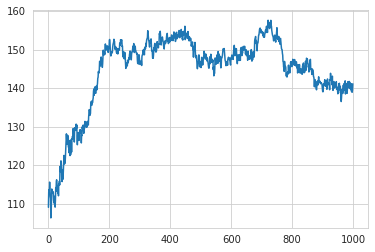

In [68]:
plt.plot(range(1000),np.sum(cfgs, axis=(1,2)))

## Comparison with normal HMC

In [44]:
N = 8
d = 2
b = 0.6
l = 0.02

lattice_hmc = Lattice(N, d, b, l)

print("burn in...\n")

for i in tqdm(range(1000)):
    lattice_hmc.hmc()

print("\nrecording...\n")
cfgs_hmc = []
n_accepted = 0
n_steps = 10000

for i in tqdm(range(n_steps)):
    n_accepted += lattice_hmc.hmc()

    if i % 10 == 0:
        cfgs_hmc.append(copy.deepcopy(lattice_hmc.phi))

cfgs_hmc = np.array(cfgs_hmc)
print("\ndone.")
print("accept rate:", n_accepted / n_steps)

print("\ncalculating observables...\n")

mag_mean, mag_err = get_mag(cfgs_hmc)
print("M =", mag_mean, "+/-", mag_err)

mag_abs_mean, mag_abs_err = get_abs_mag(cfgs_hmc)
print("|M| =", mag_abs_mean, "+/-", mag_abs_err)

chi2_mean, chi2_err = get_chi2(cfgs_hmc)
print("chi2 =", chi2_mean, "+/-", chi2_err)


burn in...



100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 62.11it/s]



recording...



100%|████████████████████████████████████| 10000/10000 [01:08<00:00, 146.60it/s]


done.
accept rate: 0.9998

calculating observables...

M = 2.197709065831461 +/- 0.004723221820869554
|M| = 2.197709065831461 +/- 0.004723221820869554
chi2 = 1.426336994865477 +/- 1.318681397998067


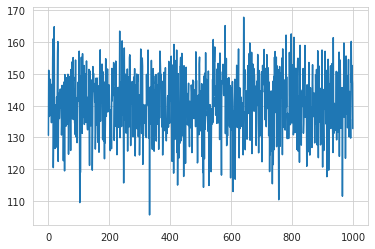

In [70]:
plt.plot(range(1000),np.sum(cfgs_hmc, axis=(1,2)))

## Some tests

In [61]:
def check_force(phi, coupling_layers, action, epsilon):
    phi_eps = torch.clone(phi).detach()
    phi_eps[0,6,4] += epsilon
    
    phi_aux, S_i, log_i = apply_flow_to_fields(phi, coupling_layers, action)
    phi_aux, S_eps, log_eps = apply_flow_to_fields(phi_eps, coupling_layers, action)
    
    return (S_i+log_i-S_eps-log_eps)/epsilon